In [1]:
import os
import json
import collections
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [2]:
!git clone https://gitlab.com/arabic-nlp/propaganda-detection.git
%cd propaganda-detection


Cloning into 'propaganda-detection'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 154 (delta 89), reused 5 (delta 3), pack-reused 0
Receiving objects: 100% (154/154), 245.60 KiB | 5.22 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/propaganda-detection


In [3]:
import sys
import pandas as pd
import json
import random
import argparse
import warnings
import matplotlib.pyplot as plt
import torch
import time
import datetime
import numpy as np
import seaborn as sns

random.seed(42) # to make runs deterministic




In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
import re
import string
import sys
import argparse

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def clean_text(text):
    text = remove_punctuations(text)
    text = remove_diacritics(text)
    text = remove_repeating_char(text)
    return text

In [6]:
!mkdir output
dev_file = 'data/task1_dev.json'
test_file = 'data/task1_test_gold_label_final.json'
train_file = 'data/task1_train.json'

task_output_file= 'output/baseline-output-task1.json'

propaganda_techniques_file = "techniques_list_task1-2.txt"


In [7]:
def get_labels(propaganda_techniques_names,techniques_names):
    labels = []
    for name in propaganda_techniques_names:
        if name in techniques_names:
           labels.append(1)
        else:
           labels.append(0)
    return labels
    

In [8]:
def load_df(jsonobj,get_label):
    df = []
    for example in jsonobj:
        techniques_list = []
        tmp_propaganda_techniques_names = propaganda_techniques_names[:]
        if get_label:
            row = get_labels(propaganda_techniques_names,example['labels'])
            row.insert(0, example['text'])
            row.insert(0, example['id'])
        else:
            row = [example['id'],example['text']]
        df.append(row)

    if get_label:
        df = pd.DataFrame(df, columns=['id','text']+propaganda_techniques_names)
        df['text'] = df['text'].apply(lambda x: clean_text(x))
    else:
        df = pd.DataFrame(df, columns=['id','text'])
        df['text'] = df['text'].apply(lambda x: clean_text(x))
        
    return df

try:
    with open(dev_file, "r") as f:
        devjsonobj = json.load(f)
    with open(test_file, "r") as f:
        testjsonobj = json.load(f)
    with open(train_file, "r") as f:
        trainjsonobj = json.load(f)
except:
    sys.exit("ERROR: cannot load json file")

with open(propaganda_techniques_file, "r") as f:
    propaganda_techniques_names = [ line.rstrip() for line in f.readlines() if len(line)>2 ]

propaganda_techniques_names = propaganda_techniques_names[:-2]
dev_df = load_df(devjsonobj,True)
test_df =load_df(testjsonobj,True)
train_df =load_df(trainjsonobj,True)
train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)
train_dev_test_df = pd.concat([train_dev_df, test_df], ignore_index=True)


In [9]:
train_df.shape,dev_df.shape,test_df.shape

((504, 21), (52, 21), (323, 21))

In [10]:
train_df = train_dev_df

In [11]:
train_df.shape

(556, 21)

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning


In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 19.0 MB/s 
     |████████████████████████████████| 7.6 MB 55.5 MB/s 
     |████████████████████████████████| 163 kB 58.3 MB/s 


In [16]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.functional import accuracy,auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

In [17]:
train_df[propaganda_techniques_names].sum().sort_values()

Misrepresentation of Someone's Position (Straw Man)      0
Reductio ad hitlerum                                     0
Presenting Irrelevant Data (Red Herring)                 1
Black-and-white Fallacy/Dictatorship                     3
Whataboutism                                             4
Causal Oversimplification                                5
Flag-waving                                              7
Thought-terminating cliché                               7
Repetition                                               9
Obfuscation, Intentional vagueness, Confusion           12
Doubt                                                   28
Appeal to authority                                     28
Slogans                                                 29
Glittering generalities (Virtue)                        32
Exaggeration/Minimisation                               51
Appeal to fear/prejudice                                54
Smears                                                  

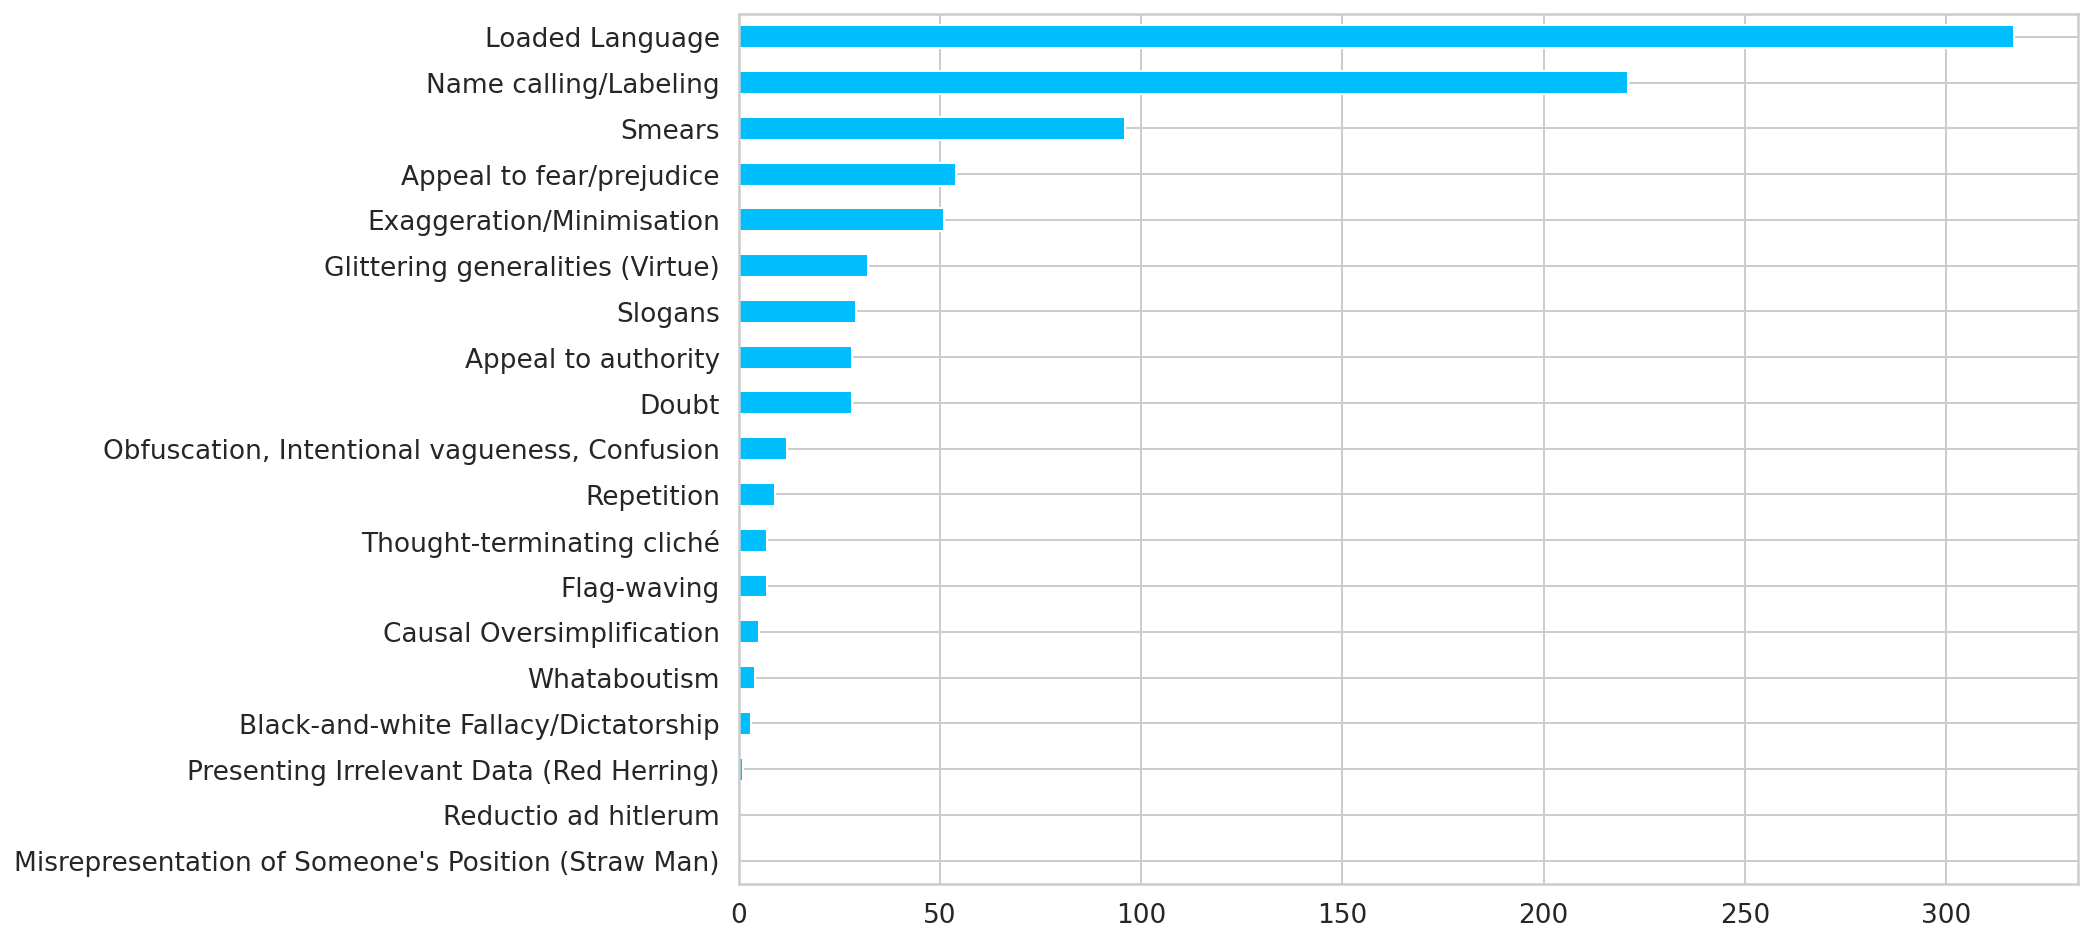

In [18]:
train_df[propaganda_techniques_names].sum().sort_values().plot(kind="barh");


In [19]:
dev_df[propaganda_techniques_names].sum().sort_values()

Misrepresentation of Someone's Position (Straw Man)     0
Reductio ad hitlerum                                    0
Presenting Irrelevant Data (Red Herring)                0
Slogans                                                 1
Thought-terminating cliché                              1
Whataboutism                                            1
Doubt                                                   1
Causal Oversimplification                               1
Black-and-white Fallacy/Dictatorship                    1
Flag-waving                                             2
Repetition                                              2
Obfuscation, Intentional vagueness, Confusion           3
Glittering generalities (Virtue)                        7
Appeal to fear/prejudice                                7
Appeal to authority                                     7
Exaggeration/Minimisation                              10
Smears                                                 12
Loaded Languag

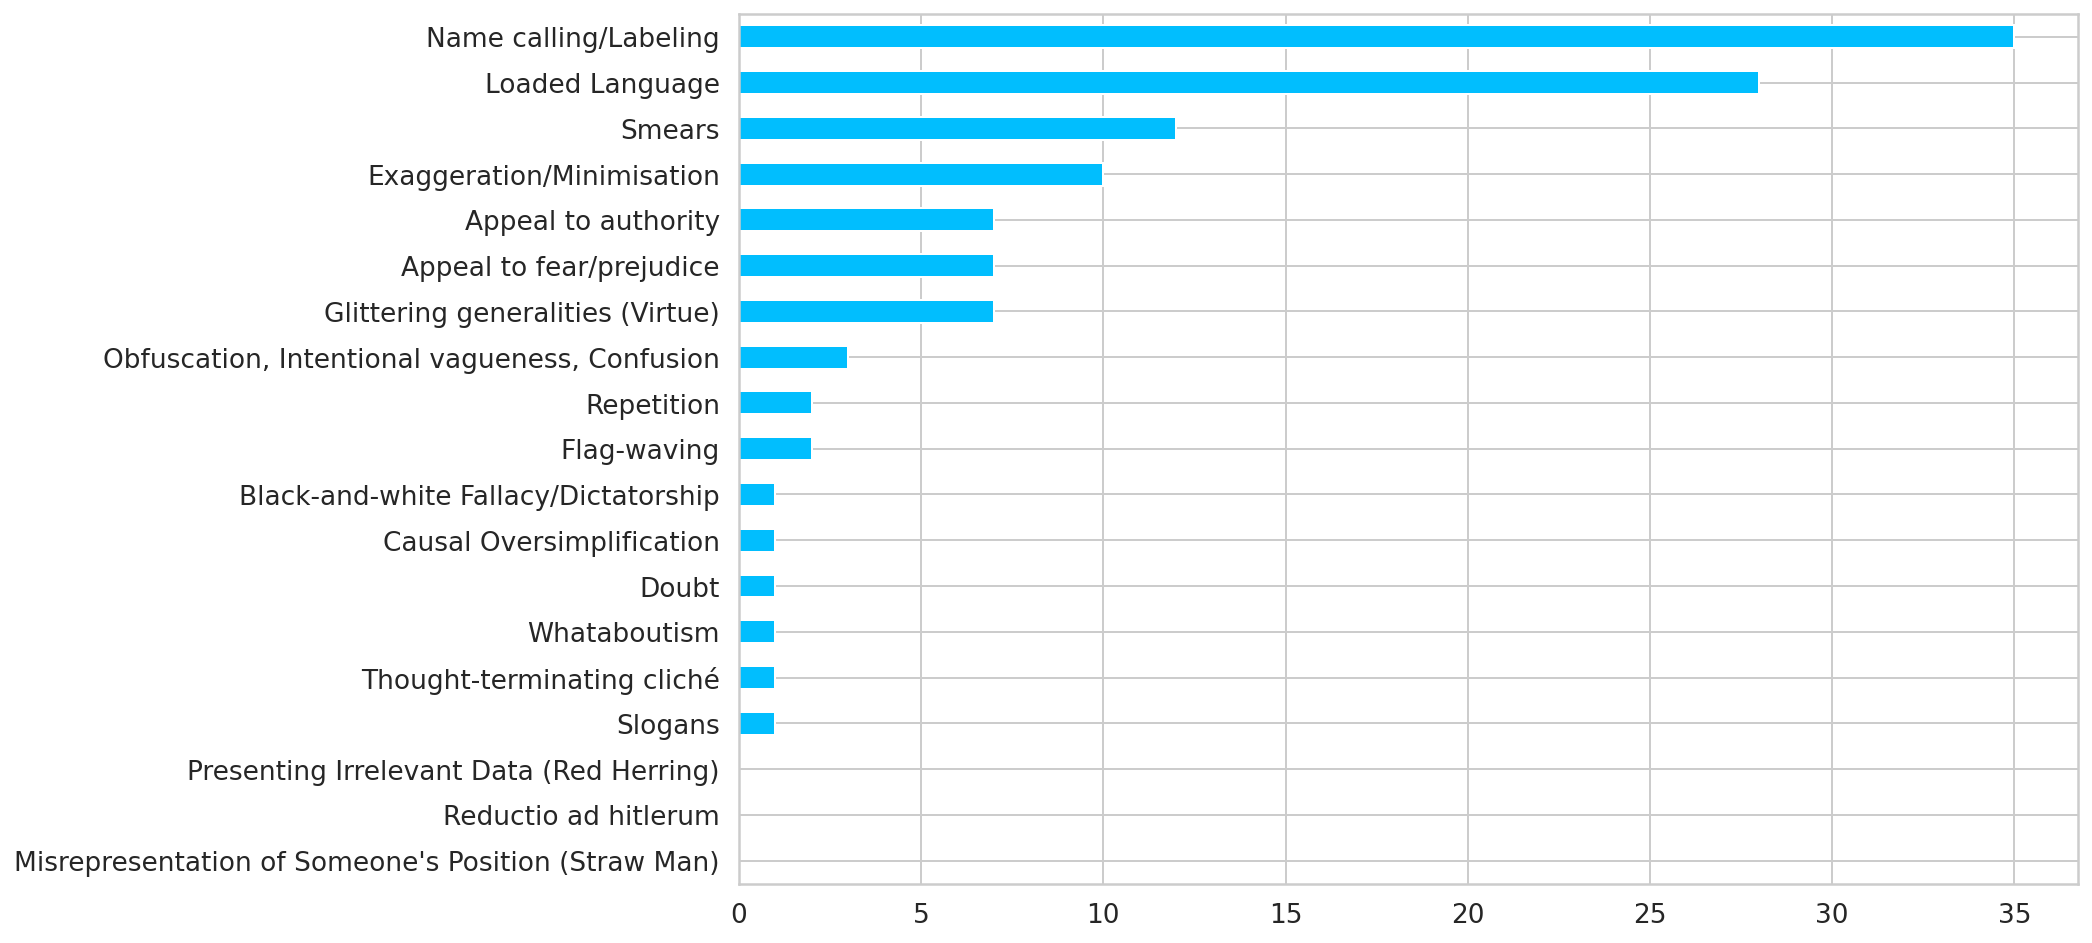

In [20]:
dev_df[propaganda_techniques_names].sum().sort_values().plot(kind="barh");


In [21]:
test_df[propaganda_techniques_names].sum().sort_values()

Whataboutism                                             0
Reductio ad hitlerum                                     0
Presenting Irrelevant Data (Red Herring)                 0
Thought-terminating cliché                               0
Glittering generalities (Virtue)                         1
Appeal to authority                                      1
Misrepresentation of Someone's Position (Straw Man)      1
Repetition                                               3
Causal Oversimplification                                4
Obfuscation, Intentional vagueness, Confusion            6
Black-and-white Fallacy/Dictatorship                     7
Slogans                                                  7
Flag-waving                                             10
Doubt                                                   19
Exaggeration/Minimisation                               23
Appeal to fear/prejudice                                25
Smears                                                  

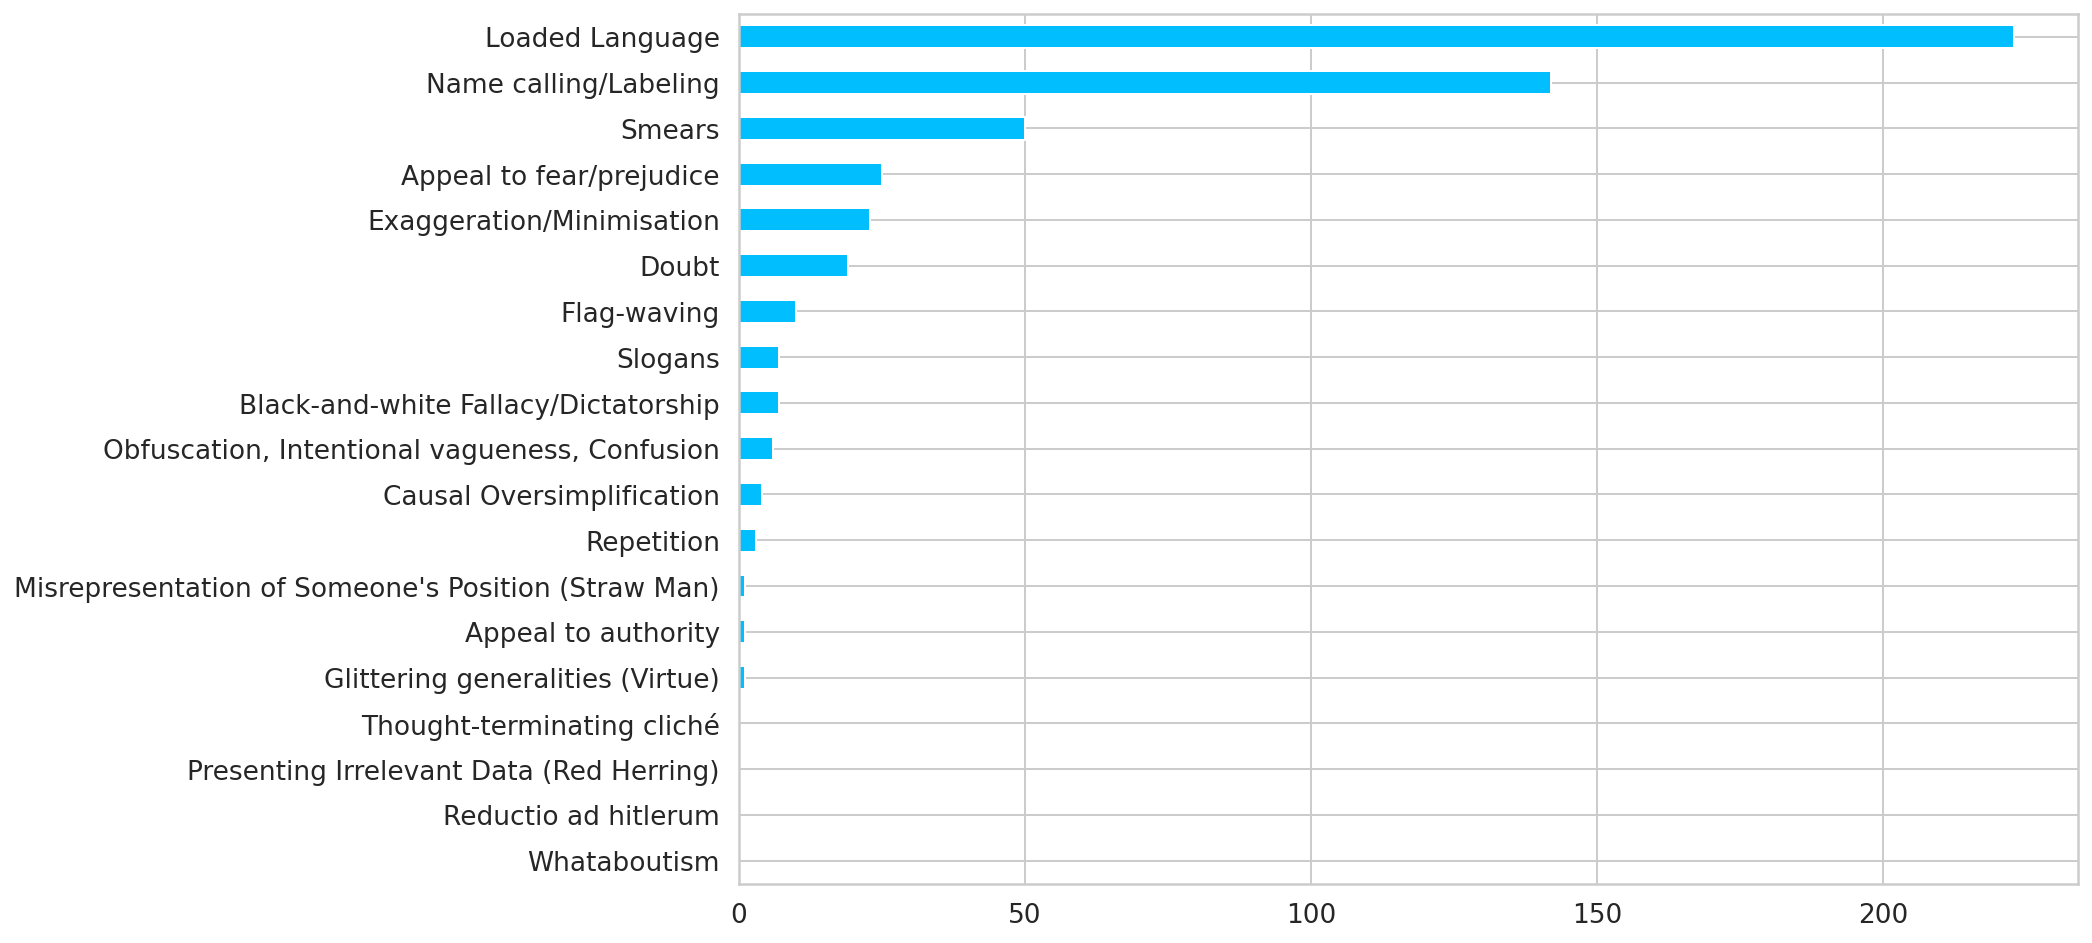

In [22]:
test_df[propaganda_techniques_names].sum().sort_values().plot(kind="barh");


In [23]:
BERT_MODEL_NAME = "asafaya/bert-base-arabic"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [24]:
sample_row = train_df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[propaganda_techniques_names]
print(sample_comment)
print()
print(sample_labels.to_dict())

المنتخب الألماني يعود بانتصار ثمين في تصفيات المونديال htpstcohYty4VJ4TX

{'Appeal to authority': 0, 'Appeal to fear/prejudice': 0, 'Black-and-white Fallacy/Dictatorship': 0, 'Causal Oversimplification': 0, 'Doubt': 0, 'Exaggeration/Minimisation': 0, 'Flag-waving': 0, 'Glittering generalities (Virtue)': 0, 'Loaded Language': 1, "Misrepresentation of Someone's Position (Straw Man)": 0, 'Name calling/Labeling': 0, 'Obfuscation, Intentional vagueness, Confusion': 0, 'Presenting Irrelevant Data (Red Herring)': 0, 'Reductio ad hitlerum': 0, 'Repetition': 0, 'Slogans': 0, 'Smears': 0, 'Thought-terminating cliché': 0, 'Whataboutism': 0}


In [25]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [27]:
encoding["input_ids"].squeeze()[:20]

tensor([    2,  5261,  7530,  5892,  8844,  2761,  2109,  1724,  1725, 18027,
        22637,  3787, 14452,  1059, 15432,  1061, 18796,  1058,  1037,  1063])

In [28]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])


['[CLS]', 'المنتخب', 'الالماني', 'يعود', 'بانت', '##صار', 'ثم', '##ين', 'في', 'تصفيات', 'المونديال', 'ht', '##ps', '##t', '##co', '##h', '##yt', '##y', '##4', '##v']


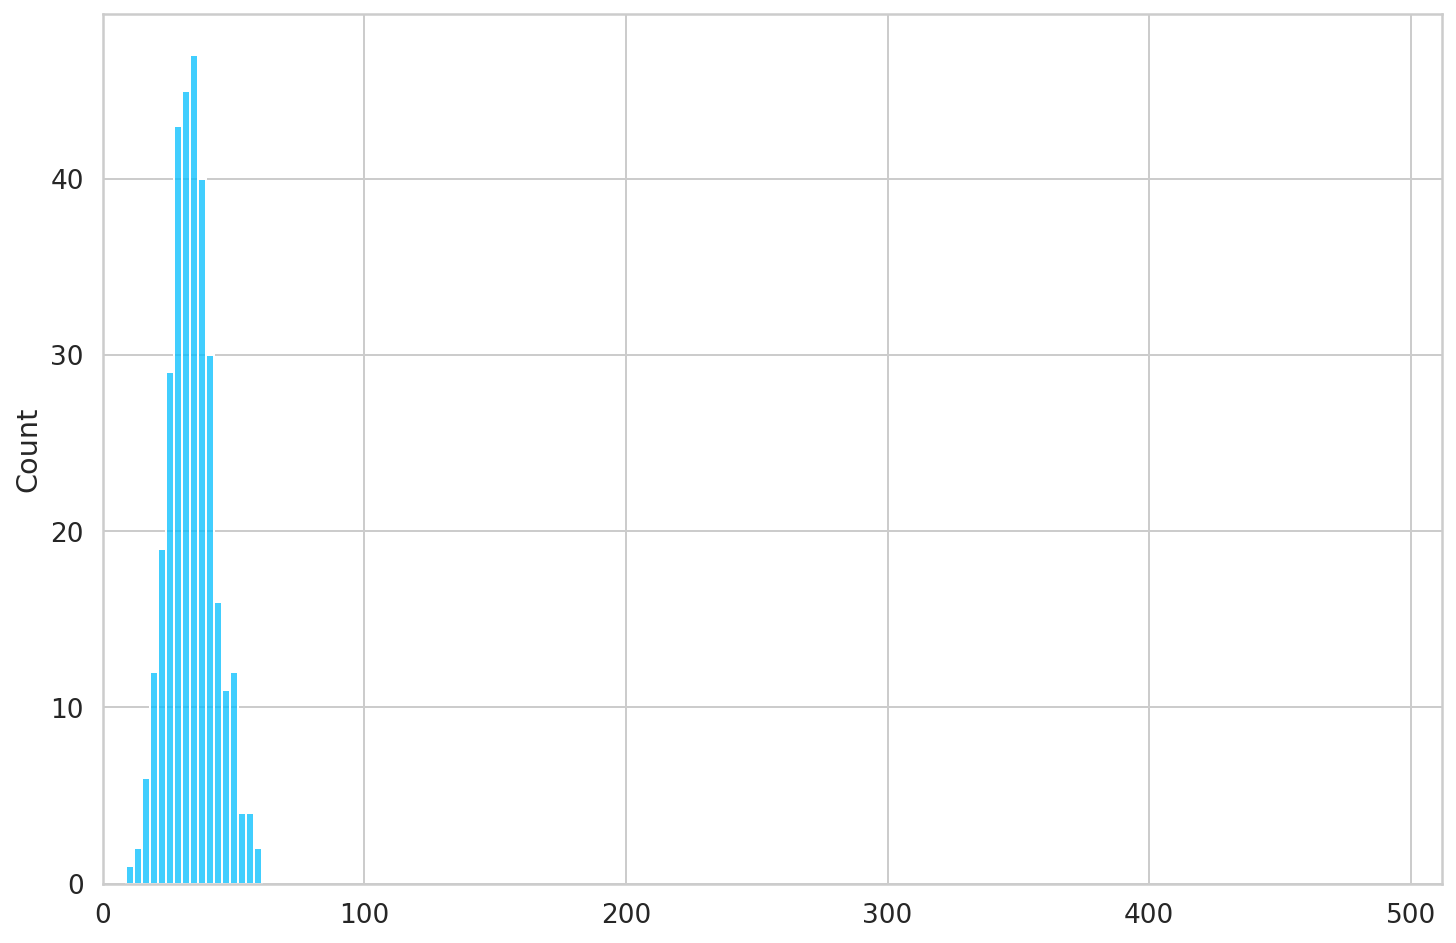

In [30]:
token_counts = []
for _, row in test_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [135]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)


(64, 8, 30.071942446043167)

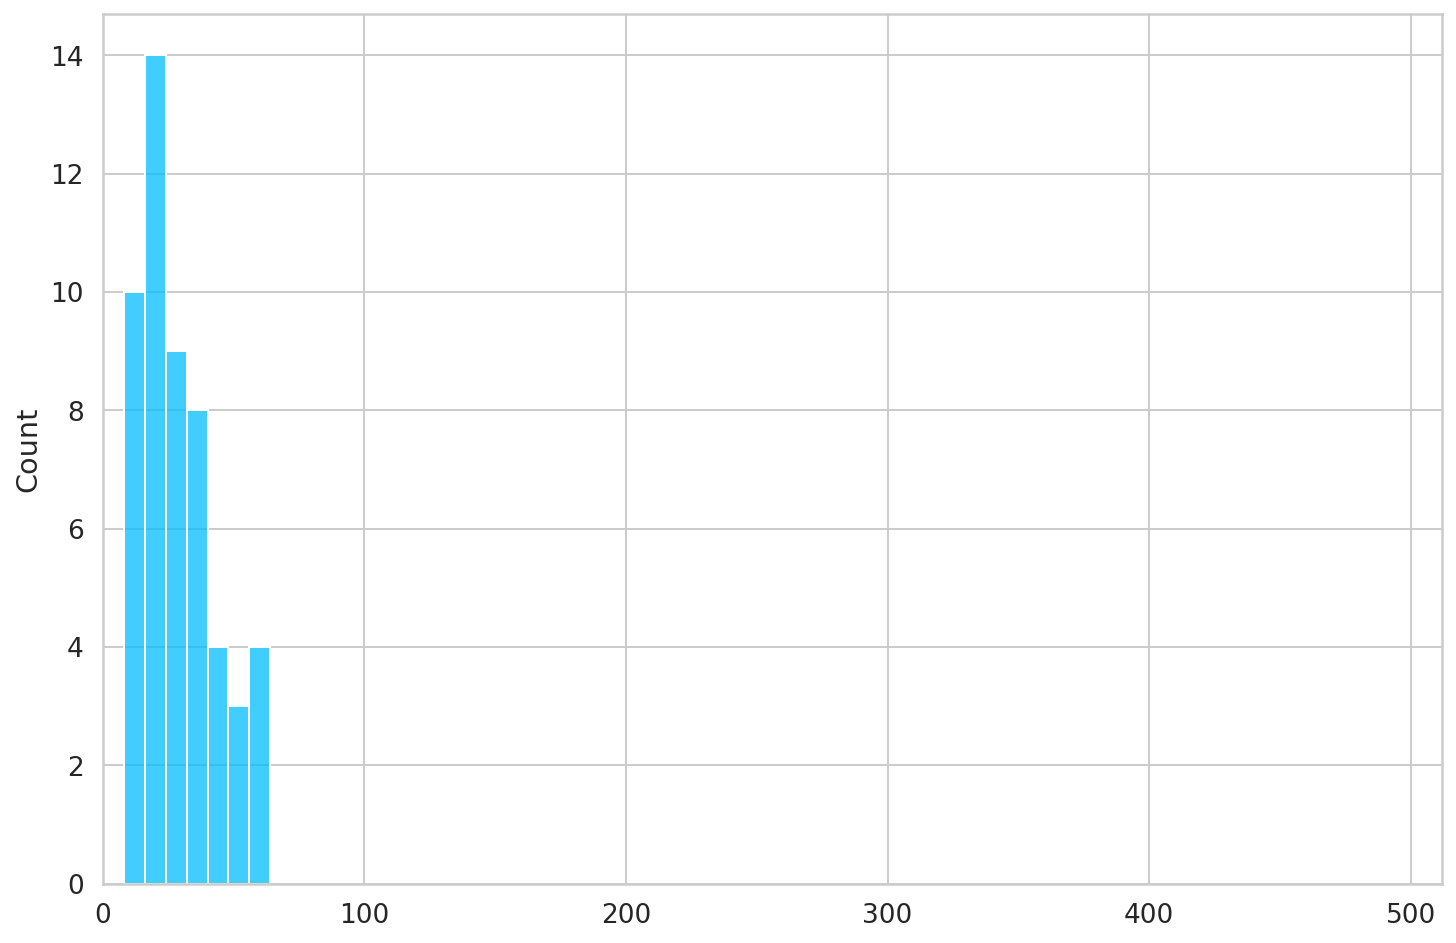

In [32]:
token_counts = []
for _, row in dev_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [136]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)


(64, 8, 30.071942446043167)

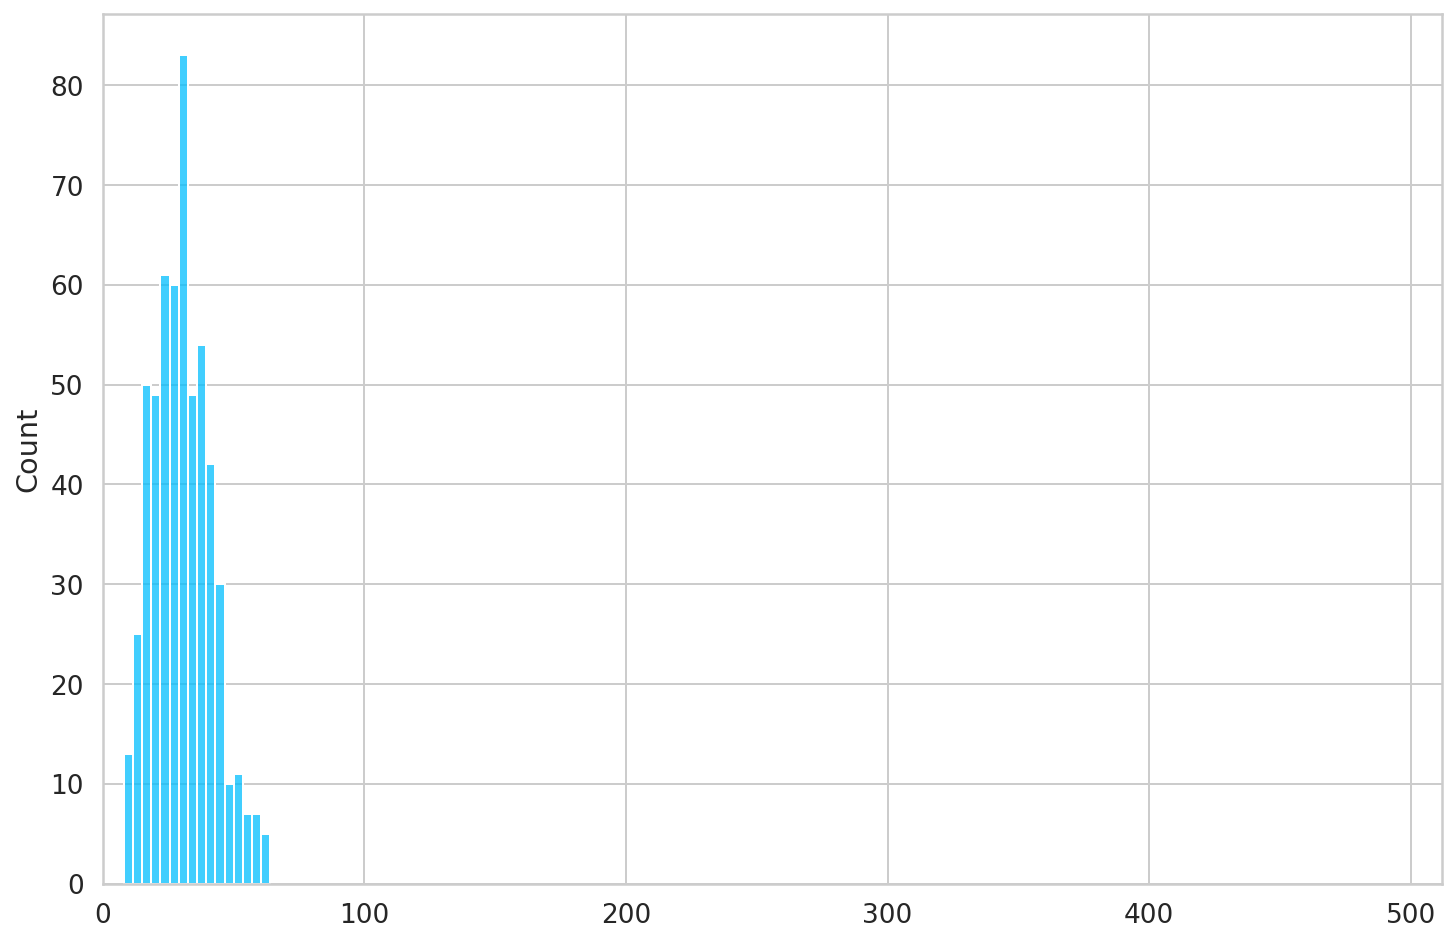

In [34]:
token_counts = []
for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [137]:
max(token_counts), min(token_counts), sum(token_counts) / len(token_counts)


(64, 8, 30.071942446043167)

In [36]:
MAX_TOKEN_COUNT = 100


In [37]:
class propaganCommentsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.text
    labels = data_row[propaganda_techniques_names]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [38]:
train_dataset = propaganCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [39]:
sample_item["comment_text"]


'بيبيسيترندينغ النساء تثرثر كثيرا رئيس أولمبياد طوكيو يتعرض لضغوط لاستقالة بعد تصريحه المثير لجدل htpstcoYwth34LqF'

In [40]:
sample_item["labels"]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
sample_item["input_ids"].shape


torch.Size([100])

In [42]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([8, 100]), torch.Size([8, 100]))

In [43]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])


In [44]:
output.last_hidden_state.shape, output.pooler_output.shape


(torch.Size([8, 100, 768]), torch.Size([8, 768]))

In [45]:
bert_model.config.hidden_size


768

In [46]:
class propaganCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = propaganCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = propaganCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [47]:
N_EPOCHS = 10
BATCH_SIZE = 12
data_module = propaganCommentDataModule(
  train_df,
  dev_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [48]:
class propaganCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(propaganda_techniques_names):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [49]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [50]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(92, 460)

In [51]:
model = propaganCommentTagger(
  n_classes=len(propaganda_techniques_names),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
logger = TensorBoardLogger("lightning_logs", name="propagan-comments")


In [53]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)


In [54]:
trainer = pl.Trainer(
    logger=logger,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,   
    gpus=1,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [55]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 110 M 
1 | classifier | Linear    | 14.6 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.528   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [56]:
trained_model = propaganCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(propaganda_techniques_names)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
def pred(test_comment):
    encoding = tokenizer.encode_plus(
      test_comment,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    test_prediction = test_prediction.flatten().numpy()
    return test_prediction
    

In [58]:
def get_pred_labels(test_comment):
    test_prediction = pred(test_comment)
    predictions = []
    for label, prediction in zip(propaganda_techniques_names, test_prediction):
        if prediction < THRESHOLDS[label]:
            continue
        predictions.append(label)
    if len(predictions) == 0:
        predictions.append('no technique')
    return predictions

In [59]:
for um , n in enumerate(propaganda_techniques_names):
    print(um , n)

0 Appeal to authority
1 Appeal to fear/prejudice
2 Black-and-white Fallacy/Dictatorship
3 Causal Oversimplification
4 Doubt
5 Exaggeration/Minimisation
6 Flag-waving
7 Glittering generalities (Virtue)
8 Loaded Language
9 Misrepresentation of Someone's Position (Straw Man)
10 Name calling/Labeling
11 Obfuscation, Intentional vagueness, Confusion
12 Presenting Irrelevant Data (Red Herring)
13 Reductio ad hitlerum
14 Repetition
15 Slogans
16 Smears
17 Thought-terminating cliché
18 Whataboutism


In [60]:
scoress = [pred(row['text']) for index, row in dev_df.iterrows()]


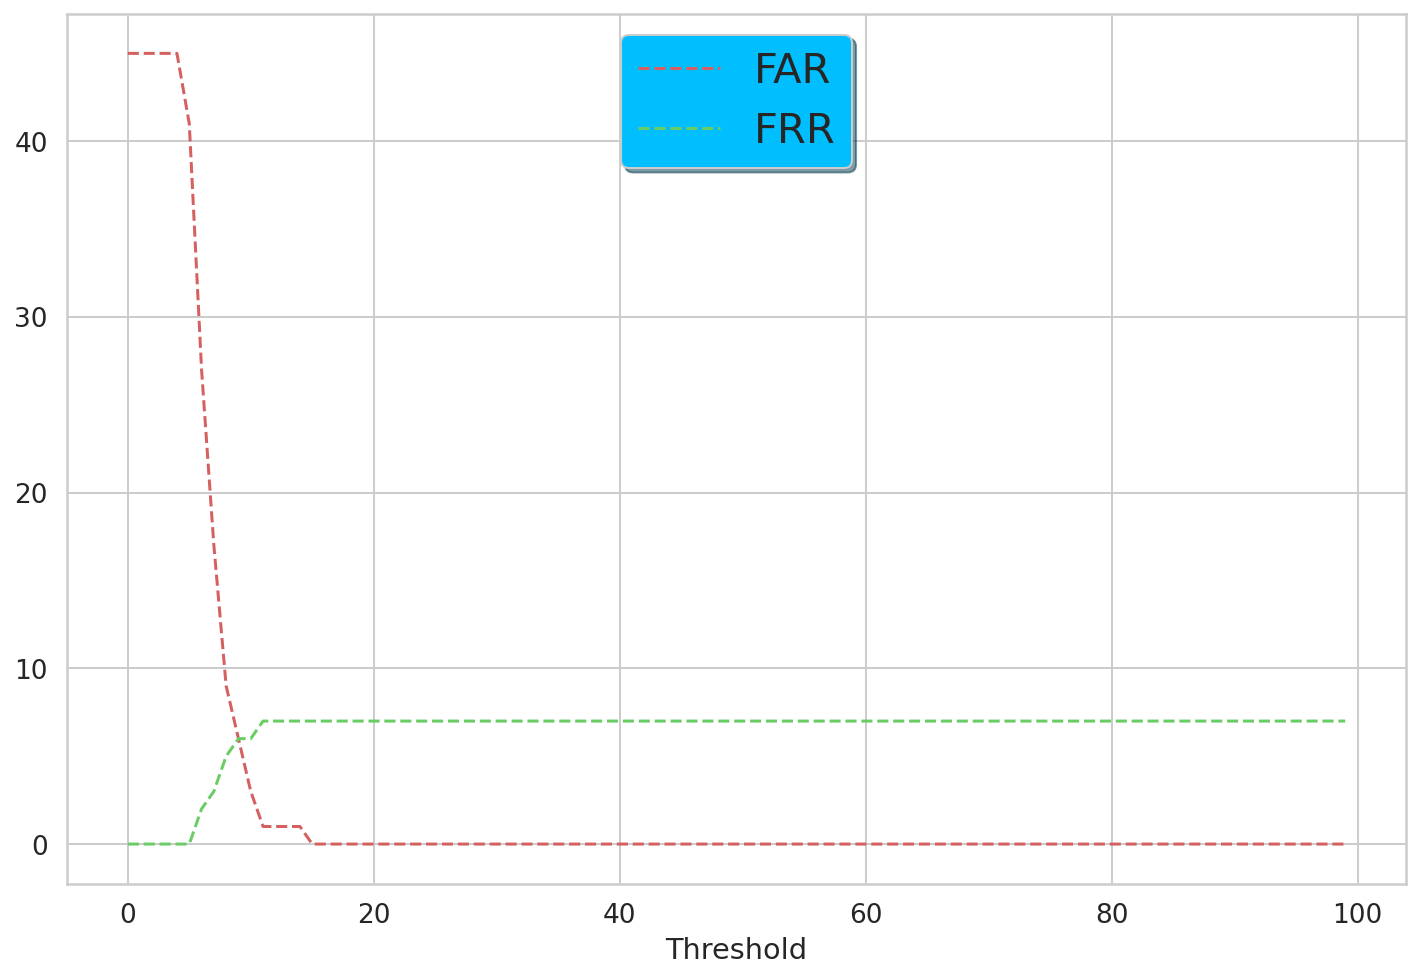

In [61]:
i = 0
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [62]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 45 0 0
1 45 0 0
2 45 0 0
3 45 0 0
4 45 0 0
5 41 0 0
6 27 2 54
7 17 3 51
8 9 5 45
9 6 6 36
10 3 6 18
11 1 7 7
12 1 7 7
13 1 7 7
14 1 7 7
15 0 7 0
16 0 7 0
17 0 7 0
18 0 7 0
19 0 7 0
20 0 7 0
21 0 7 0
22 0 7 0
23 0 7 0
24 0 7 0
25 0 7 0
26 0 7 0
27 0 7 0
28 0 7 0
29 0 7 0
30 0 7 0
31 0 7 0
32 0 7 0
33 0 7 0
34 0 7 0
35 0 7 0
36 0 7 0
37 0 7 0
38 0 7 0
39 0 7 0
40 0 7 0
41 0 7 0
42 0 7 0
43 0 7 0
44 0 7 0
45 0 7 0
46 0 7 0
47 0 7 0
48 0 7 0
49 0 7 0
50 0 7 0
51 0 7 0
52 0 7 0
53 0 7 0
54 0 7 0
55 0 7 0
56 0 7 0
57 0 7 0
58 0 7 0
59 0 7 0
60 0 7 0
61 0 7 0
62 0 7 0
63 0 7 0
64 0 7 0
65 0 7 0
66 0 7 0
67 0 7 0
68 0 7 0
69 0 7 0
70 0 7 0
71 0 7 0
72 0 7 0
73 0 7 0
74 0 7 0
75 0 7 0
76 0 7 0
77 0 7 0
78 0 7 0
79 0 7 0
80 0 7 0
81 0 7 0
82 0 7 0
83 0 7 0
84 0 7 0
85 0 7 0
86 0 7 0
87 0 7 0
88 0 7 0
89 0 7 0
90 0 7 0
91 0 7 0
92 0 7 0
93 0 7 0
94 0 7 0
95 0 7 0
96 0 7 0
97 0 7 0
98 0 7 0
99 0 7 0


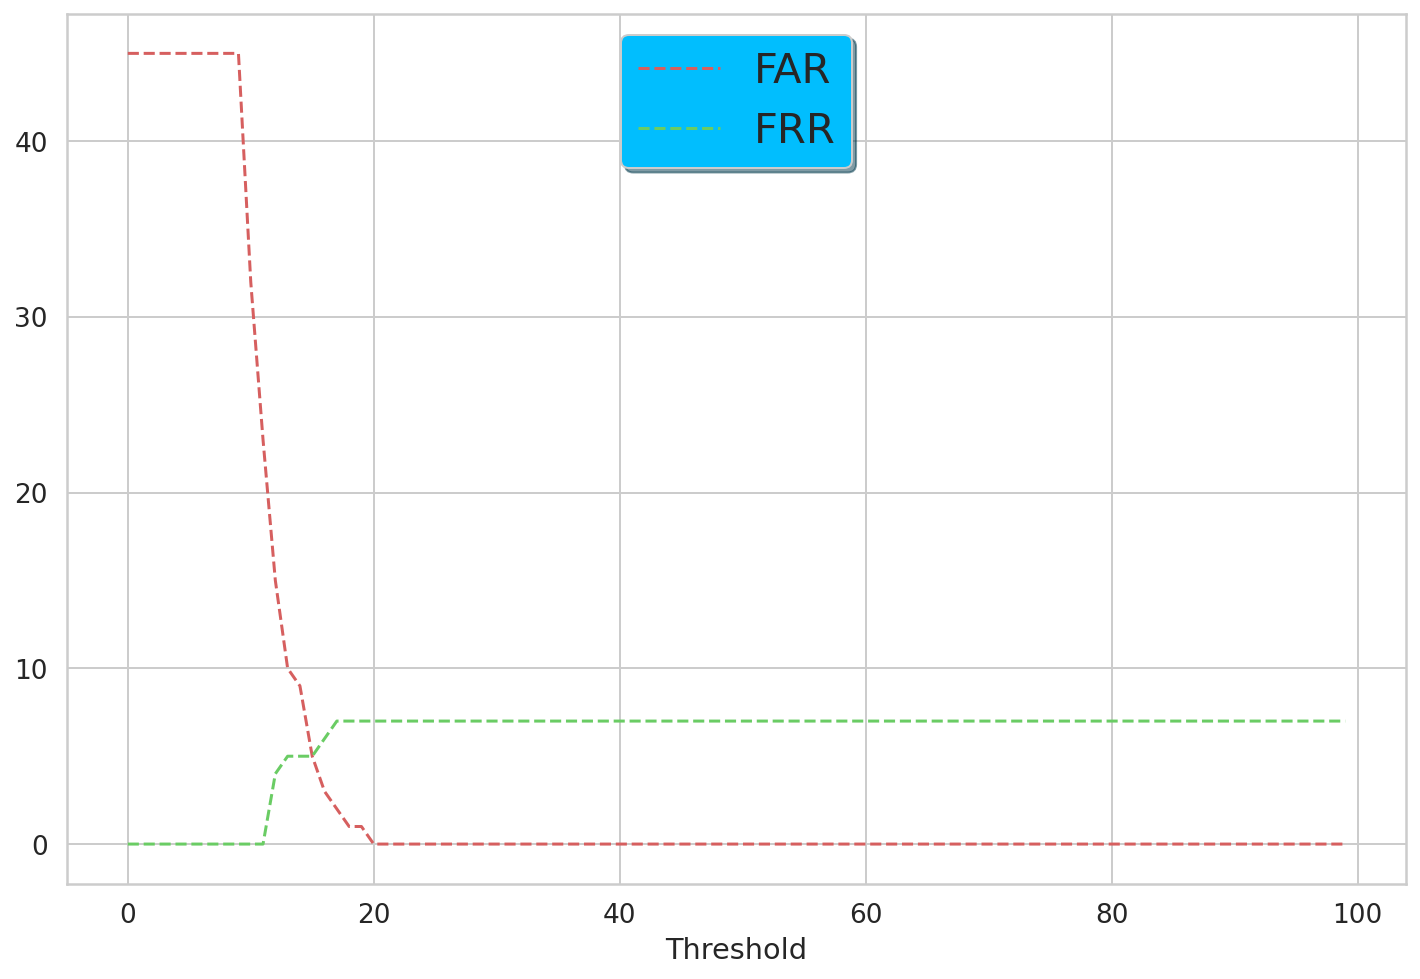

In [63]:
i = 1
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [64]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 45 0 0
1 45 0 0
2 45 0 0
3 45 0 0
4 45 0 0
5 45 0 0
6 45 0 0
7 45 0 0
8 45 0 0
9 45 0 0
10 32 0 0
11 23 0 0
12 15 4 60
13 10 5 50
14 9 5 45
15 5 5 25
16 3 6 18
17 2 7 14
18 1 7 7
19 1 7 7
20 0 7 0
21 0 7 0
22 0 7 0
23 0 7 0
24 0 7 0
25 0 7 0
26 0 7 0
27 0 7 0
28 0 7 0
29 0 7 0
30 0 7 0
31 0 7 0
32 0 7 0
33 0 7 0
34 0 7 0
35 0 7 0
36 0 7 0
37 0 7 0
38 0 7 0
39 0 7 0
40 0 7 0
41 0 7 0
42 0 7 0
43 0 7 0
44 0 7 0
45 0 7 0
46 0 7 0
47 0 7 0
48 0 7 0
49 0 7 0
50 0 7 0
51 0 7 0
52 0 7 0
53 0 7 0
54 0 7 0
55 0 7 0
56 0 7 0
57 0 7 0
58 0 7 0
59 0 7 0
60 0 7 0
61 0 7 0
62 0 7 0
63 0 7 0
64 0 7 0
65 0 7 0
66 0 7 0
67 0 7 0
68 0 7 0
69 0 7 0
70 0 7 0
71 0 7 0
72 0 7 0
73 0 7 0
74 0 7 0
75 0 7 0
76 0 7 0
77 0 7 0
78 0 7 0
79 0 7 0
80 0 7 0
81 0 7 0
82 0 7 0
83 0 7 0
84 0 7 0
85 0 7 0
86 0 7 0
87 0 7 0
88 0 7 0
89 0 7 0
90 0 7 0
91 0 7 0
92 0 7 0
93 0 7 0
94 0 7 0
95 0 7 0
96 0 7 0
97 0 7 0
98 0 7 0
99 0 7 0


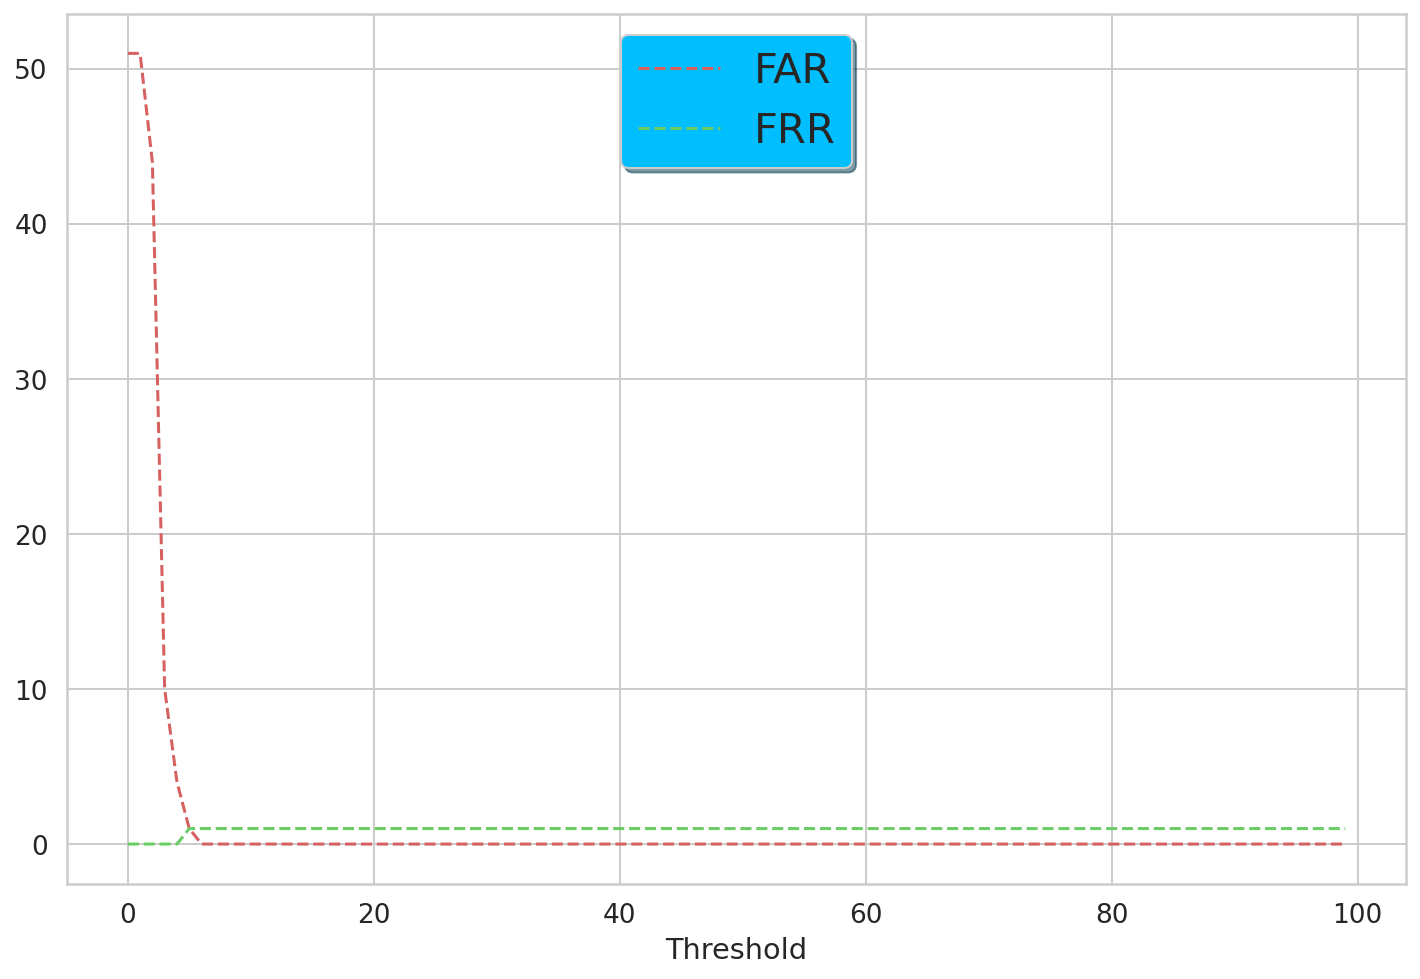

In [65]:
i = 2
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [66]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 44 0 0
3 10 0 0
4 4 0 0
5 1 1 1
6 0 1 0
7 0 1 0
8 0 1 0
9 0 1 0
10 0 1 0
11 0 1 0
12 0 1 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


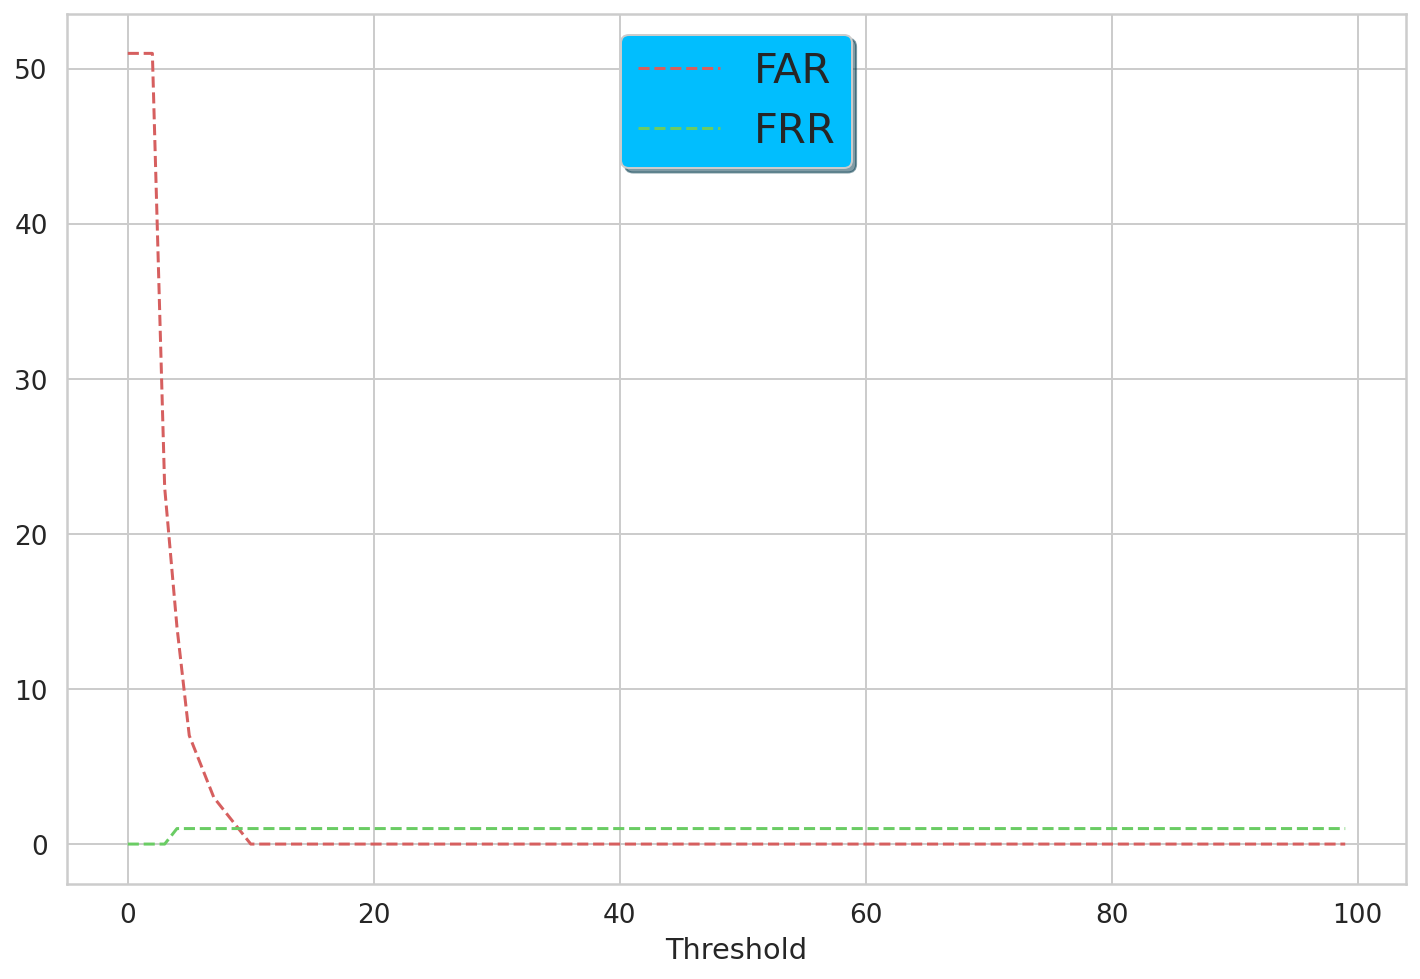

In [67]:
i = 3
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [68]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 51 0 0
3 23 0 0
4 14 1 14
5 7 1 7
6 5 1 5
7 3 1 3
8 2 1 2
9 1 1 1
10 0 1 0
11 0 1 0
12 0 1 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


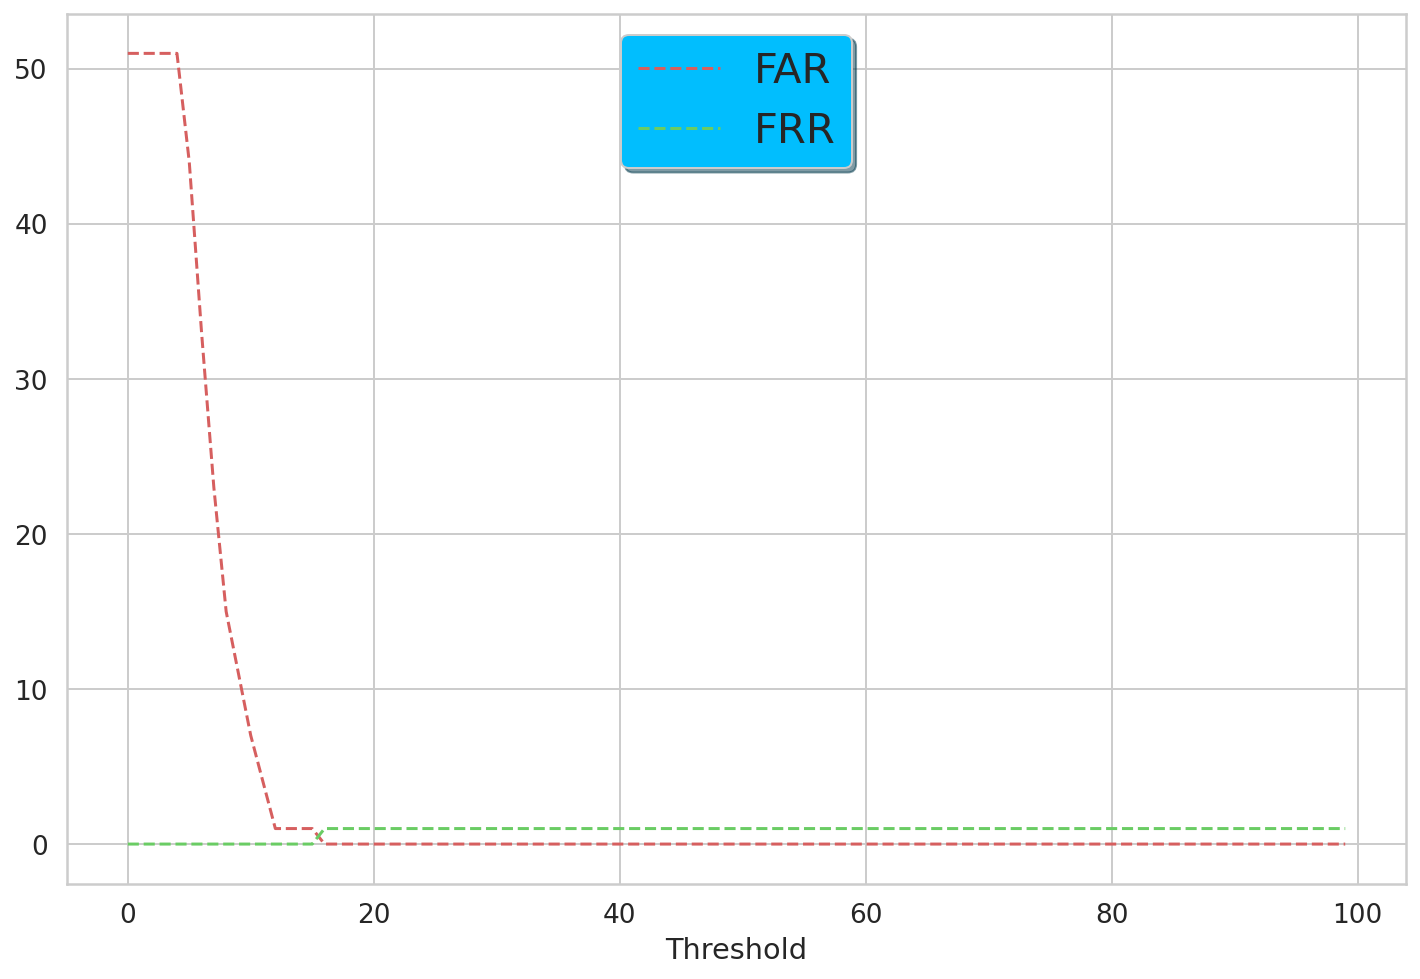

In [69]:
i = 4
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [70]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 51 0 0
3 51 0 0
4 51 0 0
5 44 0 0
6 33 0 0
7 23 0 0
8 15 0 0
9 11 0 0
10 7 0 0
11 4 0 0
12 1 0 0
13 1 0 0
14 1 0 0
15 1 0 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


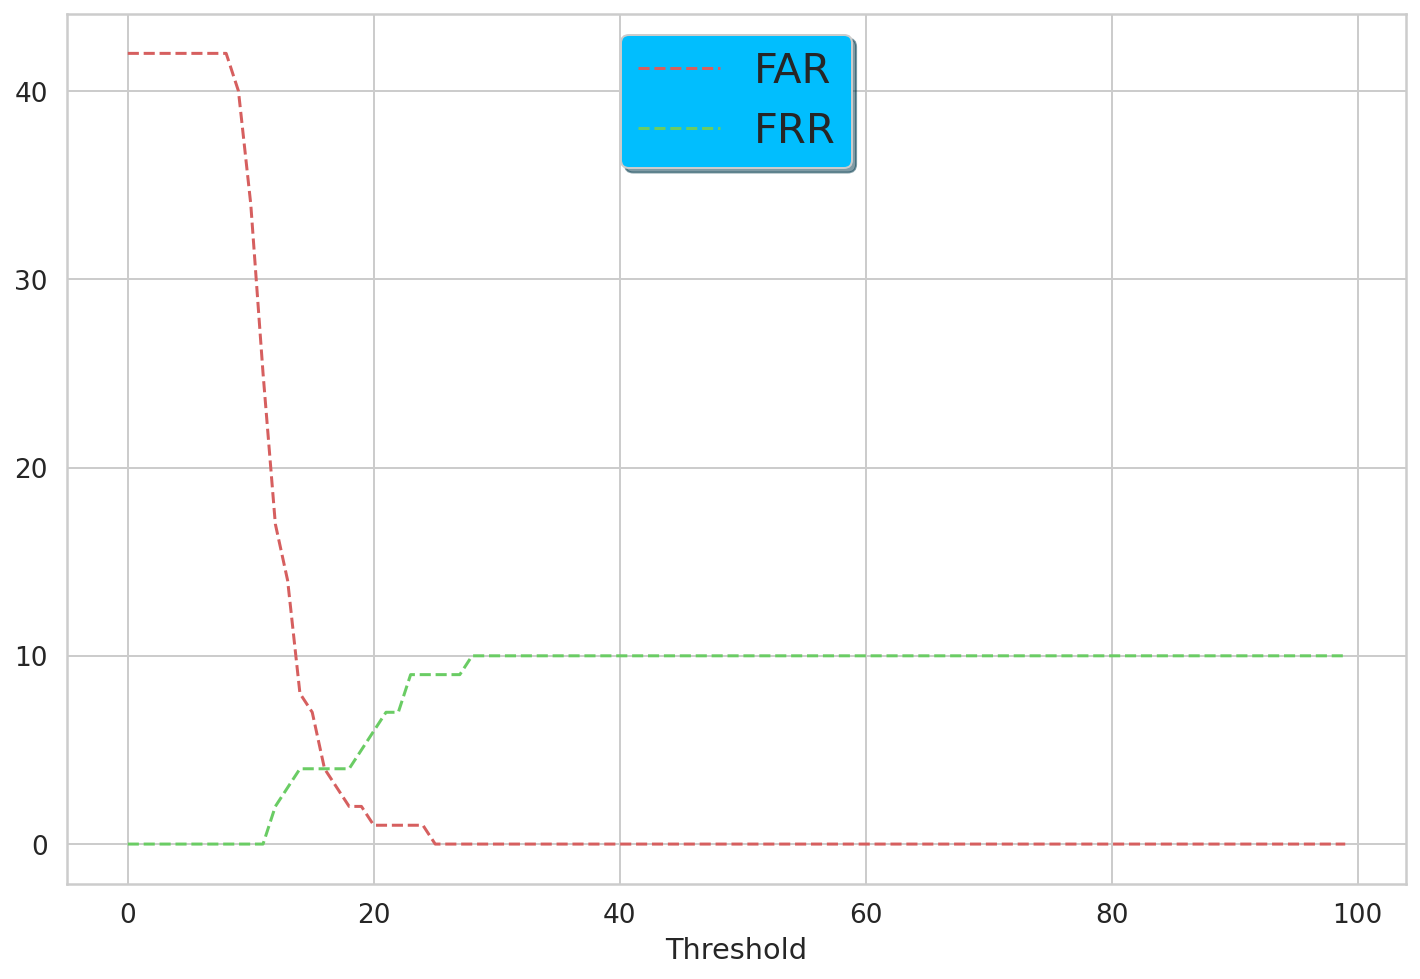

In [71]:
i = 5
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [72]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 42 0 0
1 42 0 0
2 42 0 0
3 42 0 0
4 42 0 0
5 42 0 0
6 42 0 0
7 42 0 0
8 42 0 0
9 40 0 0
10 34 0 0
11 25 0 0
12 17 2 34
13 14 3 42
14 8 4 32
15 7 4 28
16 4 4 16
17 3 4 12
18 2 4 8
19 2 5 10
20 1 6 6
21 1 7 7
22 1 7 7
23 1 9 9
24 1 9 9
25 0 9 0
26 0 9 0
27 0 9 0
28 0 10 0
29 0 10 0
30 0 10 0
31 0 10 0
32 0 10 0
33 0 10 0
34 0 10 0
35 0 10 0
36 0 10 0
37 0 10 0
38 0 10 0
39 0 10 0
40 0 10 0
41 0 10 0
42 0 10 0
43 0 10 0
44 0 10 0
45 0 10 0
46 0 10 0
47 0 10 0
48 0 10 0
49 0 10 0
50 0 10 0
51 0 10 0
52 0 10 0
53 0 10 0
54 0 10 0
55 0 10 0
56 0 10 0
57 0 10 0
58 0 10 0
59 0 10 0
60 0 10 0
61 0 10 0
62 0 10 0
63 0 10 0
64 0 10 0
65 0 10 0
66 0 10 0
67 0 10 0
68 0 10 0
69 0 10 0
70 0 10 0
71 0 10 0
72 0 10 0
73 0 10 0
74 0 10 0
75 0 10 0
76 0 10 0
77 0 10 0
78 0 10 0
79 0 10 0
80 0 10 0
81 0 10 0
82 0 10 0
83 0 10 0
84 0 10 0
85 0 10 0
86 0 10 0
87 0 10 0
88 0 10 0
89 0 10 0
90 0 10 0
91 0 10 0
92 0 10 0
93 0 10 0
94 0 10 0
95 0 10 0
96 0 10 0
97 0 10 0
98 0 10 0
99 0 10 0


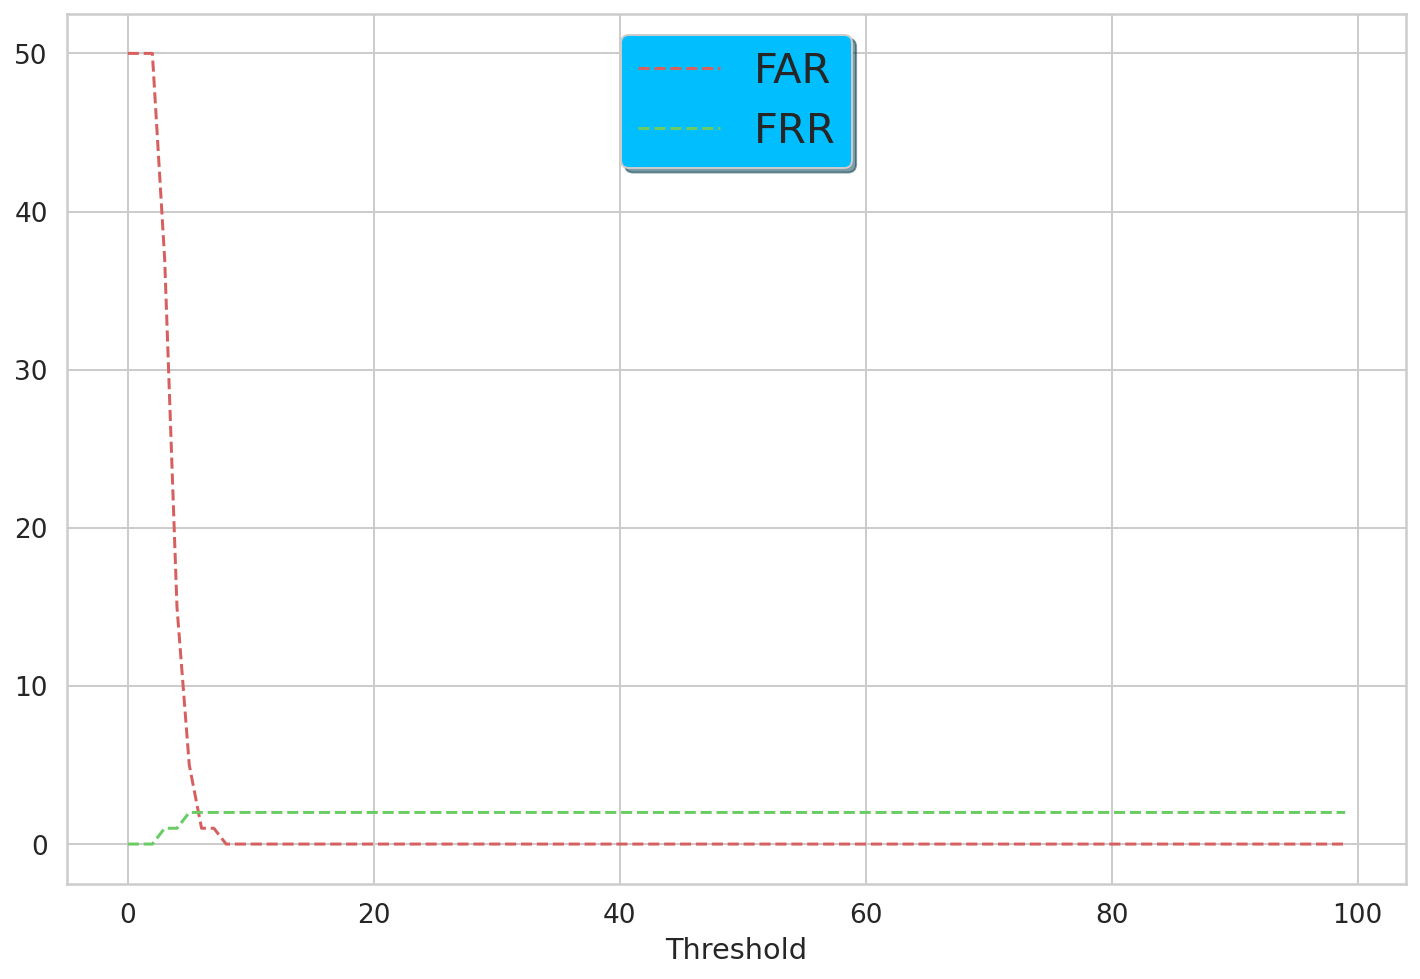

In [73]:
i = 6
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [74]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 50 0 0
1 50 0 0
2 50 0 0
3 37 1 37
4 15 1 15
5 5 2 10
6 1 2 2
7 1 2 2
8 0 2 0
9 0 2 0
10 0 2 0
11 0 2 0
12 0 2 0
13 0 2 0
14 0 2 0
15 0 2 0
16 0 2 0
17 0 2 0
18 0 2 0
19 0 2 0
20 0 2 0
21 0 2 0
22 0 2 0
23 0 2 0
24 0 2 0
25 0 2 0
26 0 2 0
27 0 2 0
28 0 2 0
29 0 2 0
30 0 2 0
31 0 2 0
32 0 2 0
33 0 2 0
34 0 2 0
35 0 2 0
36 0 2 0
37 0 2 0
38 0 2 0
39 0 2 0
40 0 2 0
41 0 2 0
42 0 2 0
43 0 2 0
44 0 2 0
45 0 2 0
46 0 2 0
47 0 2 0
48 0 2 0
49 0 2 0
50 0 2 0
51 0 2 0
52 0 2 0
53 0 2 0
54 0 2 0
55 0 2 0
56 0 2 0
57 0 2 0
58 0 2 0
59 0 2 0
60 0 2 0
61 0 2 0
62 0 2 0
63 0 2 0
64 0 2 0
65 0 2 0
66 0 2 0
67 0 2 0
68 0 2 0
69 0 2 0
70 0 2 0
71 0 2 0
72 0 2 0
73 0 2 0
74 0 2 0
75 0 2 0
76 0 2 0
77 0 2 0
78 0 2 0
79 0 2 0
80 0 2 0
81 0 2 0
82 0 2 0
83 0 2 0
84 0 2 0
85 0 2 0
86 0 2 0
87 0 2 0
88 0 2 0
89 0 2 0
90 0 2 0
91 0 2 0
92 0 2 0
93 0 2 0
94 0 2 0
95 0 2 0
96 0 2 0
97 0 2 0
98 0 2 0
99 0 2 0


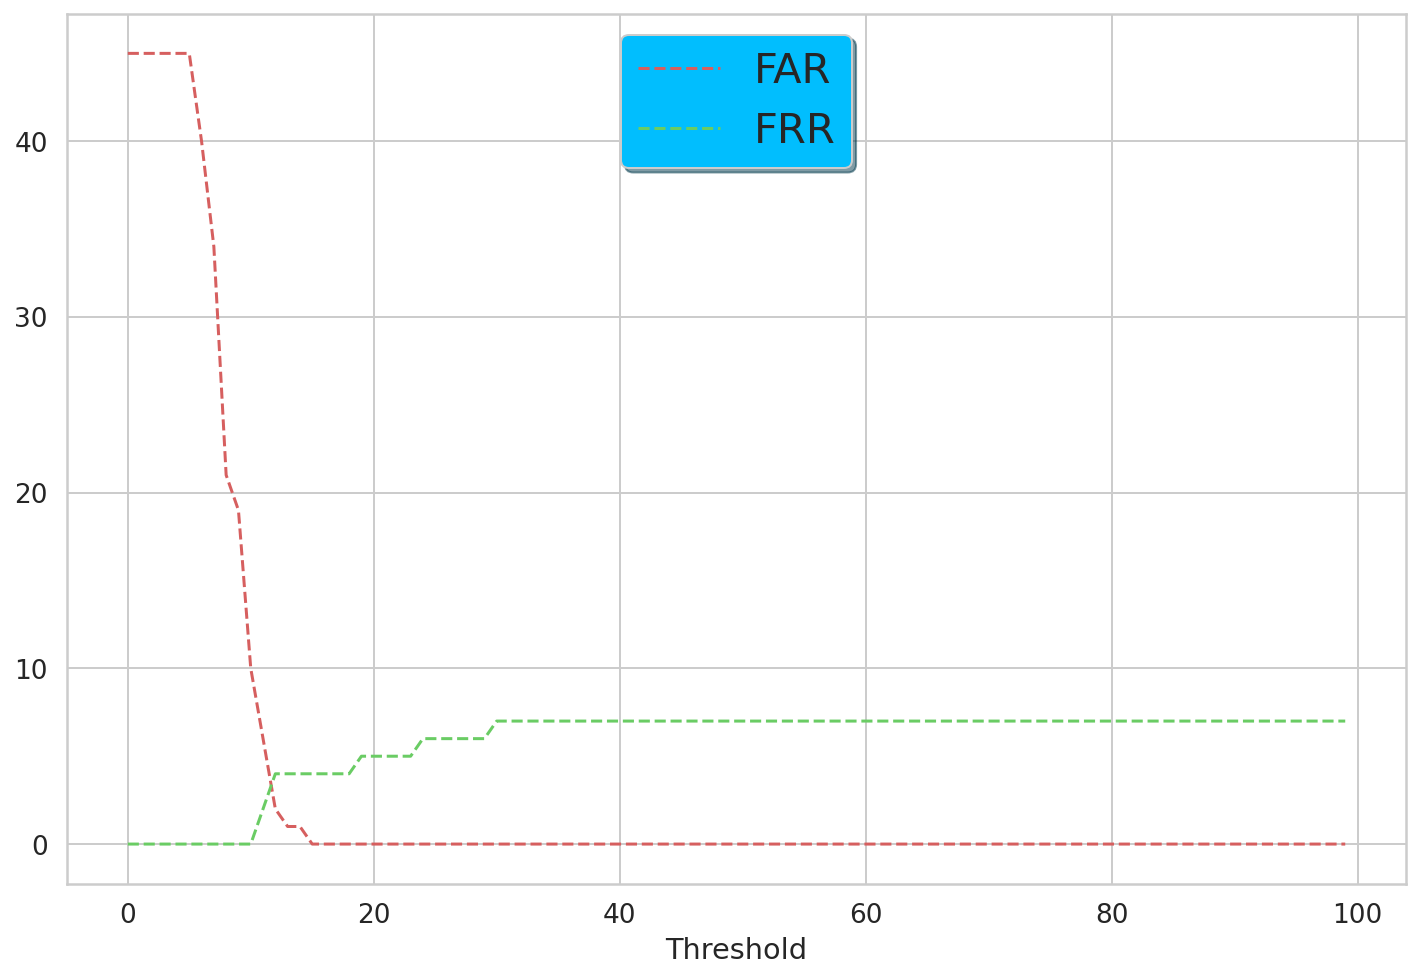

In [75]:
i = 7
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [76]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 45 0 0
1 45 0 0
2 45 0 0
3 45 0 0
4 45 0 0
5 45 0 0
6 40 0 0
7 34 0 0
8 21 0 0
9 19 0 0
10 10 0 0
11 6 2 12
12 2 4 8
13 1 4 4
14 1 4 4
15 0 4 0
16 0 4 0
17 0 4 0
18 0 4 0
19 0 5 0
20 0 5 0
21 0 5 0
22 0 5 0
23 0 5 0
24 0 6 0
25 0 6 0
26 0 6 0
27 0 6 0
28 0 6 0
29 0 6 0
30 0 7 0
31 0 7 0
32 0 7 0
33 0 7 0
34 0 7 0
35 0 7 0
36 0 7 0
37 0 7 0
38 0 7 0
39 0 7 0
40 0 7 0
41 0 7 0
42 0 7 0
43 0 7 0
44 0 7 0
45 0 7 0
46 0 7 0
47 0 7 0
48 0 7 0
49 0 7 0
50 0 7 0
51 0 7 0
52 0 7 0
53 0 7 0
54 0 7 0
55 0 7 0
56 0 7 0
57 0 7 0
58 0 7 0
59 0 7 0
60 0 7 0
61 0 7 0
62 0 7 0
63 0 7 0
64 0 7 0
65 0 7 0
66 0 7 0
67 0 7 0
68 0 7 0
69 0 7 0
70 0 7 0
71 0 7 0
72 0 7 0
73 0 7 0
74 0 7 0
75 0 7 0
76 0 7 0
77 0 7 0
78 0 7 0
79 0 7 0
80 0 7 0
81 0 7 0
82 0 7 0
83 0 7 0
84 0 7 0
85 0 7 0
86 0 7 0
87 0 7 0
88 0 7 0
89 0 7 0
90 0 7 0
91 0 7 0
92 0 7 0
93 0 7 0
94 0 7 0
95 0 7 0
96 0 7 0
97 0 7 0
98 0 7 0
99 0 7 0


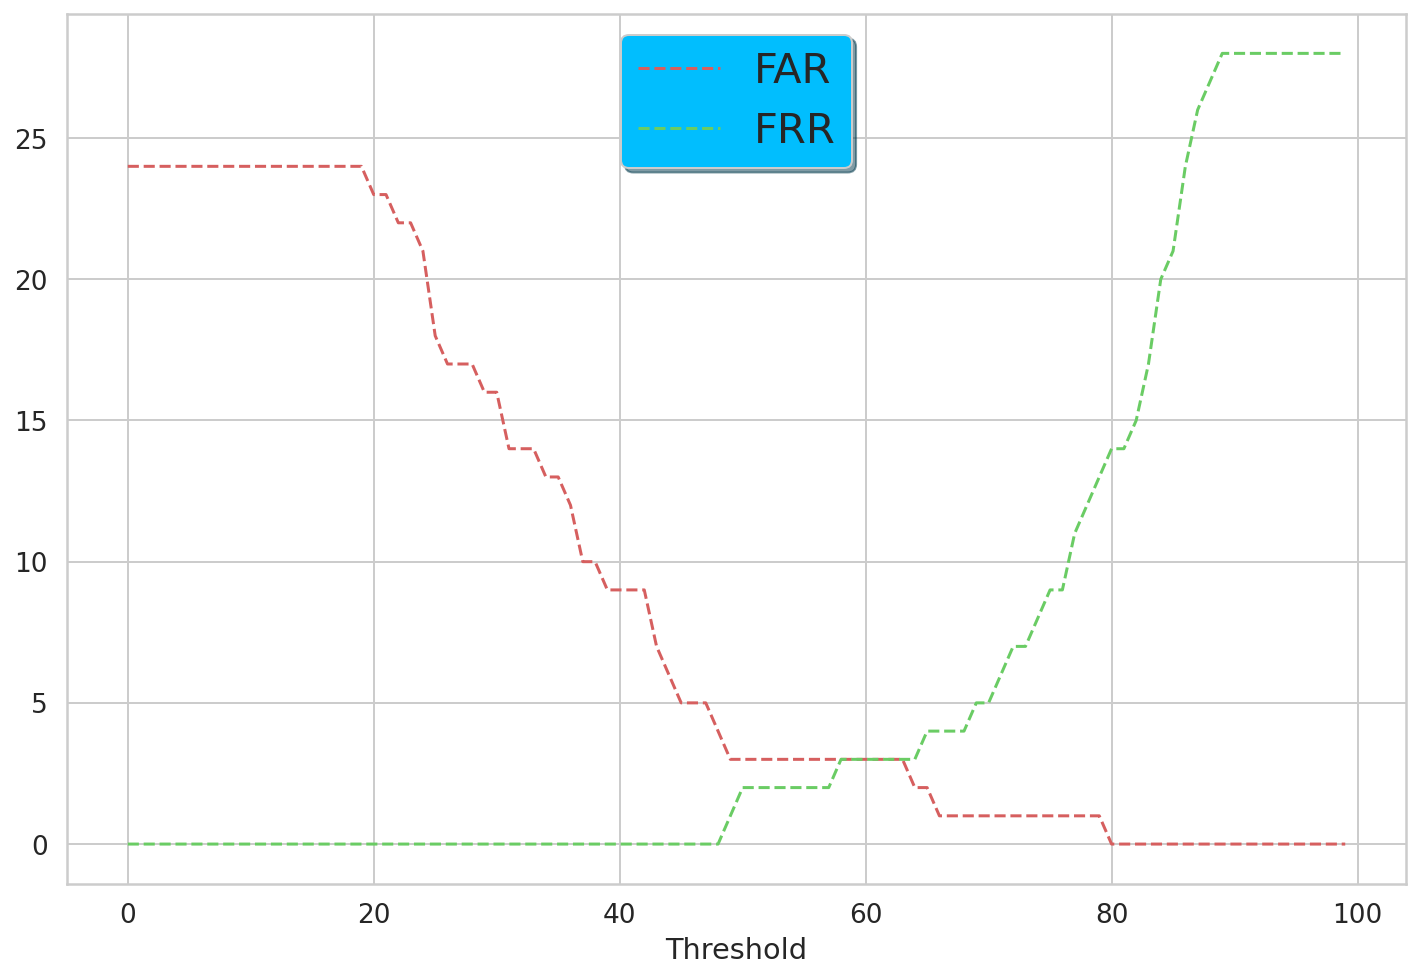

In [77]:
i = 8
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [78]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 24 0 0
1 24 0 0
2 24 0 0
3 24 0 0
4 24 0 0
5 24 0 0
6 24 0 0
7 24 0 0
8 24 0 0
9 24 0 0
10 24 0 0
11 24 0 0
12 24 0 0
13 24 0 0
14 24 0 0
15 24 0 0
16 24 0 0
17 24 0 0
18 24 0 0
19 24 0 0
20 23 0 0
21 23 0 0
22 22 0 0
23 22 0 0
24 21 0 0
25 18 0 0
26 17 0 0
27 17 0 0
28 17 0 0
29 16 0 0
30 16 0 0
31 14 0 0
32 14 0 0
33 14 0 0
34 13 0 0
35 13 0 0
36 12 0 0
37 10 0 0
38 10 0 0
39 9 0 0
40 9 0 0
41 9 0 0
42 9 0 0
43 7 0 0
44 6 0 0
45 5 0 0
46 5 0 0
47 5 0 0
48 4 0 0
49 3 1 3
50 3 2 6
51 3 2 6
52 3 2 6
53 3 2 6
54 3 2 6
55 3 2 6
56 3 2 6
57 3 2 6
58 3 3 9
59 3 3 9
60 3 3 9
61 3 3 9
62 3 3 9
63 3 3 9
64 2 3 6
65 2 4 8
66 1 4 4
67 1 4 4
68 1 4 4
69 1 5 5
70 1 5 5
71 1 6 6
72 1 7 7
73 1 7 7
74 1 8 8
75 1 9 9
76 1 9 9
77 1 11 11
78 1 12 12
79 1 13 13
80 0 14 0
81 0 14 0
82 0 15 0
83 0 17 0
84 0 20 0
85 0 21 0
86 0 24 0
87 0 26 0
88 0 27 0
89 0 28 0
90 0 28 0
91 0 28 0
92 0 28 0
93 0 28 0
94 0 28 0
95 0 28 0
96 0 28 0
97 0 28 0
98 0 28 0
99 0 28 0


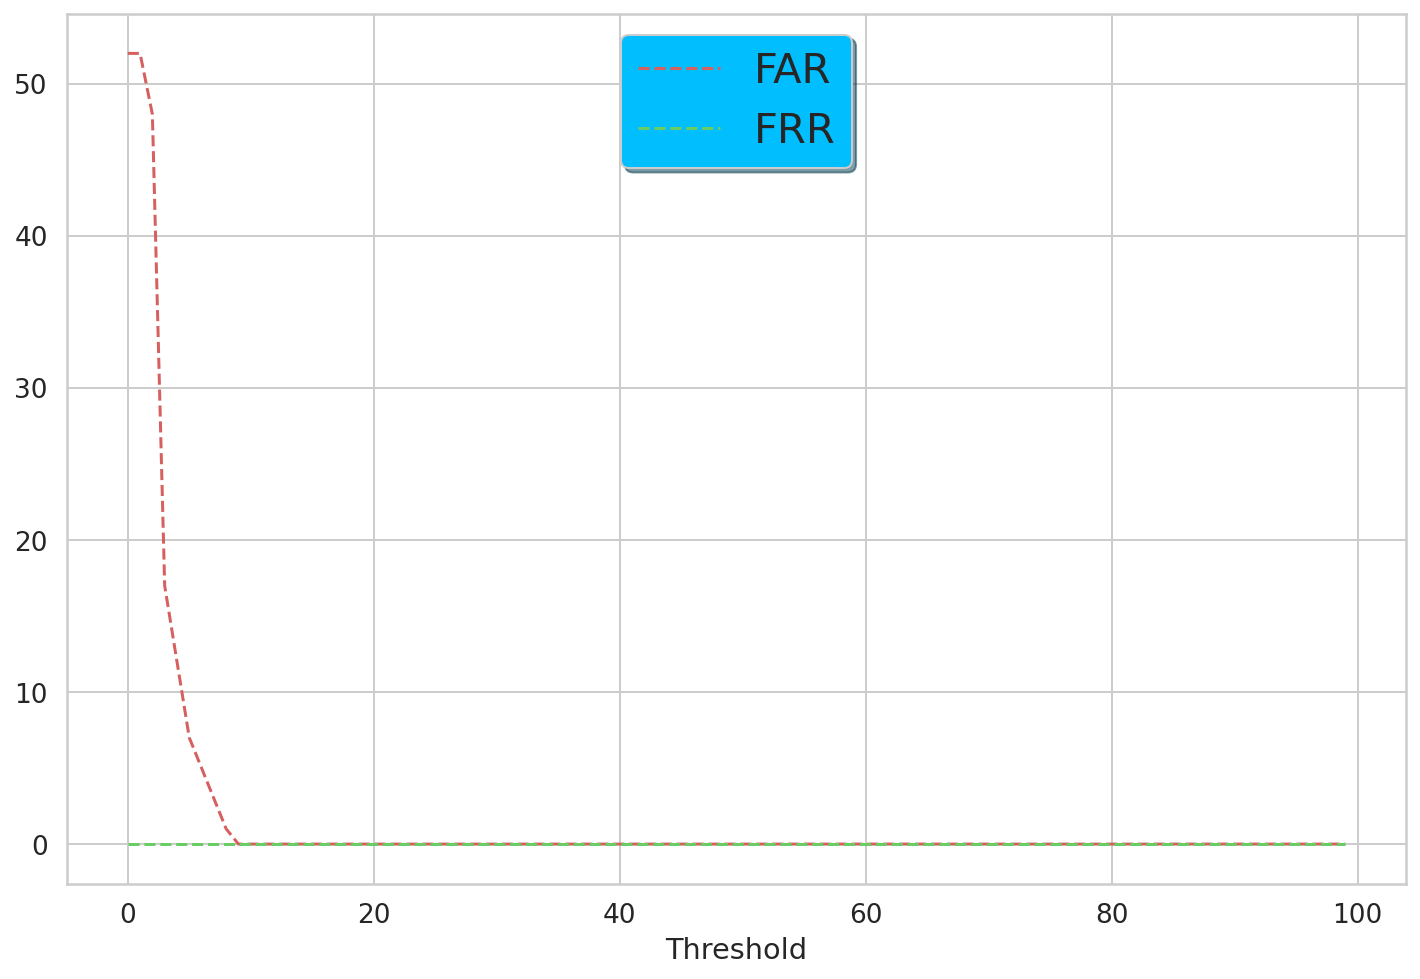

In [79]:
i = 9
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [80]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 52 0 0
1 52 0 0
2 48 0 0
3 17 0 0
4 12 0 0
5 7 0 0
6 5 0 0
7 3 0 0
8 1 0 0
9 0 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 0 0 0
50 0 0 0
51 0 0 0
52 0 0 0
53 0 0 0
54 0 0 0
55 0 0 0
56 0 0 0
57 0 0 0
58 0 0 0
59 0 0 0
60 0 0 0
61 0 0 0
62 0 0 0
63 0 0 0
64 0 0 0
65 0 0 0
66 0 0 0
67 0 0 0
68 0 0 0
69 0 0 0
70 0 0 0
71 0 0 0
72 0 0 0
73 0 0 0
74 0 0 0
75 0 0 0
76 0 0 0
77 0 0 0
78 0 0 0
79 0 0 0
80 0 0 0
81 0 0 0
82 0 0 0
83 0 0 0
84 0 0 0
85 0 0 0
86 0 0 0
87 0 0 0
88 0 0 0
89 0 0 0
90 0 0 0
91 0 0 0
92 0 0 0
93 0 0 0
94 0 0 0
95 0 0 0
96 0 0 0
97 0 0 0
98 0 0 0
99 0 0 0


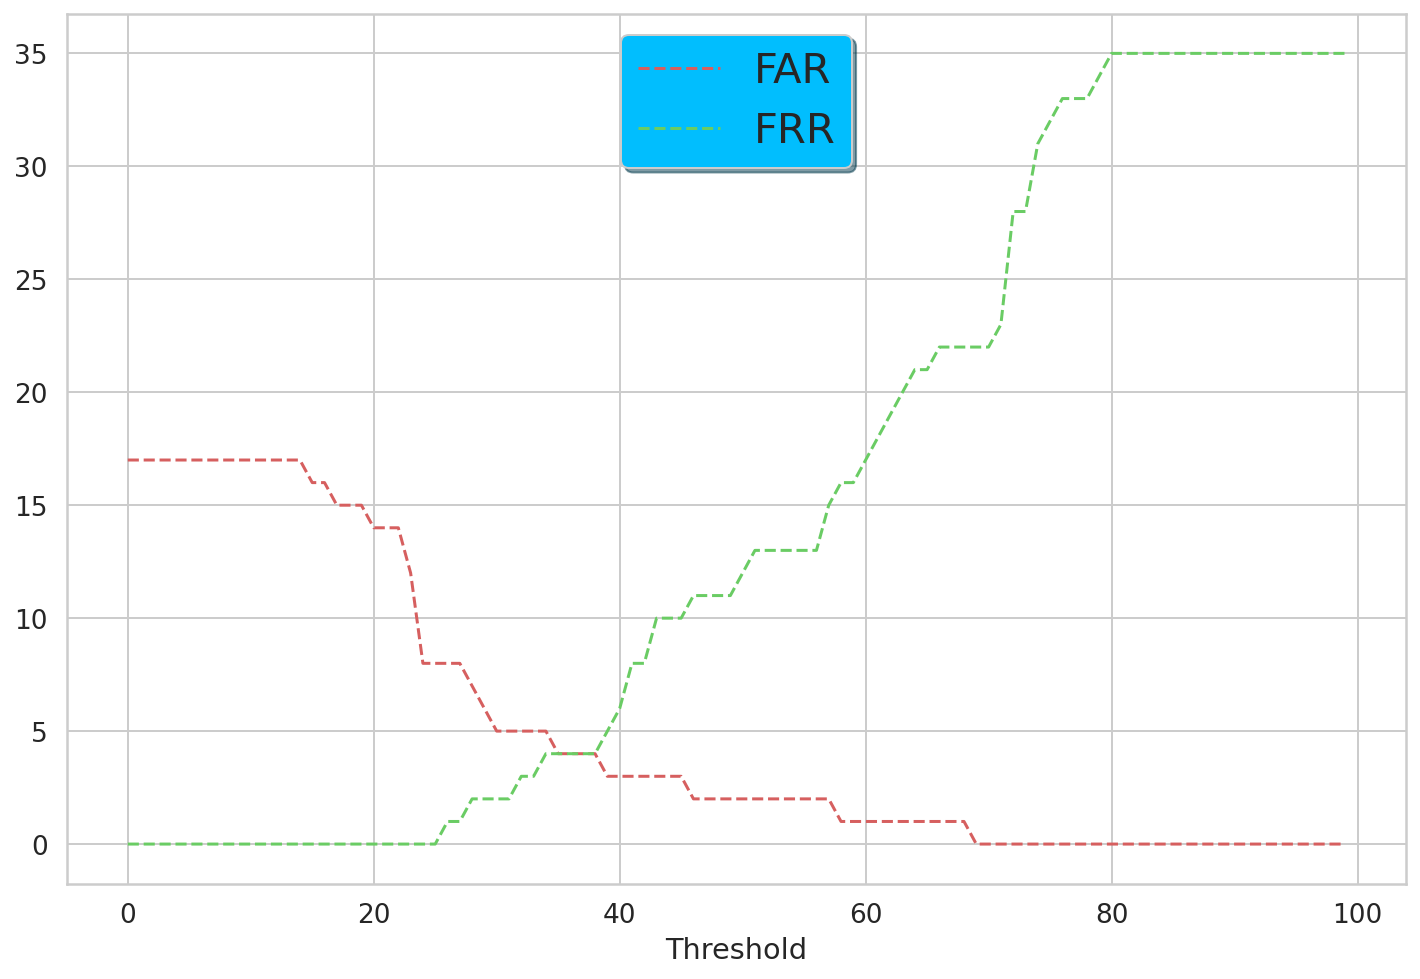

In [81]:
i = 10
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [82]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 17 0 0
1 17 0 0
2 17 0 0
3 17 0 0
4 17 0 0
5 17 0 0
6 17 0 0
7 17 0 0
8 17 0 0
9 17 0 0
10 17 0 0
11 17 0 0
12 17 0 0
13 17 0 0
14 17 0 0
15 16 0 0
16 16 0 0
17 15 0 0
18 15 0 0
19 15 0 0
20 14 0 0
21 14 0 0
22 14 0 0
23 12 0 0
24 8 0 0
25 8 0 0
26 8 1 8
27 8 1 8
28 7 2 14
29 6 2 12
30 5 2 10
31 5 2 10
32 5 3 15
33 5 3 15
34 5 4 20
35 4 4 16
36 4 4 16
37 4 4 16
38 4 4 16
39 3 5 15
40 3 6 18
41 3 8 24
42 3 8 24
43 3 10 30
44 3 10 30
45 3 10 30
46 2 11 22
47 2 11 22
48 2 11 22
49 2 11 22
50 2 12 24
51 2 13 26
52 2 13 26
53 2 13 26
54 2 13 26
55 2 13 26
56 2 13 26
57 2 15 30
58 1 16 16
59 1 16 16
60 1 17 17
61 1 18 18
62 1 19 19
63 1 20 20
64 1 21 21
65 1 21 21
66 1 22 22
67 1 22 22
68 1 22 22
69 0 22 0
70 0 22 0
71 0 23 0
72 0 28 0
73 0 28 0
74 0 31 0
75 0 32 0
76 0 33 0
77 0 33 0
78 0 33 0
79 0 34 0
80 0 35 0
81 0 35 0
82 0 35 0
83 0 35 0
84 0 35 0
85 0 35 0
86 0 35 0
87 0 35 0
88 0 35 0
89 0 35 0
90 0 35 0
91 0 35 0
92 0 35 0
93 0 35 0
94 0 35 0
95 0 35 0
96 0 35 0
97 0 35 0
98 0 35 

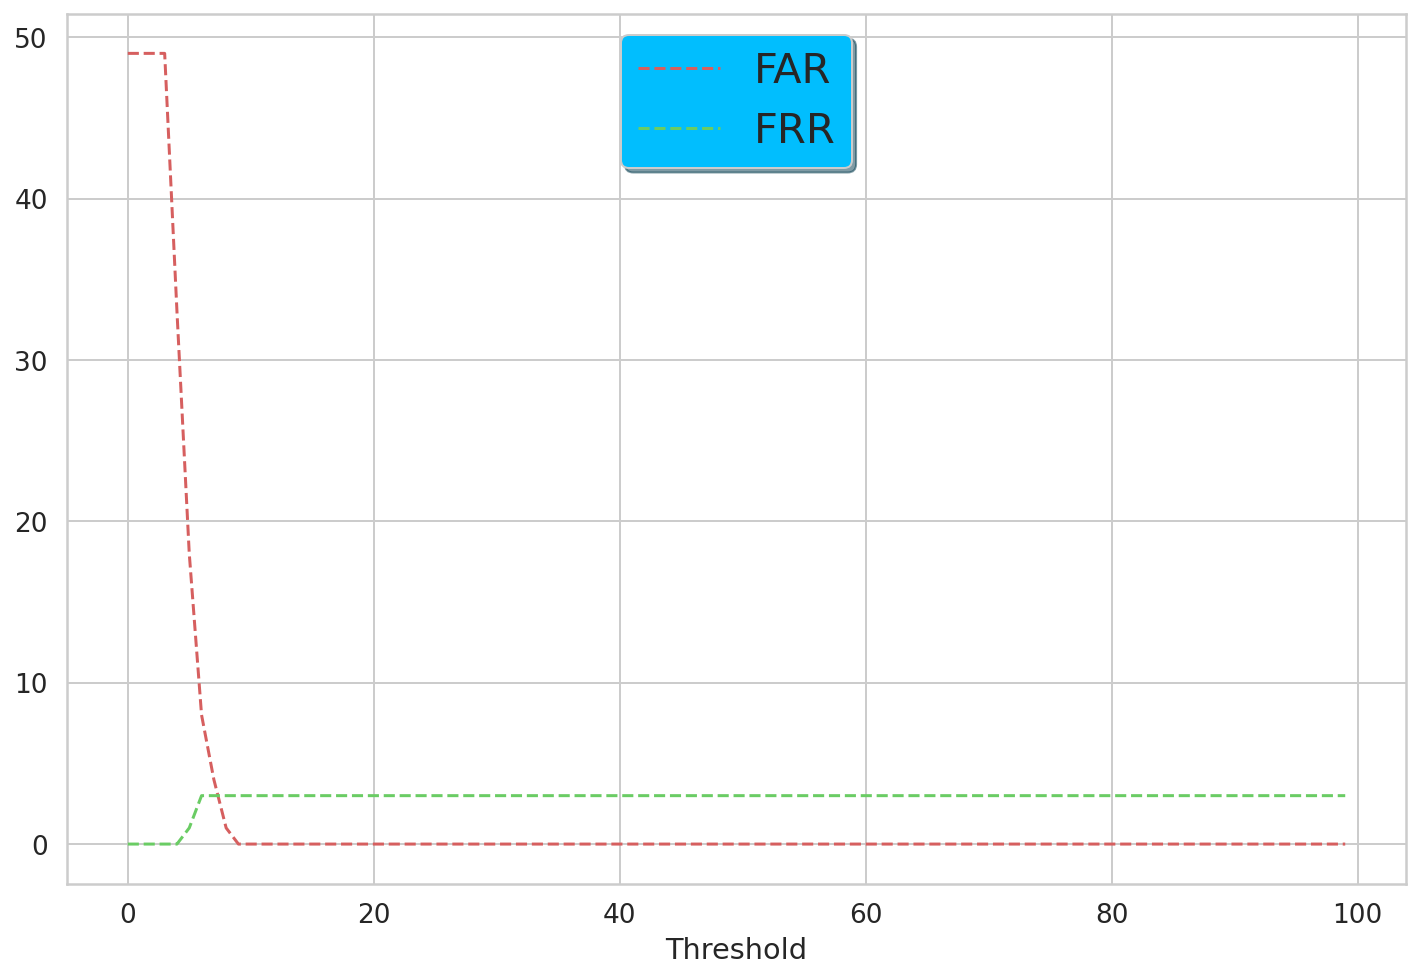

In [83]:
i =11
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [84]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 49 0 0
1 49 0 0
2 49 0 0
3 49 0 0
4 33 0 0
5 18 1 18
6 8 3 24
7 4 3 12
8 1 3 3
9 0 3 0
10 0 3 0
11 0 3 0
12 0 3 0
13 0 3 0
14 0 3 0
15 0 3 0
16 0 3 0
17 0 3 0
18 0 3 0
19 0 3 0
20 0 3 0
21 0 3 0
22 0 3 0
23 0 3 0
24 0 3 0
25 0 3 0
26 0 3 0
27 0 3 0
28 0 3 0
29 0 3 0
30 0 3 0
31 0 3 0
32 0 3 0
33 0 3 0
34 0 3 0
35 0 3 0
36 0 3 0
37 0 3 0
38 0 3 0
39 0 3 0
40 0 3 0
41 0 3 0
42 0 3 0
43 0 3 0
44 0 3 0
45 0 3 0
46 0 3 0
47 0 3 0
48 0 3 0
49 0 3 0
50 0 3 0
51 0 3 0
52 0 3 0
53 0 3 0
54 0 3 0
55 0 3 0
56 0 3 0
57 0 3 0
58 0 3 0
59 0 3 0
60 0 3 0
61 0 3 0
62 0 3 0
63 0 3 0
64 0 3 0
65 0 3 0
66 0 3 0
67 0 3 0
68 0 3 0
69 0 3 0
70 0 3 0
71 0 3 0
72 0 3 0
73 0 3 0
74 0 3 0
75 0 3 0
76 0 3 0
77 0 3 0
78 0 3 0
79 0 3 0
80 0 3 0
81 0 3 0
82 0 3 0
83 0 3 0
84 0 3 0
85 0 3 0
86 0 3 0
87 0 3 0
88 0 3 0
89 0 3 0
90 0 3 0
91 0 3 0
92 0 3 0
93 0 3 0
94 0 3 0
95 0 3 0
96 0 3 0
97 0 3 0
98 0 3 0
99 0 3 0


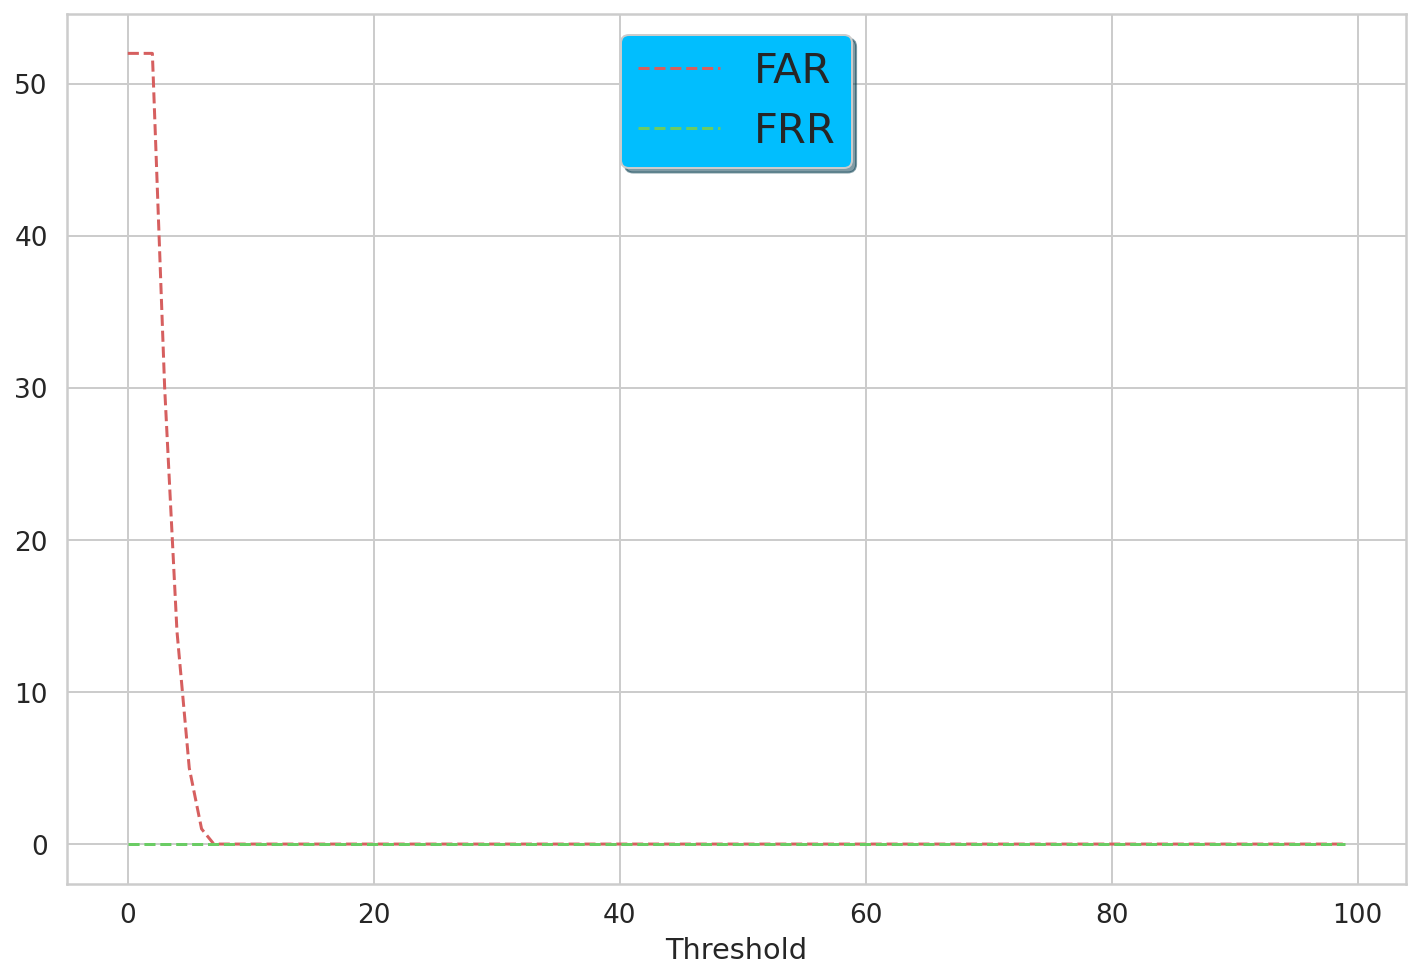

In [85]:
i = 12
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [86]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 52 0 0
1 52 0 0
2 52 0 0
3 30 0 0
4 14 0 0
5 5 0 0
6 1 0 0
7 0 0 0
8 0 0 0
9 0 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 0 0 0
50 0 0 0
51 0 0 0
52 0 0 0
53 0 0 0
54 0 0 0
55 0 0 0
56 0 0 0
57 0 0 0
58 0 0 0
59 0 0 0
60 0 0 0
61 0 0 0
62 0 0 0
63 0 0 0
64 0 0 0
65 0 0 0
66 0 0 0
67 0 0 0
68 0 0 0
69 0 0 0
70 0 0 0
71 0 0 0
72 0 0 0
73 0 0 0
74 0 0 0
75 0 0 0
76 0 0 0
77 0 0 0
78 0 0 0
79 0 0 0
80 0 0 0
81 0 0 0
82 0 0 0
83 0 0 0
84 0 0 0
85 0 0 0
86 0 0 0
87 0 0 0
88 0 0 0
89 0 0 0
90 0 0 0
91 0 0 0
92 0 0 0
93 0 0 0
94 0 0 0
95 0 0 0
96 0 0 0
97 0 0 0
98 0 0 0
99 0 0 0


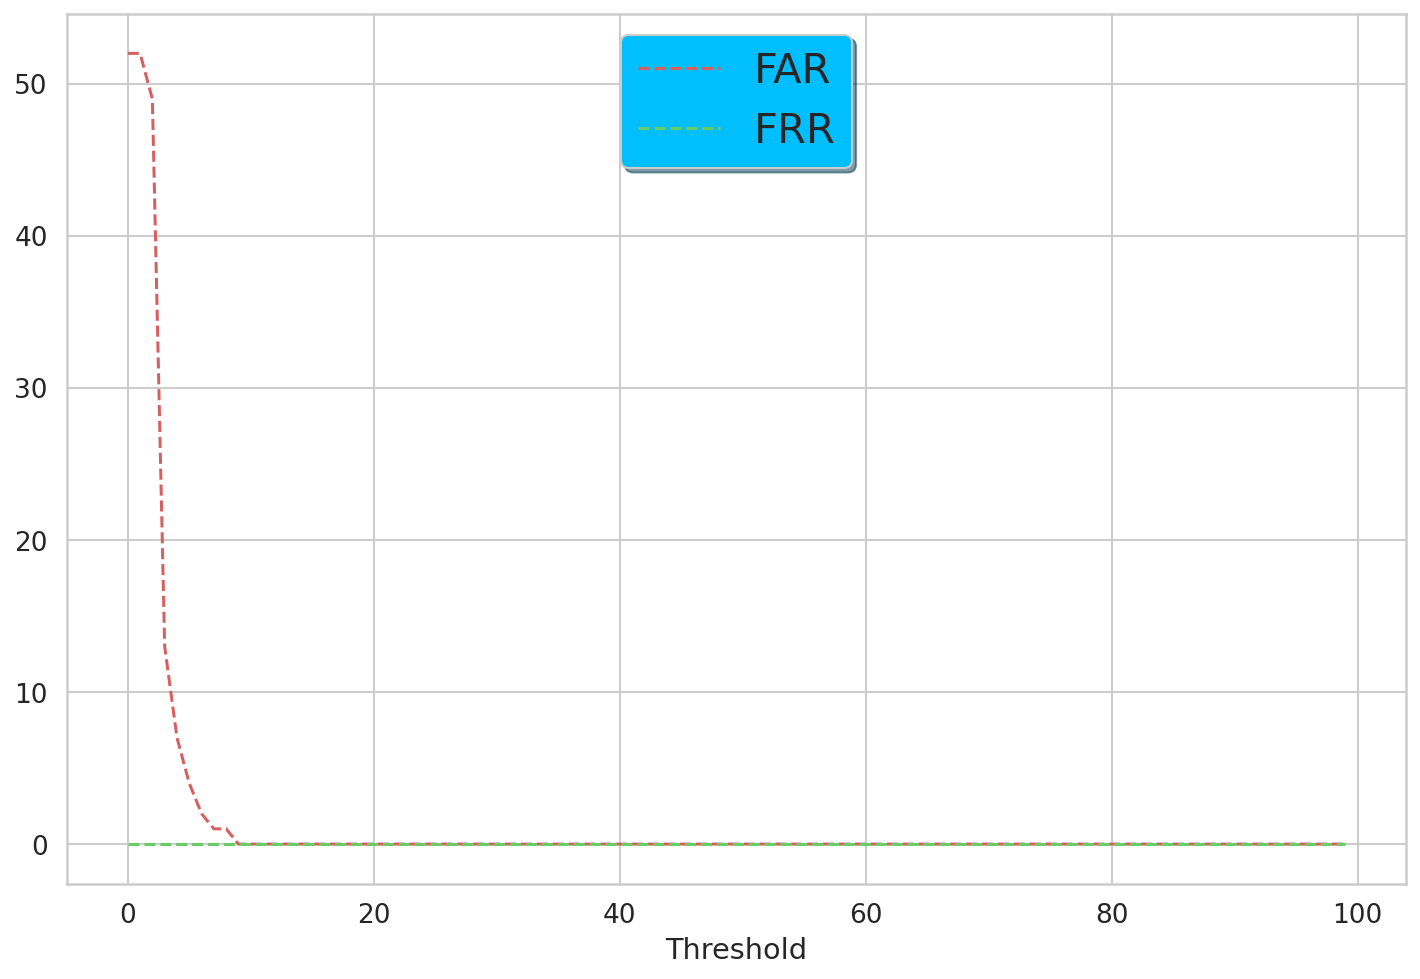

In [87]:
i = 13
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [88]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 52 0 0
1 52 0 0
2 49 0 0
3 13 0 0
4 7 0 0
5 4 0 0
6 2 0 0
7 1 0 0
8 1 0 0
9 0 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 0 0
14 0 0 0
15 0 0 0
16 0 0 0
17 0 0 0
18 0 0 0
19 0 0 0
20 0 0 0
21 0 0 0
22 0 0 0
23 0 0 0
24 0 0 0
25 0 0 0
26 0 0 0
27 0 0 0
28 0 0 0
29 0 0 0
30 0 0 0
31 0 0 0
32 0 0 0
33 0 0 0
34 0 0 0
35 0 0 0
36 0 0 0
37 0 0 0
38 0 0 0
39 0 0 0
40 0 0 0
41 0 0 0
42 0 0 0
43 0 0 0
44 0 0 0
45 0 0 0
46 0 0 0
47 0 0 0
48 0 0 0
49 0 0 0
50 0 0 0
51 0 0 0
52 0 0 0
53 0 0 0
54 0 0 0
55 0 0 0
56 0 0 0
57 0 0 0
58 0 0 0
59 0 0 0
60 0 0 0
61 0 0 0
62 0 0 0
63 0 0 0
64 0 0 0
65 0 0 0
66 0 0 0
67 0 0 0
68 0 0 0
69 0 0 0
70 0 0 0
71 0 0 0
72 0 0 0
73 0 0 0
74 0 0 0
75 0 0 0
76 0 0 0
77 0 0 0
78 0 0 0
79 0 0 0
80 0 0 0
81 0 0 0
82 0 0 0
83 0 0 0
84 0 0 0
85 0 0 0
86 0 0 0
87 0 0 0
88 0 0 0
89 0 0 0
90 0 0 0
91 0 0 0
92 0 0 0
93 0 0 0
94 0 0 0
95 0 0 0
96 0 0 0
97 0 0 0
98 0 0 0
99 0 0 0


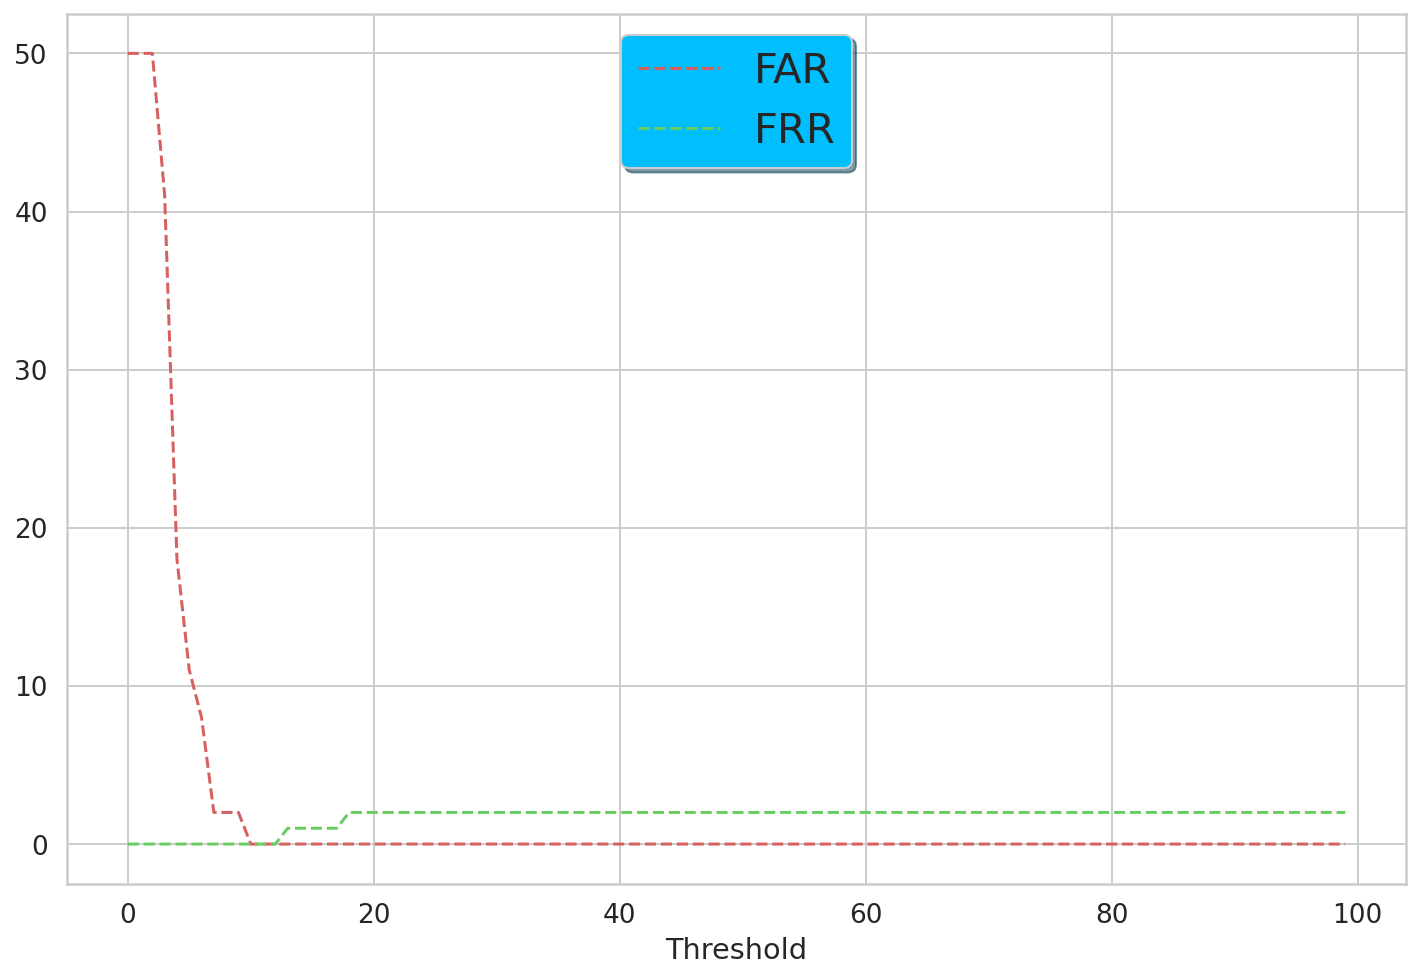

In [89]:
i = 14
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [90]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 50 0 0
1 50 0 0
2 50 0 0
3 41 0 0
4 18 0 0
5 11 0 0
6 8 0 0
7 2 0 0
8 2 0 0
9 2 0 0
10 0 0 0
11 0 0 0
12 0 0 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 2 0
19 0 2 0
20 0 2 0
21 0 2 0
22 0 2 0
23 0 2 0
24 0 2 0
25 0 2 0
26 0 2 0
27 0 2 0
28 0 2 0
29 0 2 0
30 0 2 0
31 0 2 0
32 0 2 0
33 0 2 0
34 0 2 0
35 0 2 0
36 0 2 0
37 0 2 0
38 0 2 0
39 0 2 0
40 0 2 0
41 0 2 0
42 0 2 0
43 0 2 0
44 0 2 0
45 0 2 0
46 0 2 0
47 0 2 0
48 0 2 0
49 0 2 0
50 0 2 0
51 0 2 0
52 0 2 0
53 0 2 0
54 0 2 0
55 0 2 0
56 0 2 0
57 0 2 0
58 0 2 0
59 0 2 0
60 0 2 0
61 0 2 0
62 0 2 0
63 0 2 0
64 0 2 0
65 0 2 0
66 0 2 0
67 0 2 0
68 0 2 0
69 0 2 0
70 0 2 0
71 0 2 0
72 0 2 0
73 0 2 0
74 0 2 0
75 0 2 0
76 0 2 0
77 0 2 0
78 0 2 0
79 0 2 0
80 0 2 0
81 0 2 0
82 0 2 0
83 0 2 0
84 0 2 0
85 0 2 0
86 0 2 0
87 0 2 0
88 0 2 0
89 0 2 0
90 0 2 0
91 0 2 0
92 0 2 0
93 0 2 0
94 0 2 0
95 0 2 0
96 0 2 0
97 0 2 0
98 0 2 0
99 0 2 0


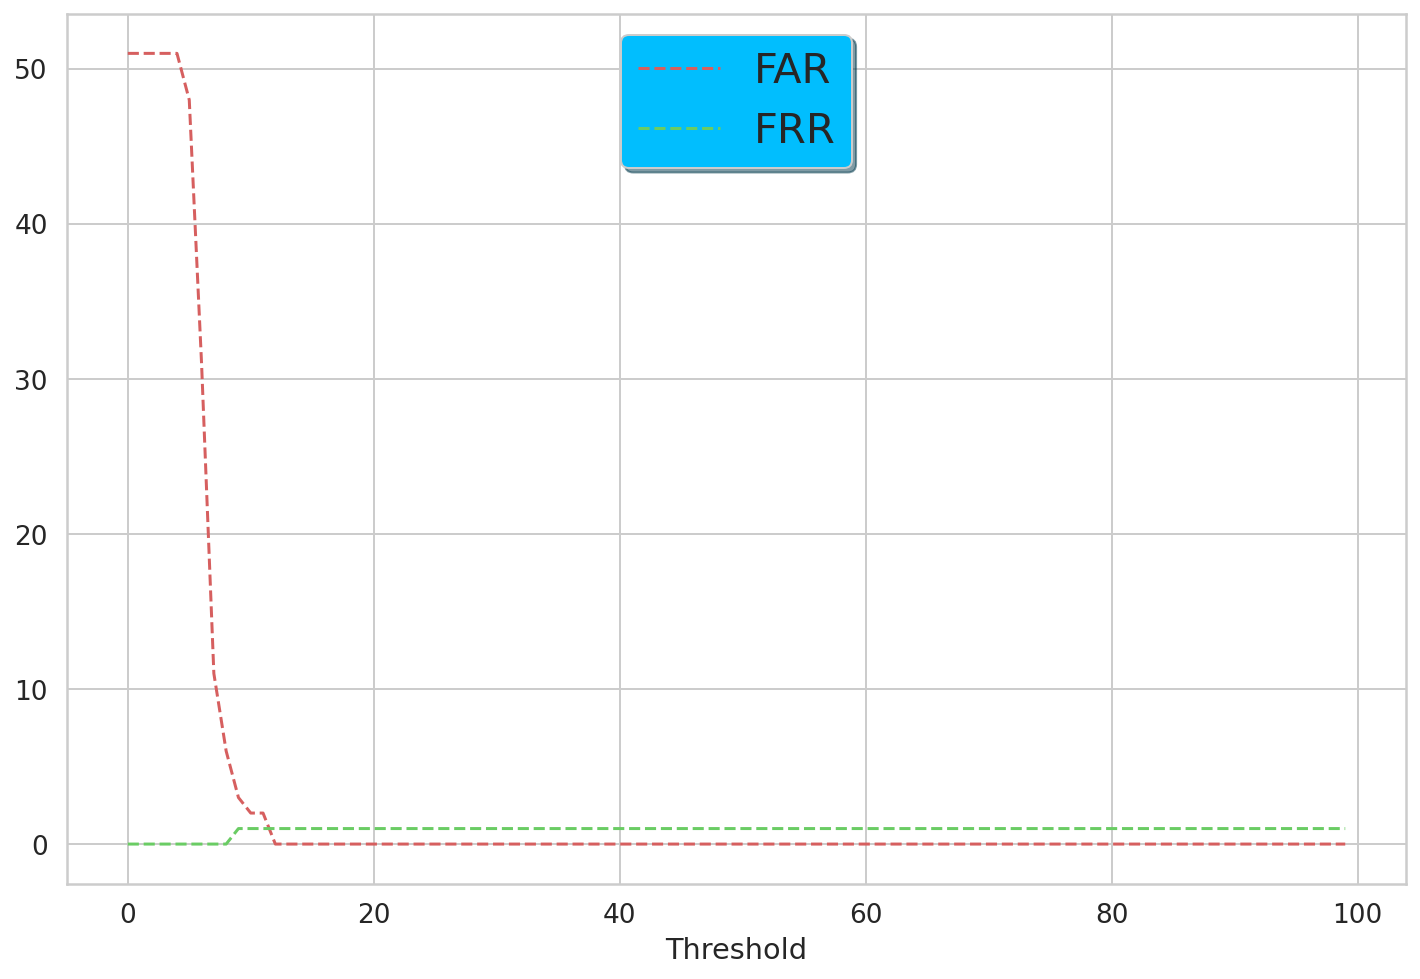

In [91]:
i = 15
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [92]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 51 0 0
3 51 0 0
4 51 0 0
5 48 0 0
6 31 0 0
7 11 0 0
8 6 0 0
9 3 1 3
10 2 1 2
11 2 1 2
12 0 1 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


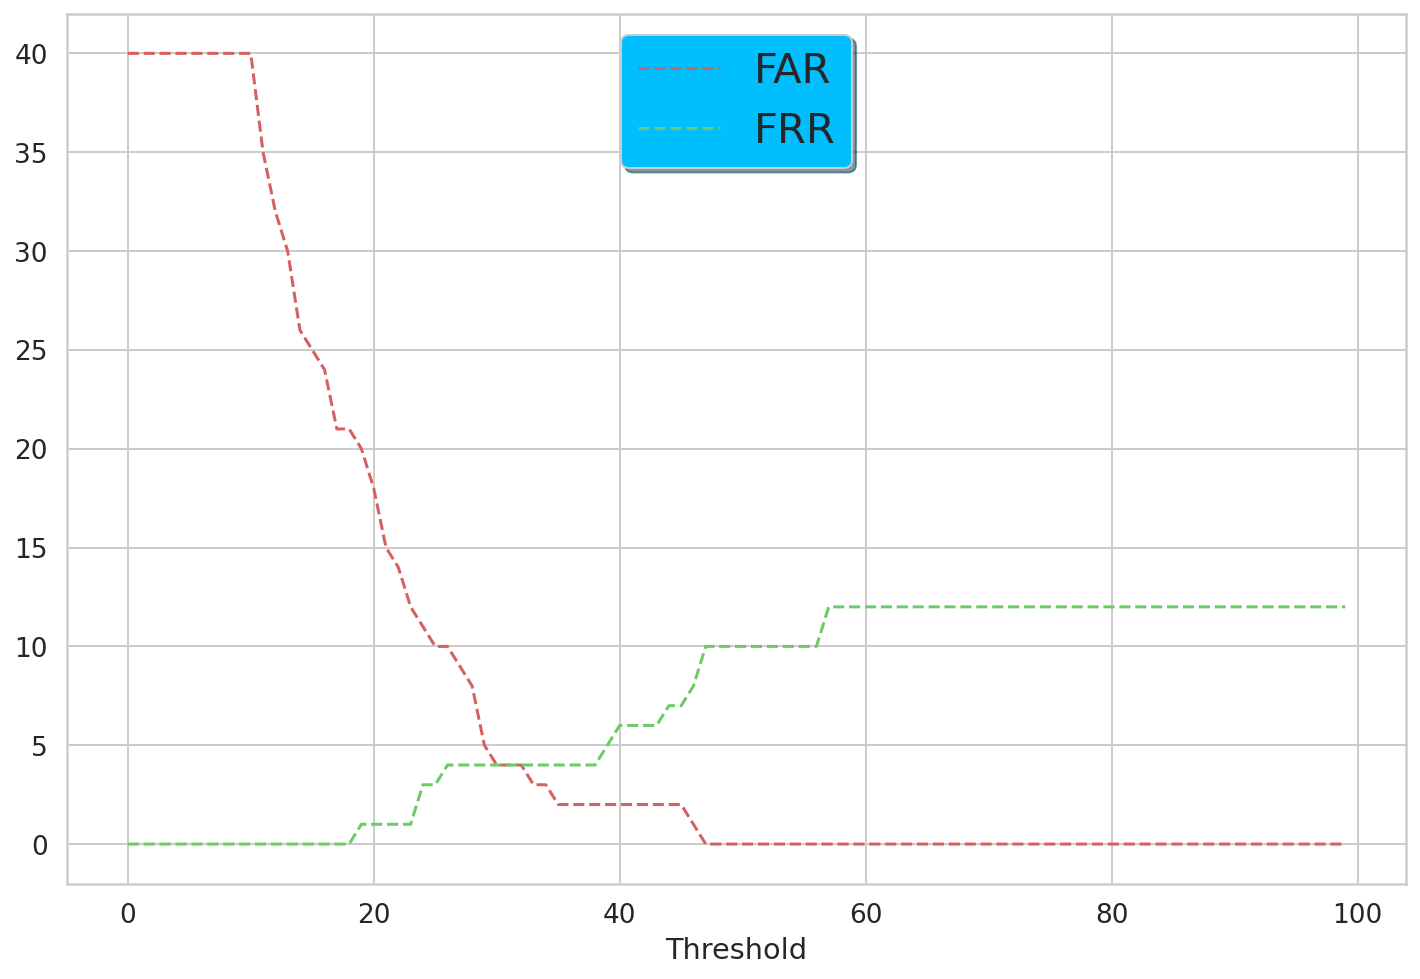

In [93]:
i = 16
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [94]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 40 0 0
1 40 0 0
2 40 0 0
3 40 0 0
4 40 0 0
5 40 0 0
6 40 0 0
7 40 0 0
8 40 0 0
9 40 0 0
10 40 0 0
11 35 0 0
12 32 0 0
13 30 0 0
14 26 0 0
15 25 0 0
16 24 0 0
17 21 0 0
18 21 0 0
19 20 1 20
20 18 1 18
21 15 1 15
22 14 1 14
23 12 1 12
24 11 3 33
25 10 3 30
26 10 4 40
27 9 4 36
28 8 4 32
29 5 4 20
30 4 4 16
31 4 4 16
32 4 4 16
33 3 4 12
34 3 4 12
35 2 4 8
36 2 4 8
37 2 4 8
38 2 4 8
39 2 5 10
40 2 6 12
41 2 6 12
42 2 6 12
43 2 6 12
44 2 7 14
45 2 7 14
46 1 8 8
47 0 10 0
48 0 10 0
49 0 10 0
50 0 10 0
51 0 10 0
52 0 10 0
53 0 10 0
54 0 10 0
55 0 10 0
56 0 10 0
57 0 12 0
58 0 12 0
59 0 12 0
60 0 12 0
61 0 12 0
62 0 12 0
63 0 12 0
64 0 12 0
65 0 12 0
66 0 12 0
67 0 12 0
68 0 12 0
69 0 12 0
70 0 12 0
71 0 12 0
72 0 12 0
73 0 12 0
74 0 12 0
75 0 12 0
76 0 12 0
77 0 12 0
78 0 12 0
79 0 12 0
80 0 12 0
81 0 12 0
82 0 12 0
83 0 12 0
84 0 12 0
85 0 12 0
86 0 12 0
87 0 12 0
88 0 12 0
89 0 12 0
90 0 12 0
91 0 12 0
92 0 12 0
93 0 12 0
94 0 12 0
95 0 12 0
96 0 12 0
97 0 12 0
98 0 12 0
99 0 12 0


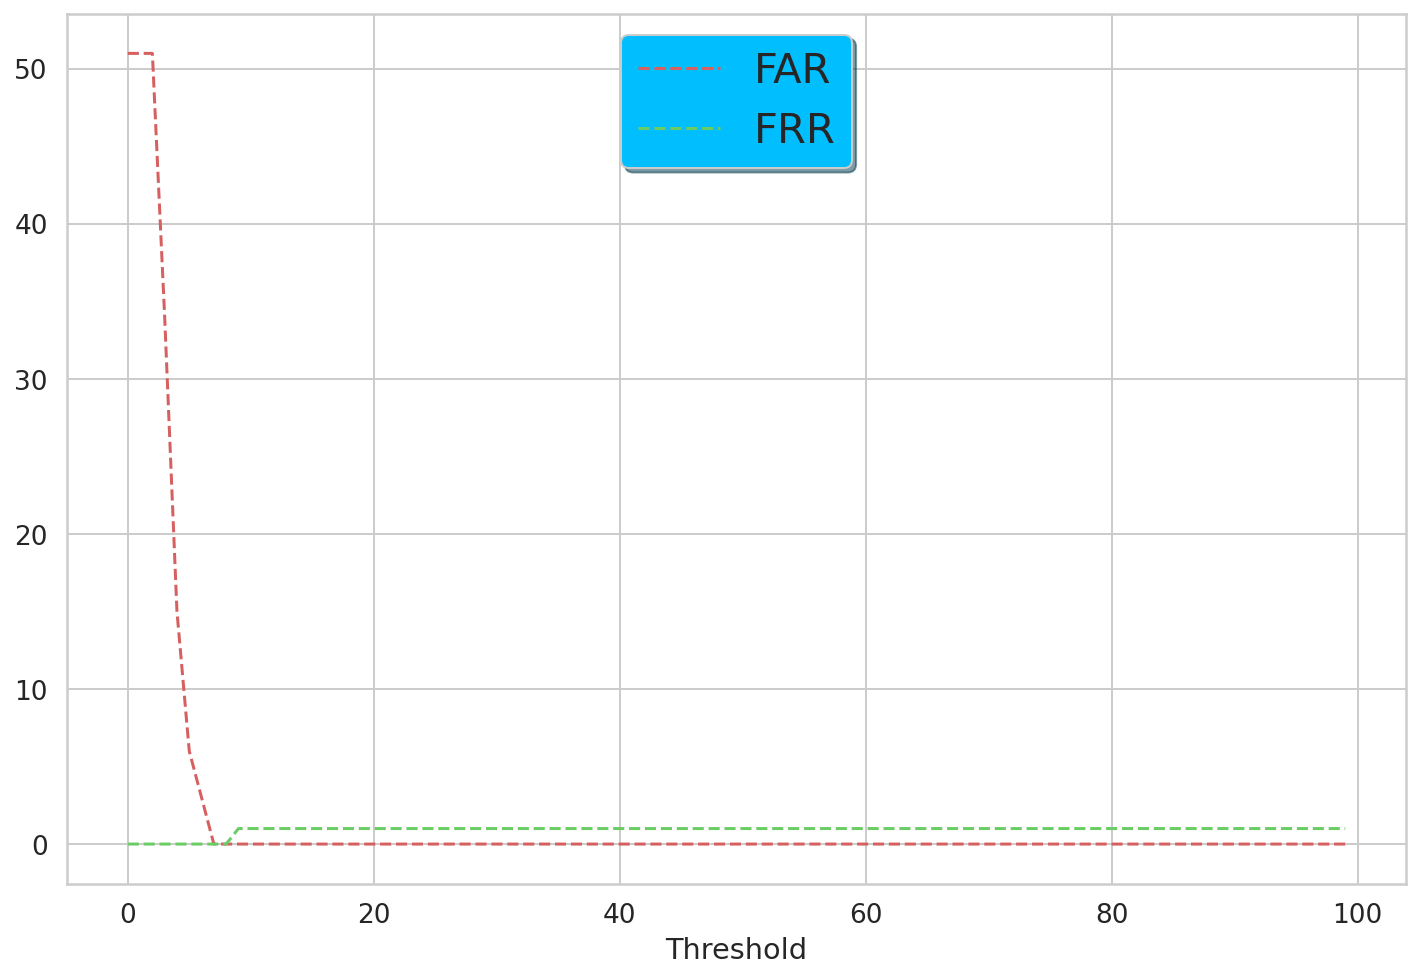

In [95]:
i = 17
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [96]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 51 0 0
3 34 0 0
4 15 0 0
5 6 0 0
6 3 0 0
7 0 0 0
8 0 0 0
9 0 1 0
10 0 1 0
11 0 1 0
12 0 1 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


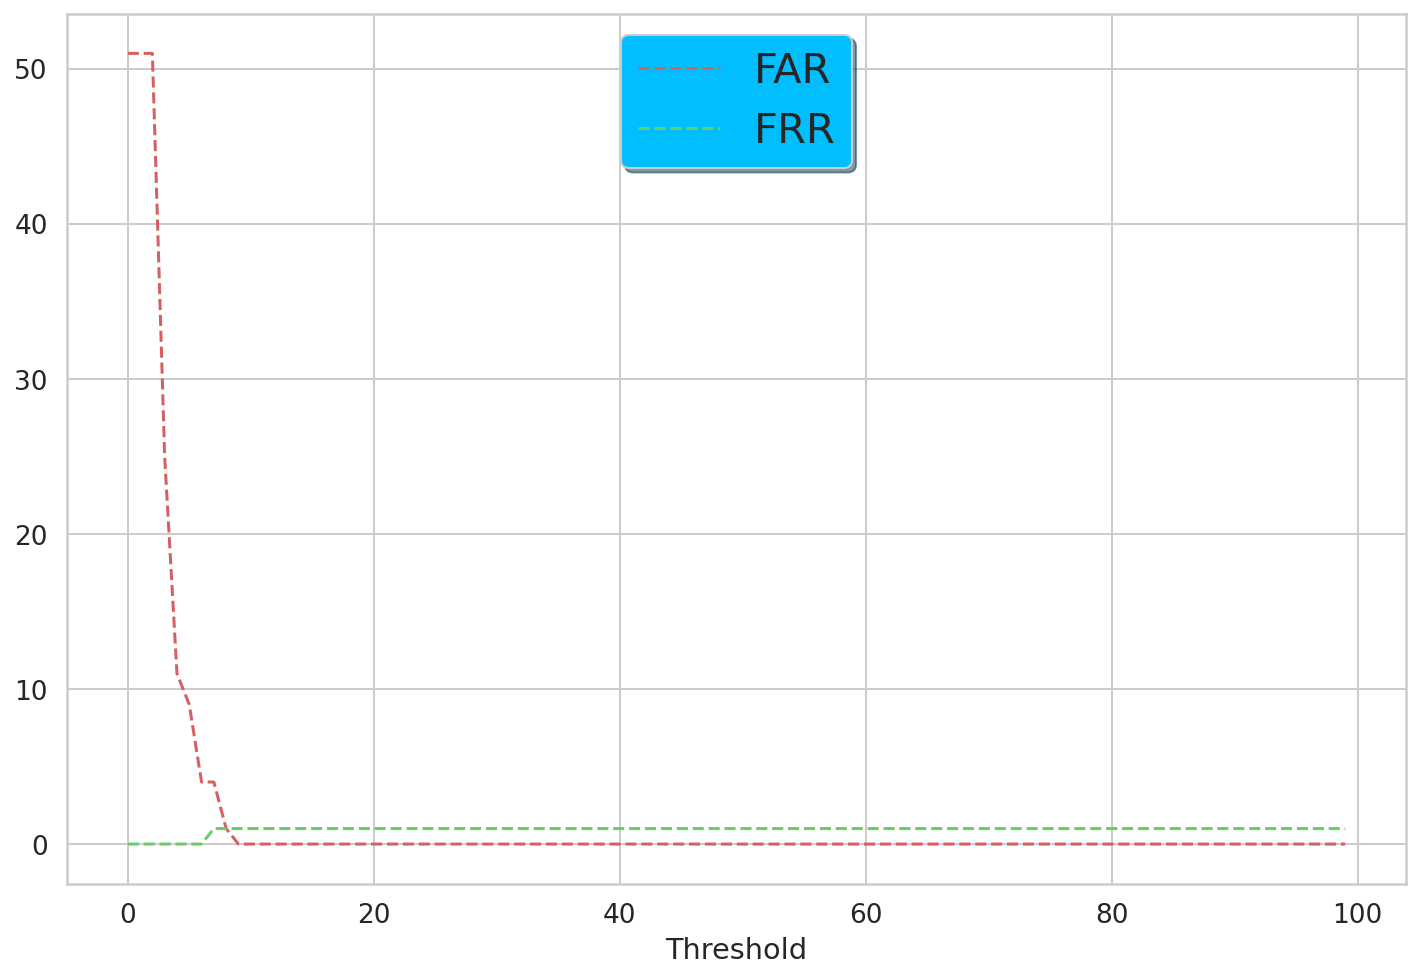

In [97]:
i = 18
labels = dev_df[propaganda_techniques_names[i]].to_list()
scores = [s[i] for s in scoress]

far = []
threshold = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)>i and l ==0:
            num+=1
    #print(i,num)
    far.append(num)
    threshold.append(i)

far = np.array(far)

frr = []
for i in range(100):
    num = 0

    for s,l in zip(scores,labels):
        if (s*100)<i and l ==1:
            num+=1
    #print(i,num)
    frr.append(num)


frr = np.array(frr)


fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
# plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [98]:
for i, v in enumerate(zip(far,frr)):
    print(i,v[0],v[1],v[0]*v[1])
    

0 51 0 0
1 51 0 0
2 51 0 0
3 25 0 0
4 11 0 0
5 9 0 0
6 4 0 0
7 4 1 4
8 1 1 1
9 0 1 0
10 0 1 0
11 0 1 0
12 0 1 0
13 0 1 0
14 0 1 0
15 0 1 0
16 0 1 0
17 0 1 0
18 0 1 0
19 0 1 0
20 0 1 0
21 0 1 0
22 0 1 0
23 0 1 0
24 0 1 0
25 0 1 0
26 0 1 0
27 0 1 0
28 0 1 0
29 0 1 0
30 0 1 0
31 0 1 0
32 0 1 0
33 0 1 0
34 0 1 0
35 0 1 0
36 0 1 0
37 0 1 0
38 0 1 0
39 0 1 0
40 0 1 0
41 0 1 0
42 0 1 0
43 0 1 0
44 0 1 0
45 0 1 0
46 0 1 0
47 0 1 0
48 0 1 0
49 0 1 0
50 0 1 0
51 0 1 0
52 0 1 0
53 0 1 0
54 0 1 0
55 0 1 0
56 0 1 0
57 0 1 0
58 0 1 0
59 0 1 0
60 0 1 0
61 0 1 0
62 0 1 0
63 0 1 0
64 0 1 0
65 0 1 0
66 0 1 0
67 0 1 0
68 0 1 0
69 0 1 0
70 0 1 0
71 0 1 0
72 0 1 0
73 0 1 0
74 0 1 0
75 0 1 0
76 0 1 0
77 0 1 0
78 0 1 0
79 0 1 0
80 0 1 0
81 0 1 0
82 0 1 0
83 0 1 0
84 0 1 0
85 0 1 0
86 0 1 0
87 0 1 0
88 0 1 0
89 0 1 0
90 0 1 0
91 0 1 0
92 0 1 0
93 0 1 0
94 0 1 0
95 0 1 0
96 0 1 0
97 0 1 0
98 0 1 0
99 0 1 0


In [99]:

THRESHOLDS = {}
THRESHOLDS[propaganda_techniques_names[0]] = 0.11
THRESHOLDS[propaganda_techniques_names[1]] = 0.21
THRESHOLDS[propaganda_techniques_names[2]] = 0.06
THRESHOLDS[propaganda_techniques_names[3]] = 0.05
THRESHOLDS[propaganda_techniques_names[4]] = 0.17
THRESHOLDS[propaganda_techniques_names[5]] = 0.29
THRESHOLDS[propaganda_techniques_names[6]] = 0.05
THRESHOLDS[propaganda_techniques_names[7]] = 0.27
THRESHOLDS[propaganda_techniques_names[8]] = 0.87
THRESHOLDS[propaganda_techniques_names[9]] = 0.30
THRESHOLDS[propaganda_techniques_names[10]] = 0.78
THRESHOLDS[propaganda_techniques_names[11]] = 0.07
THRESHOLDS[propaganda_techniques_names[12]] = 0.30
THRESHOLDS[propaganda_techniques_names[13]] = 0.30
THRESHOLDS[propaganda_techniques_names[14]] = 0.18
THRESHOLDS[propaganda_techniques_names[15]] = 0.09
THRESHOLDS[propaganda_techniques_names[16]] = 0.57
THRESHOLDS[propaganda_techniques_names[17]] = 0.09
THRESHOLDS[propaganda_techniques_names[18]] = 0.09


0.6286428571428571


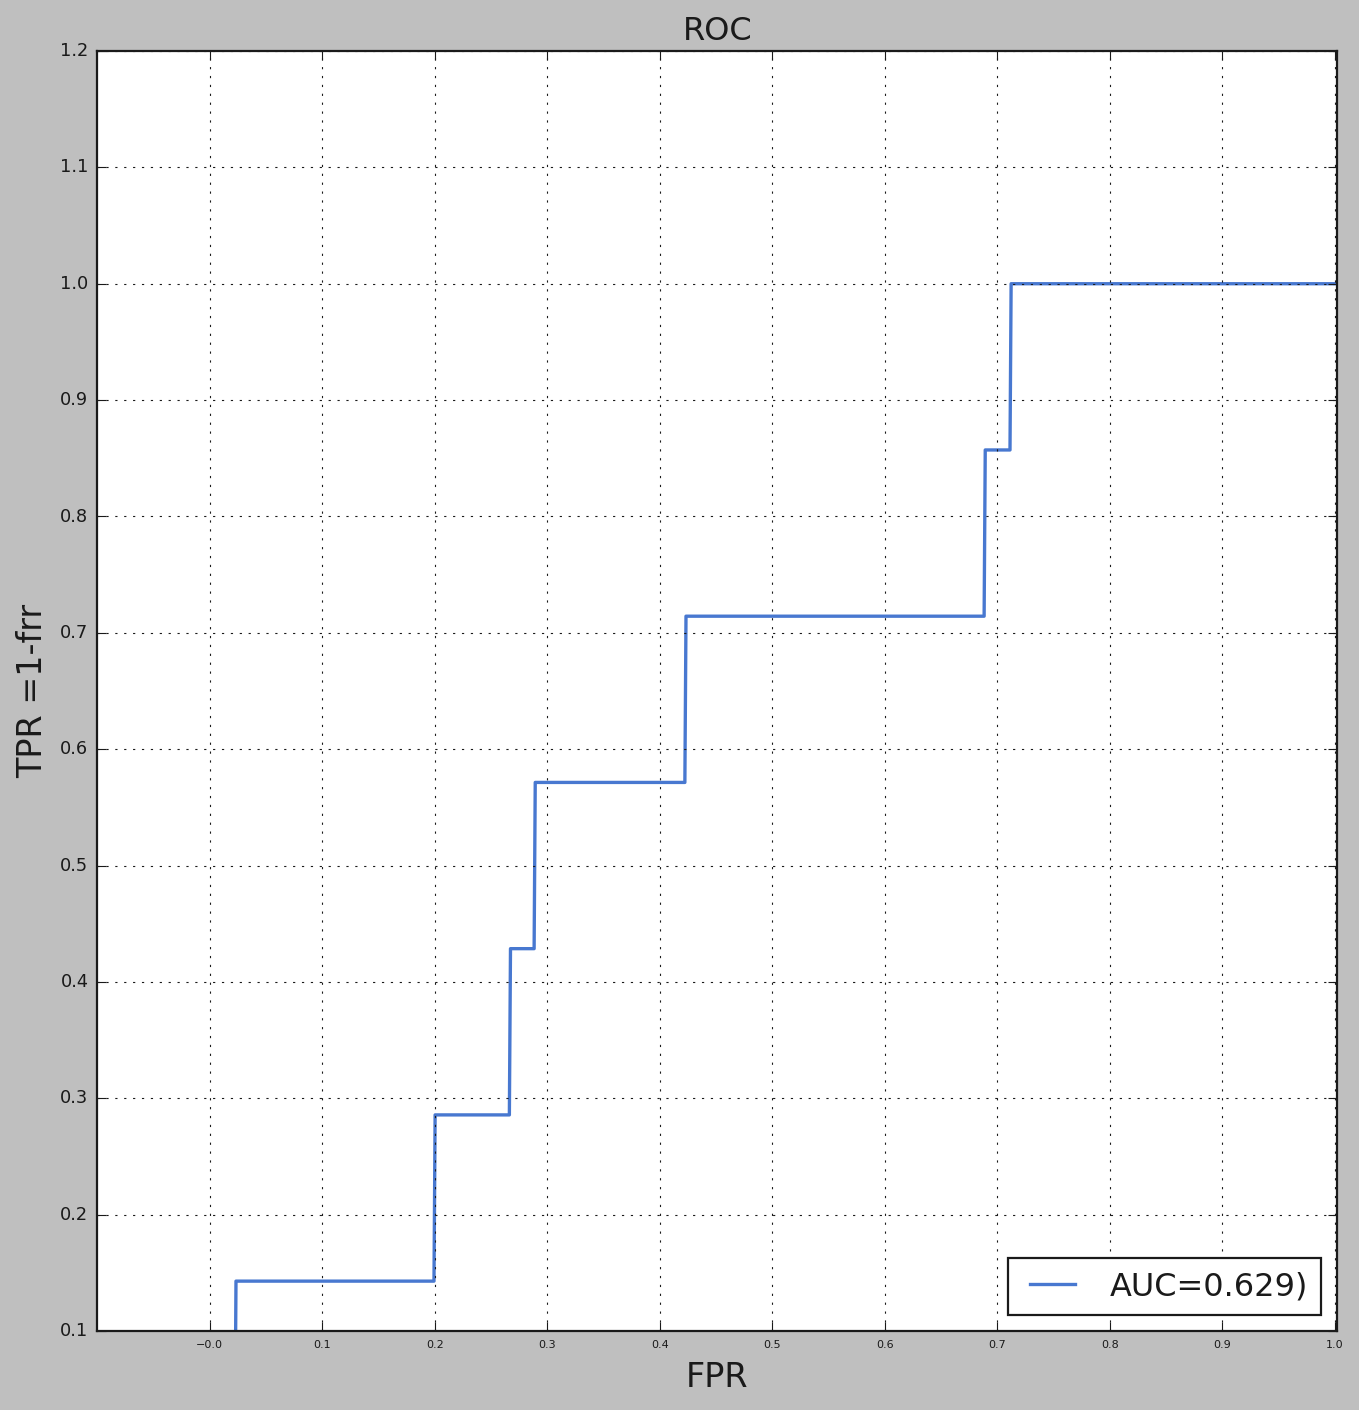

0.7110714285714286


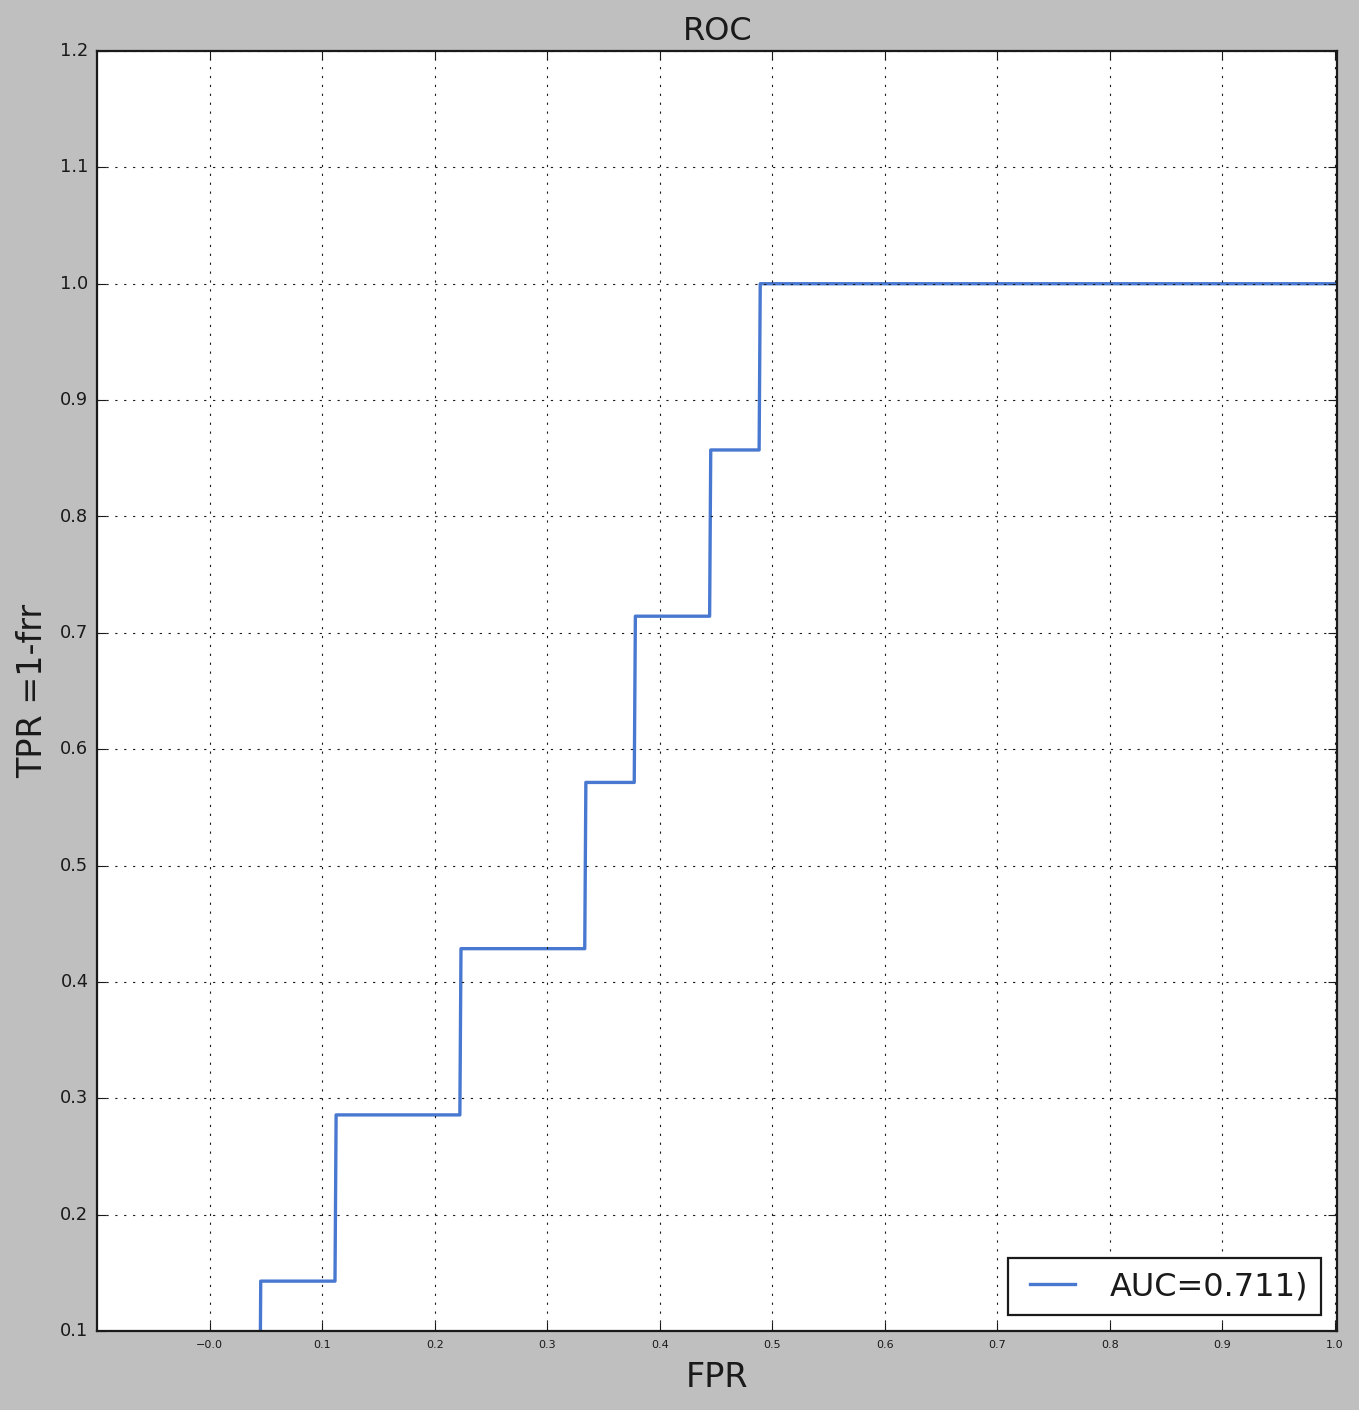

0.9804999999999999


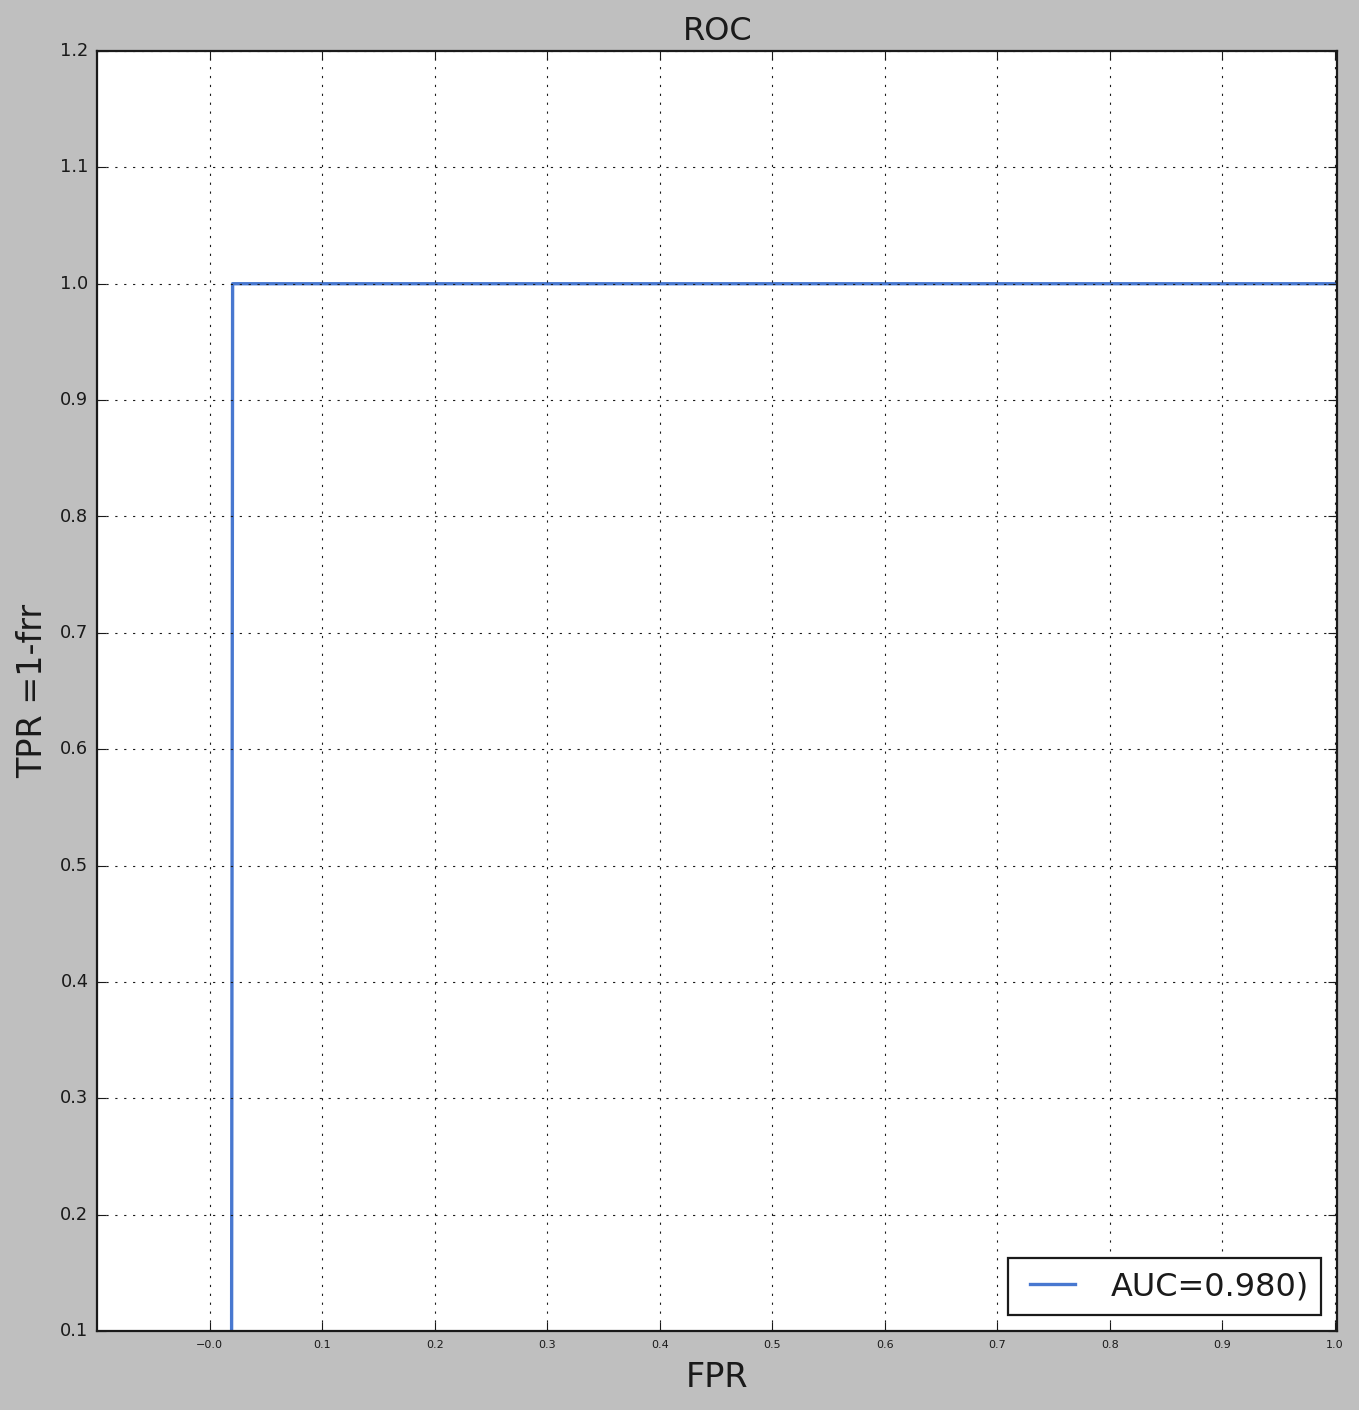

0.5685


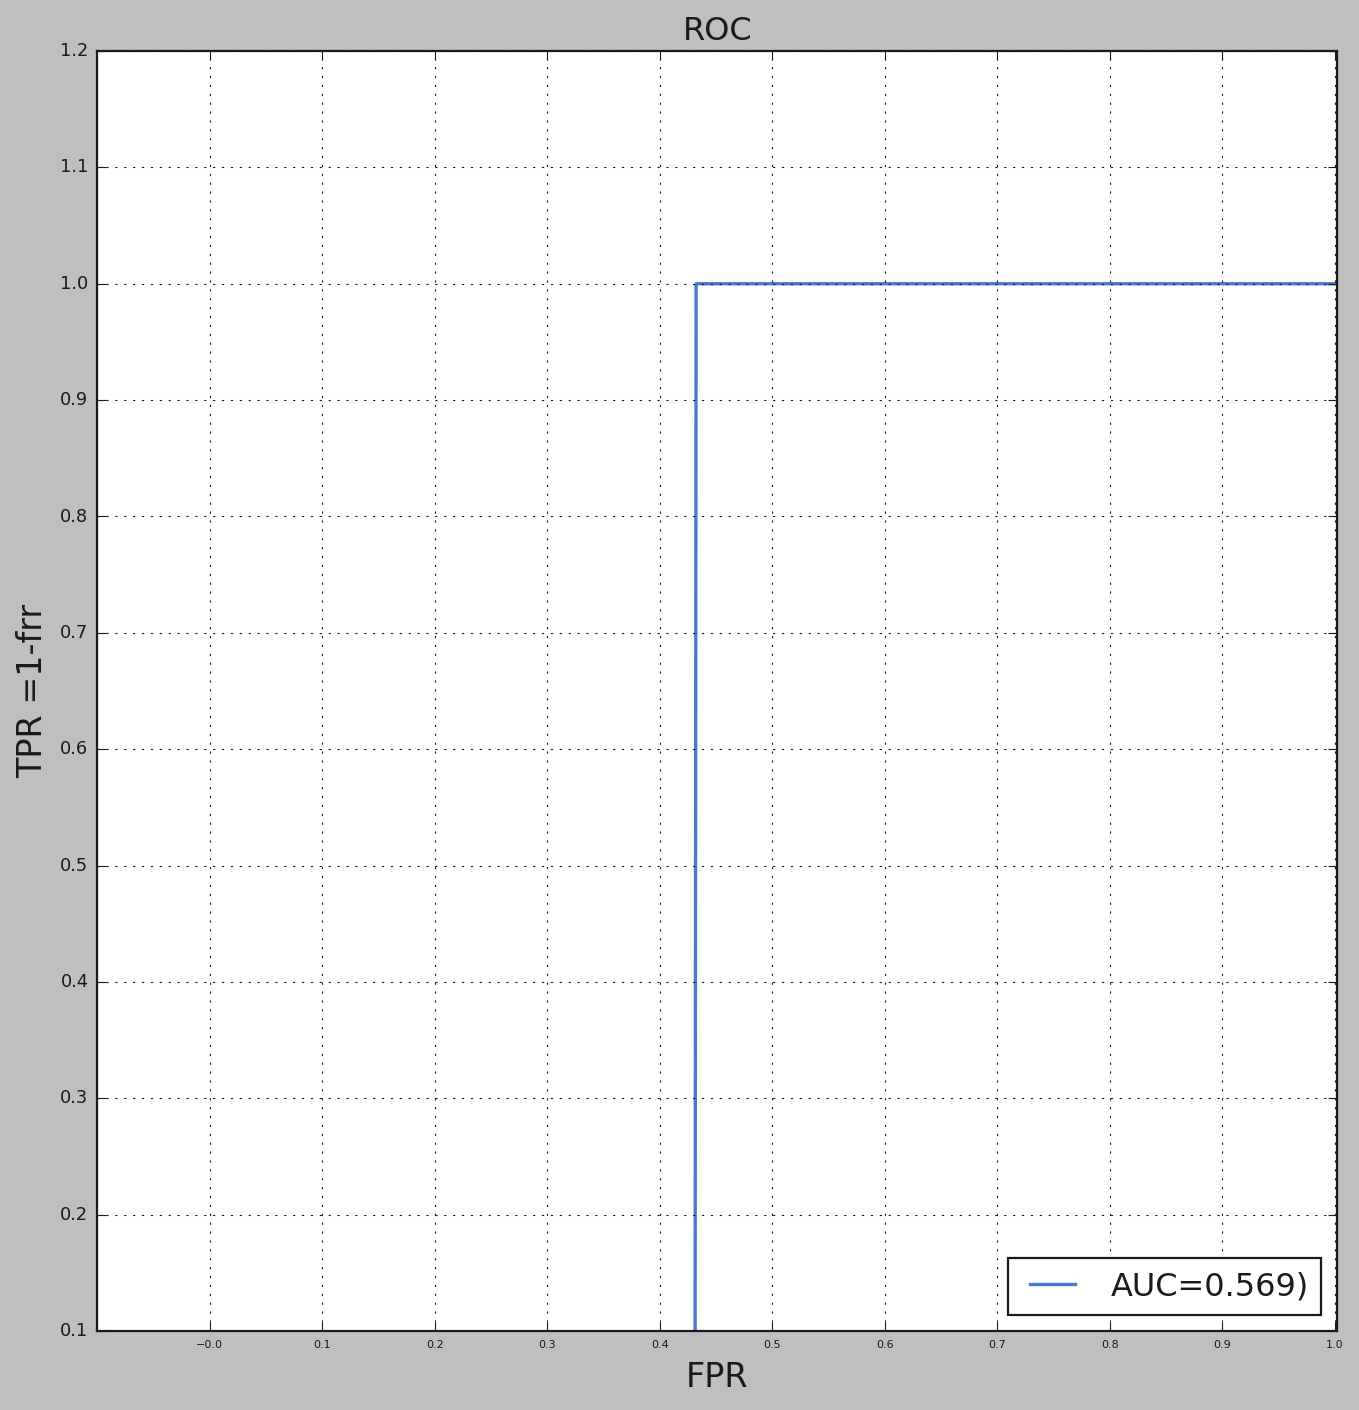

0.9804999999999999


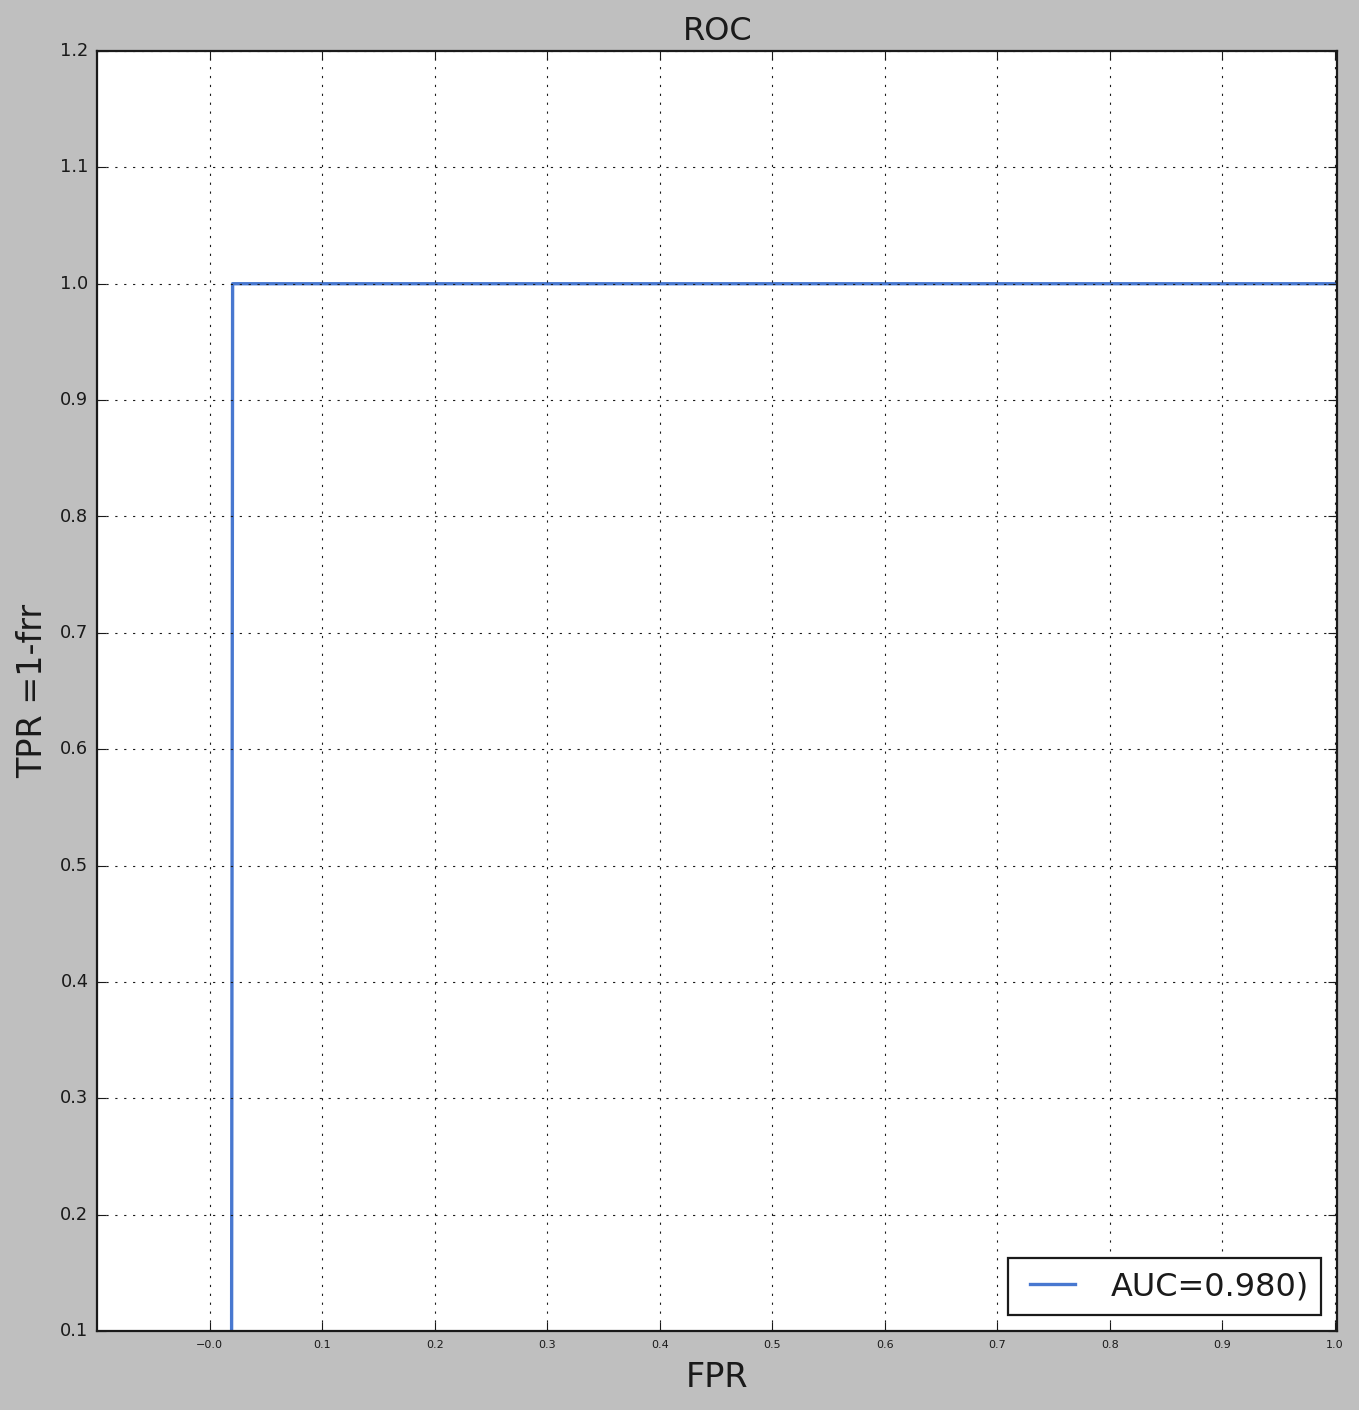

0.8144500000000001


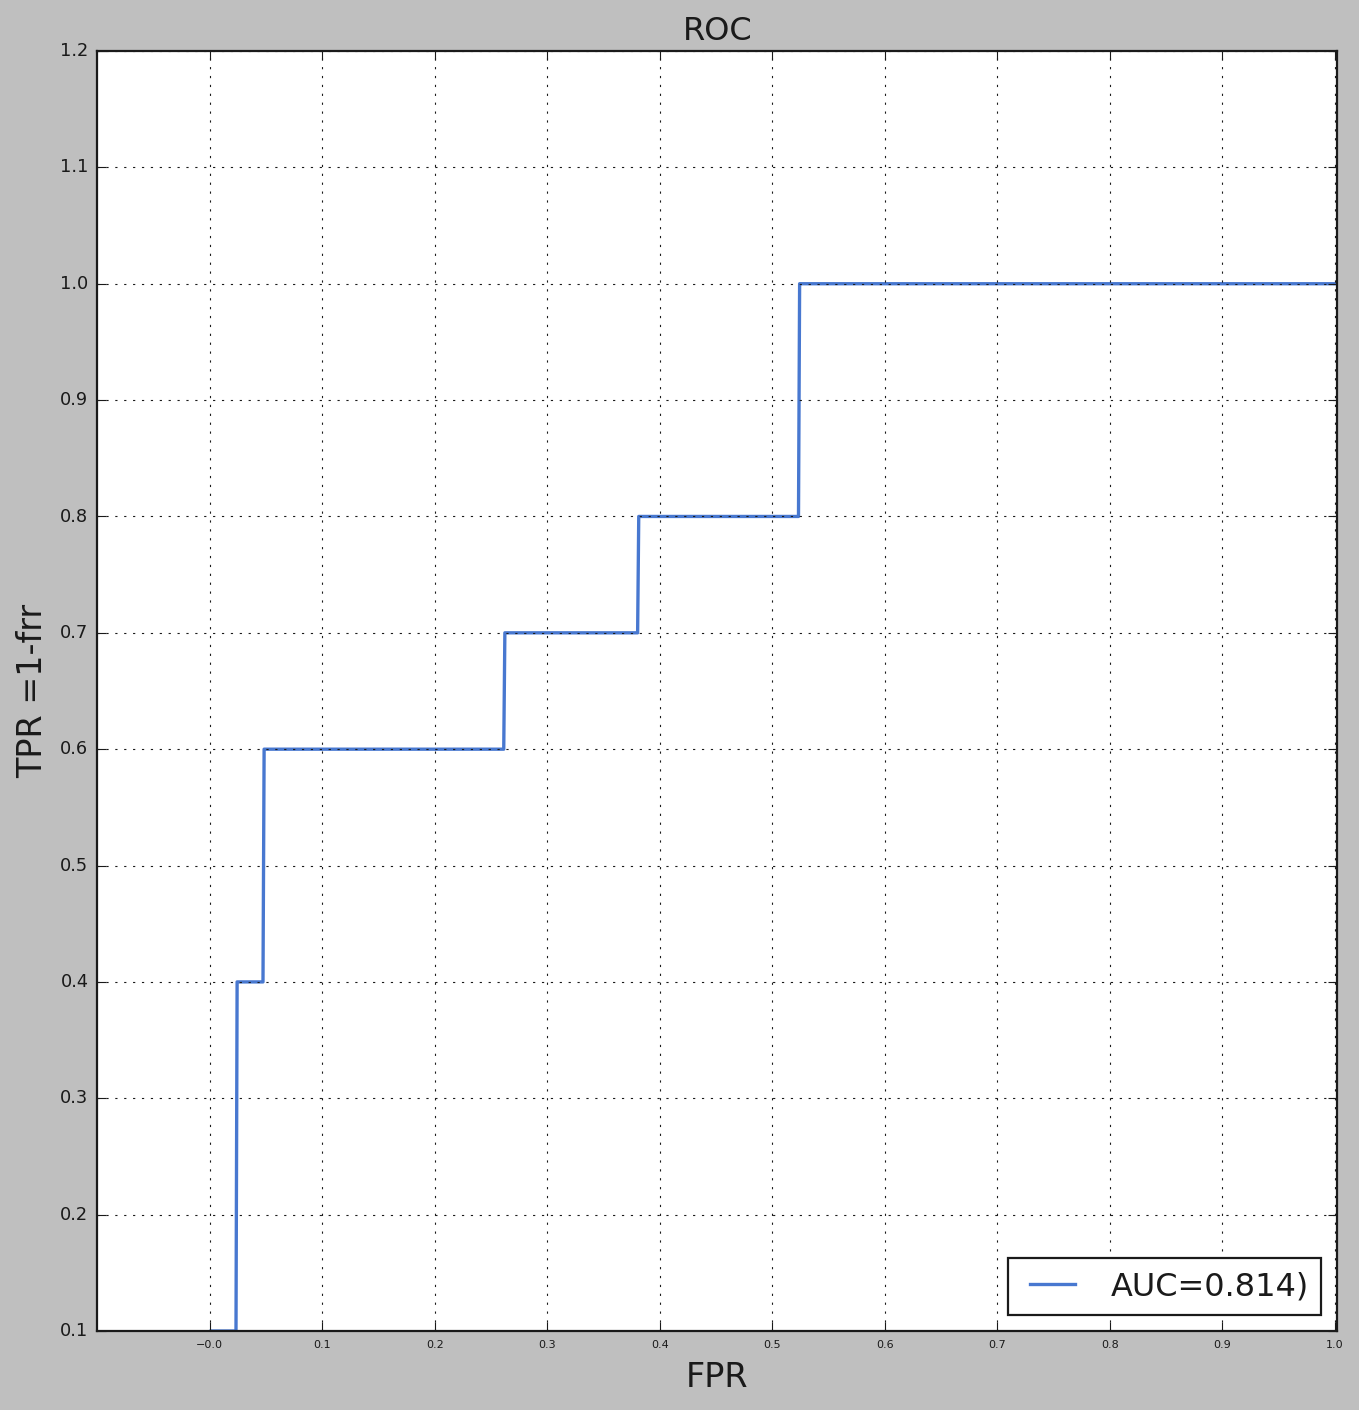

0.5405


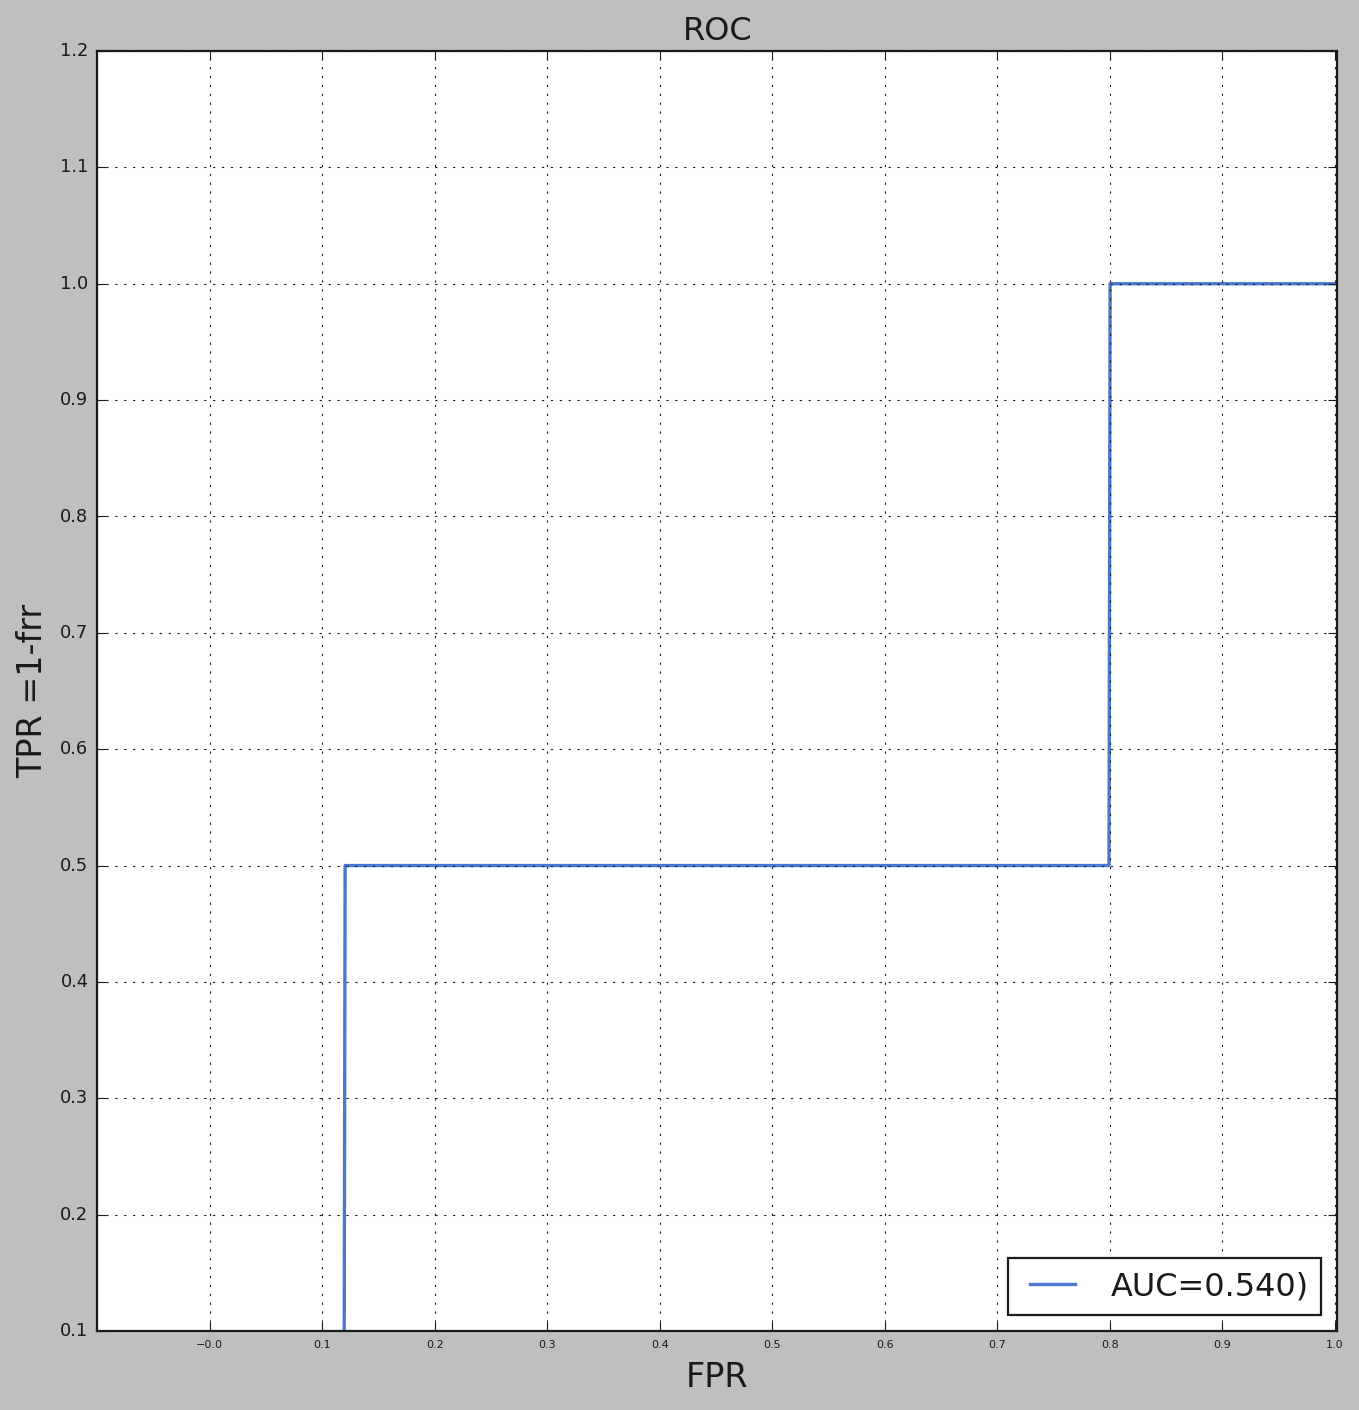

0.9232857142857143


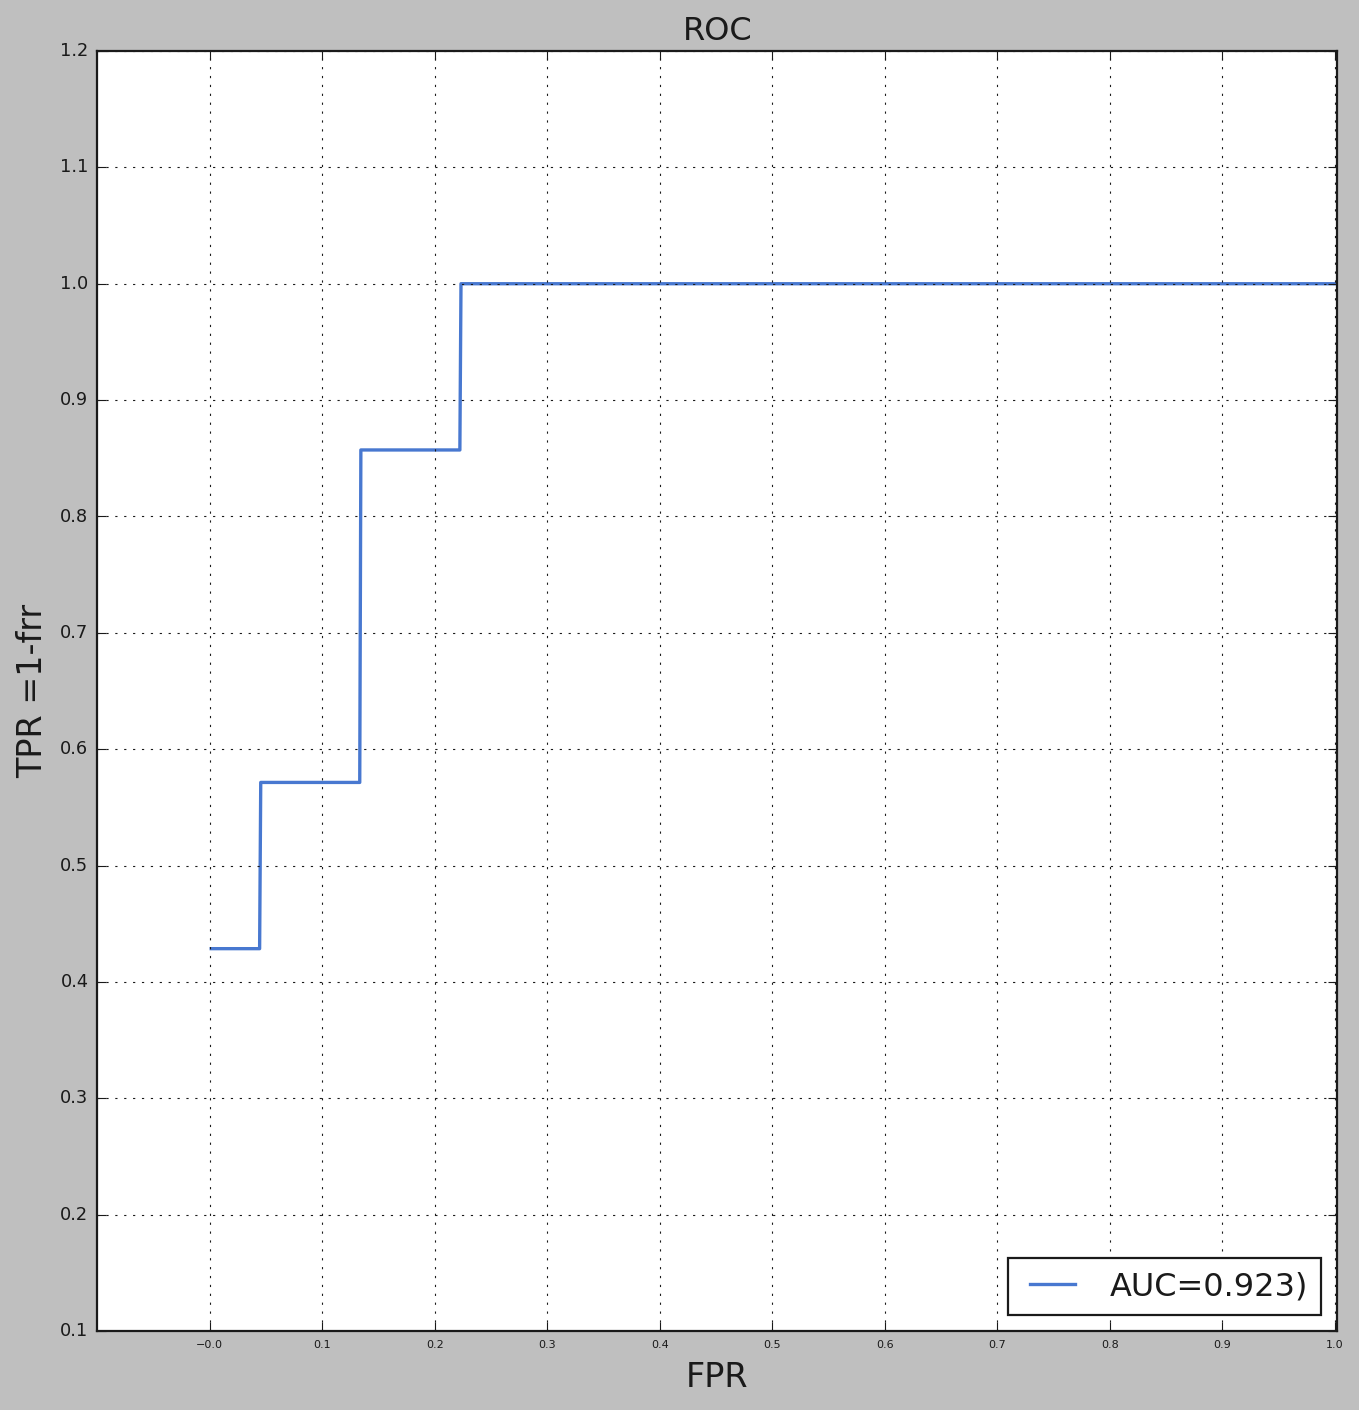

0.9683035714285714


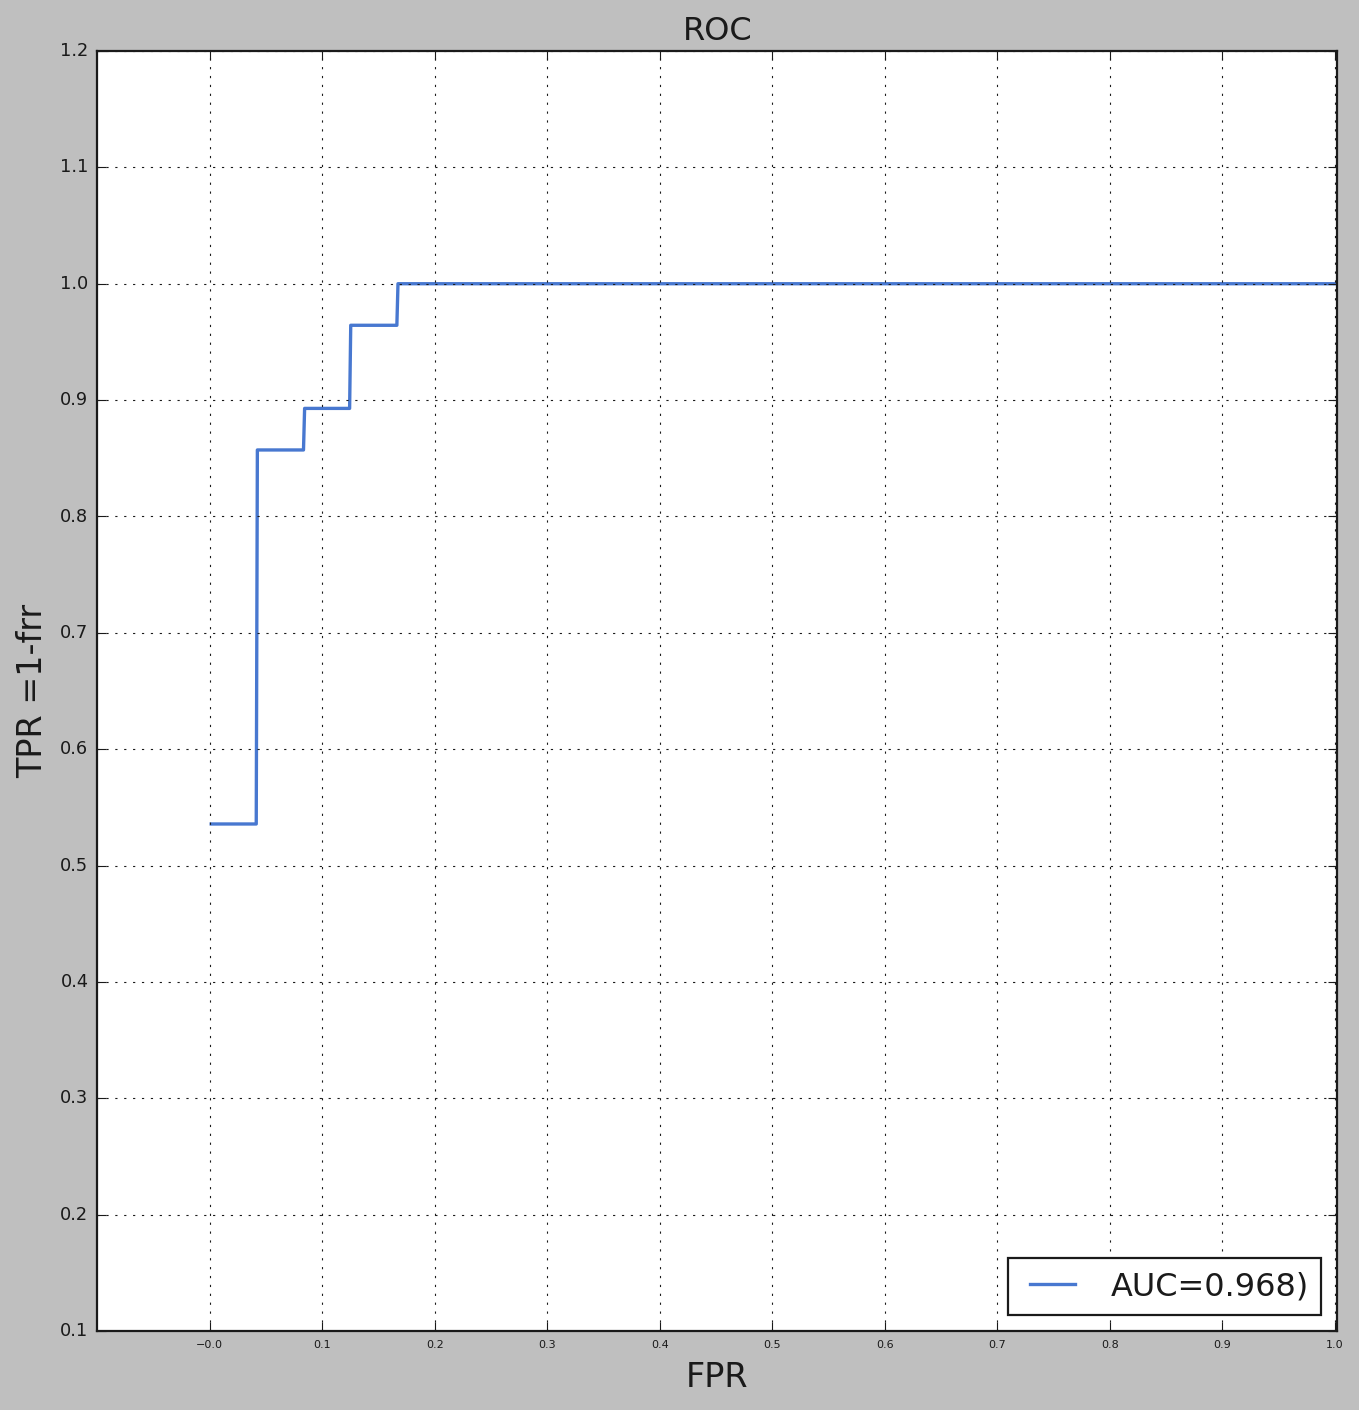

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


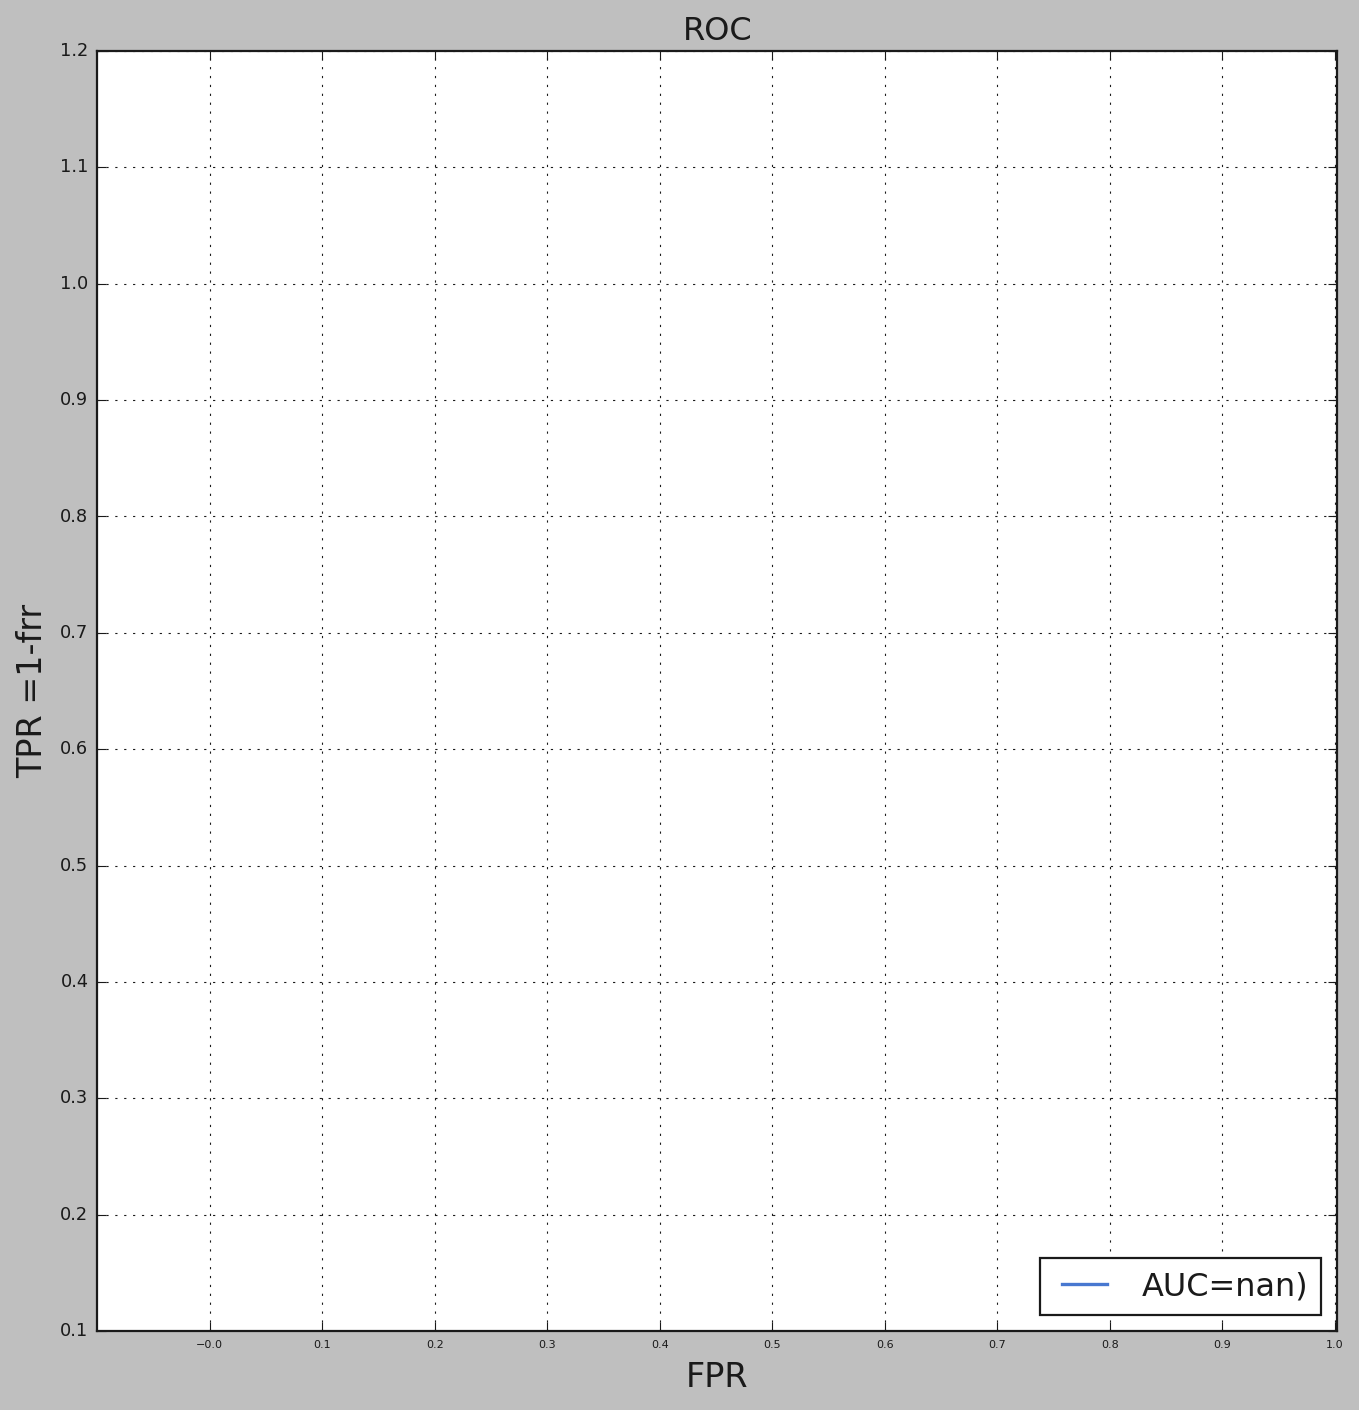

0.8971714285714286


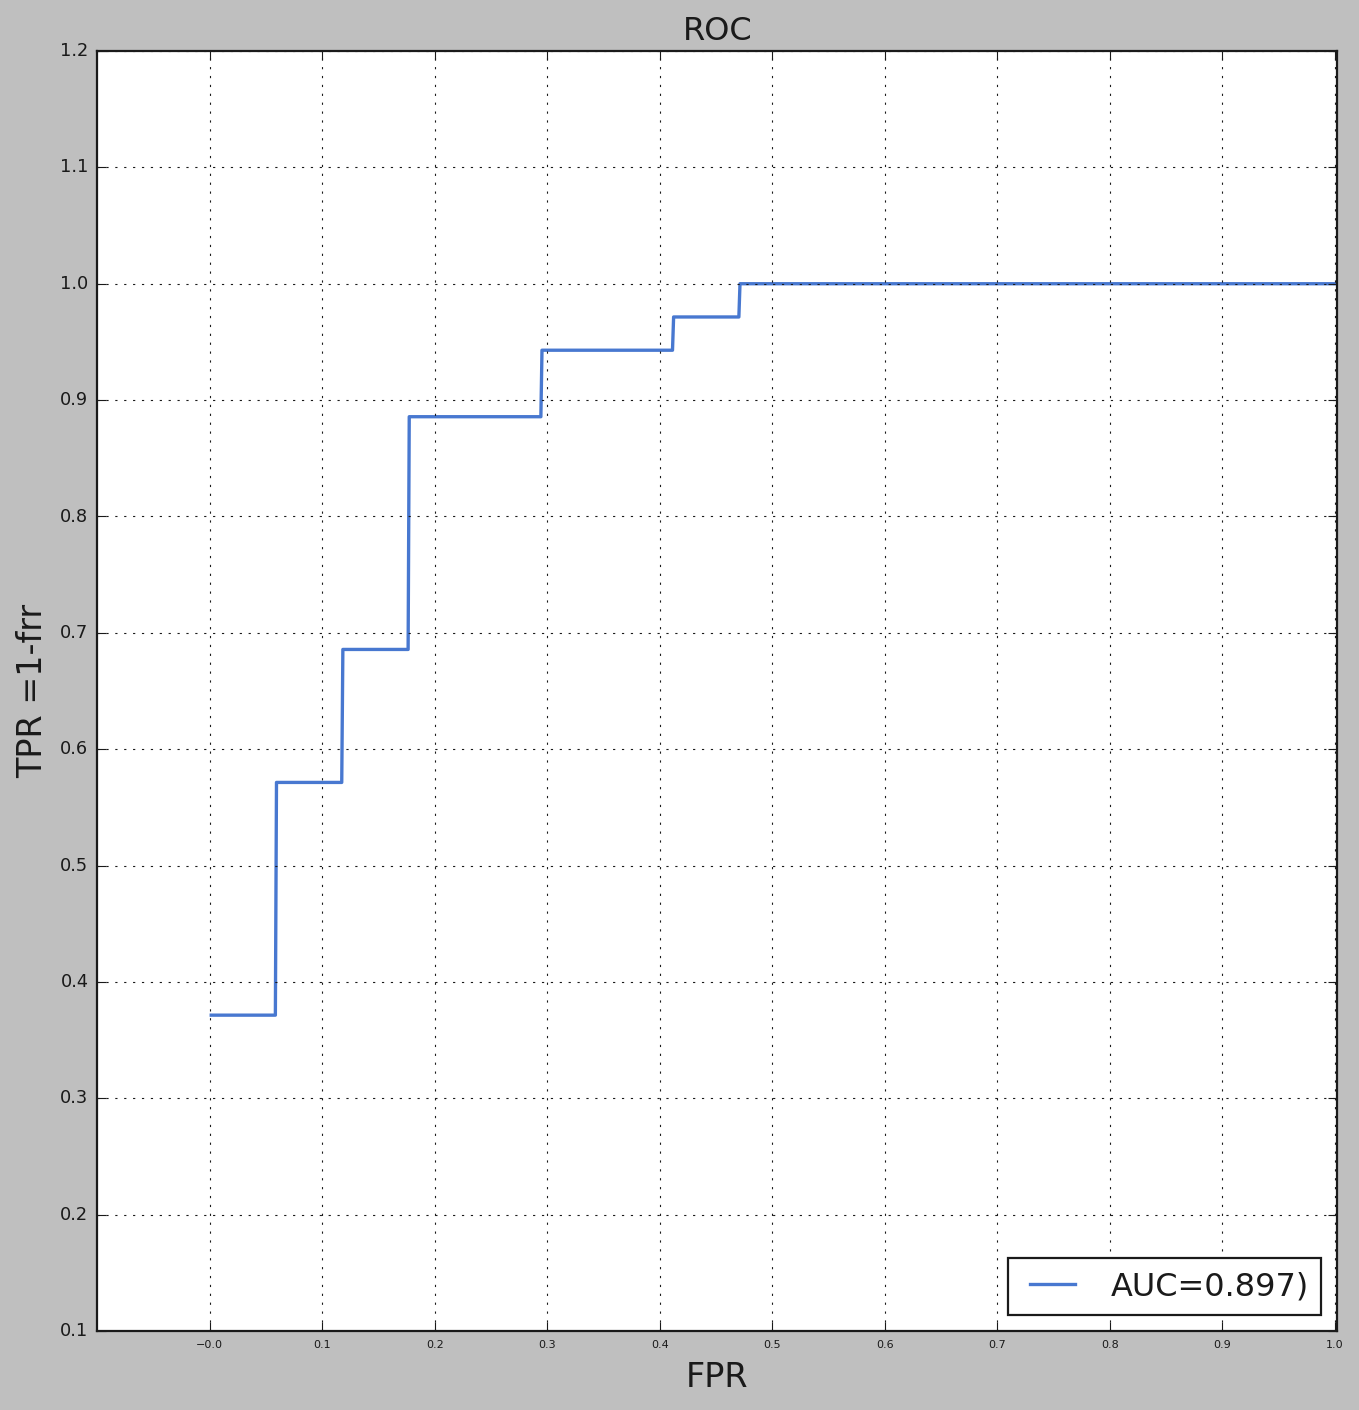

0.6665


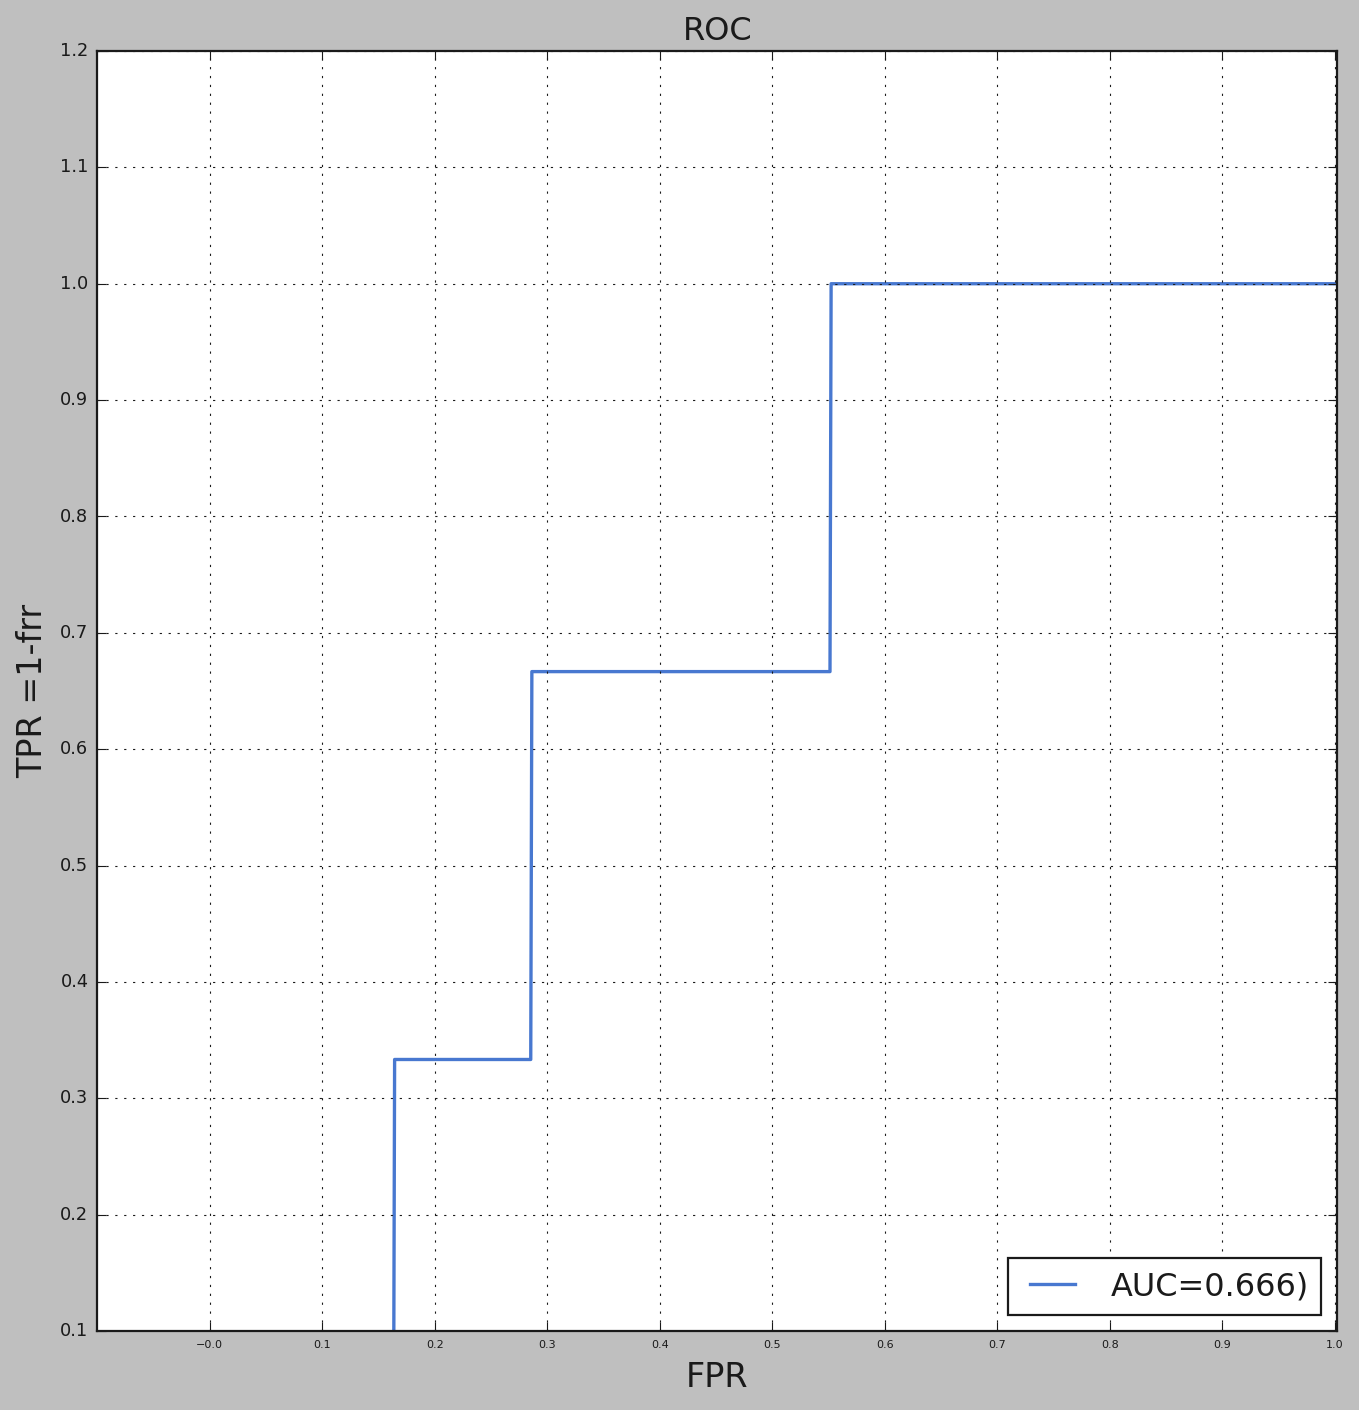

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


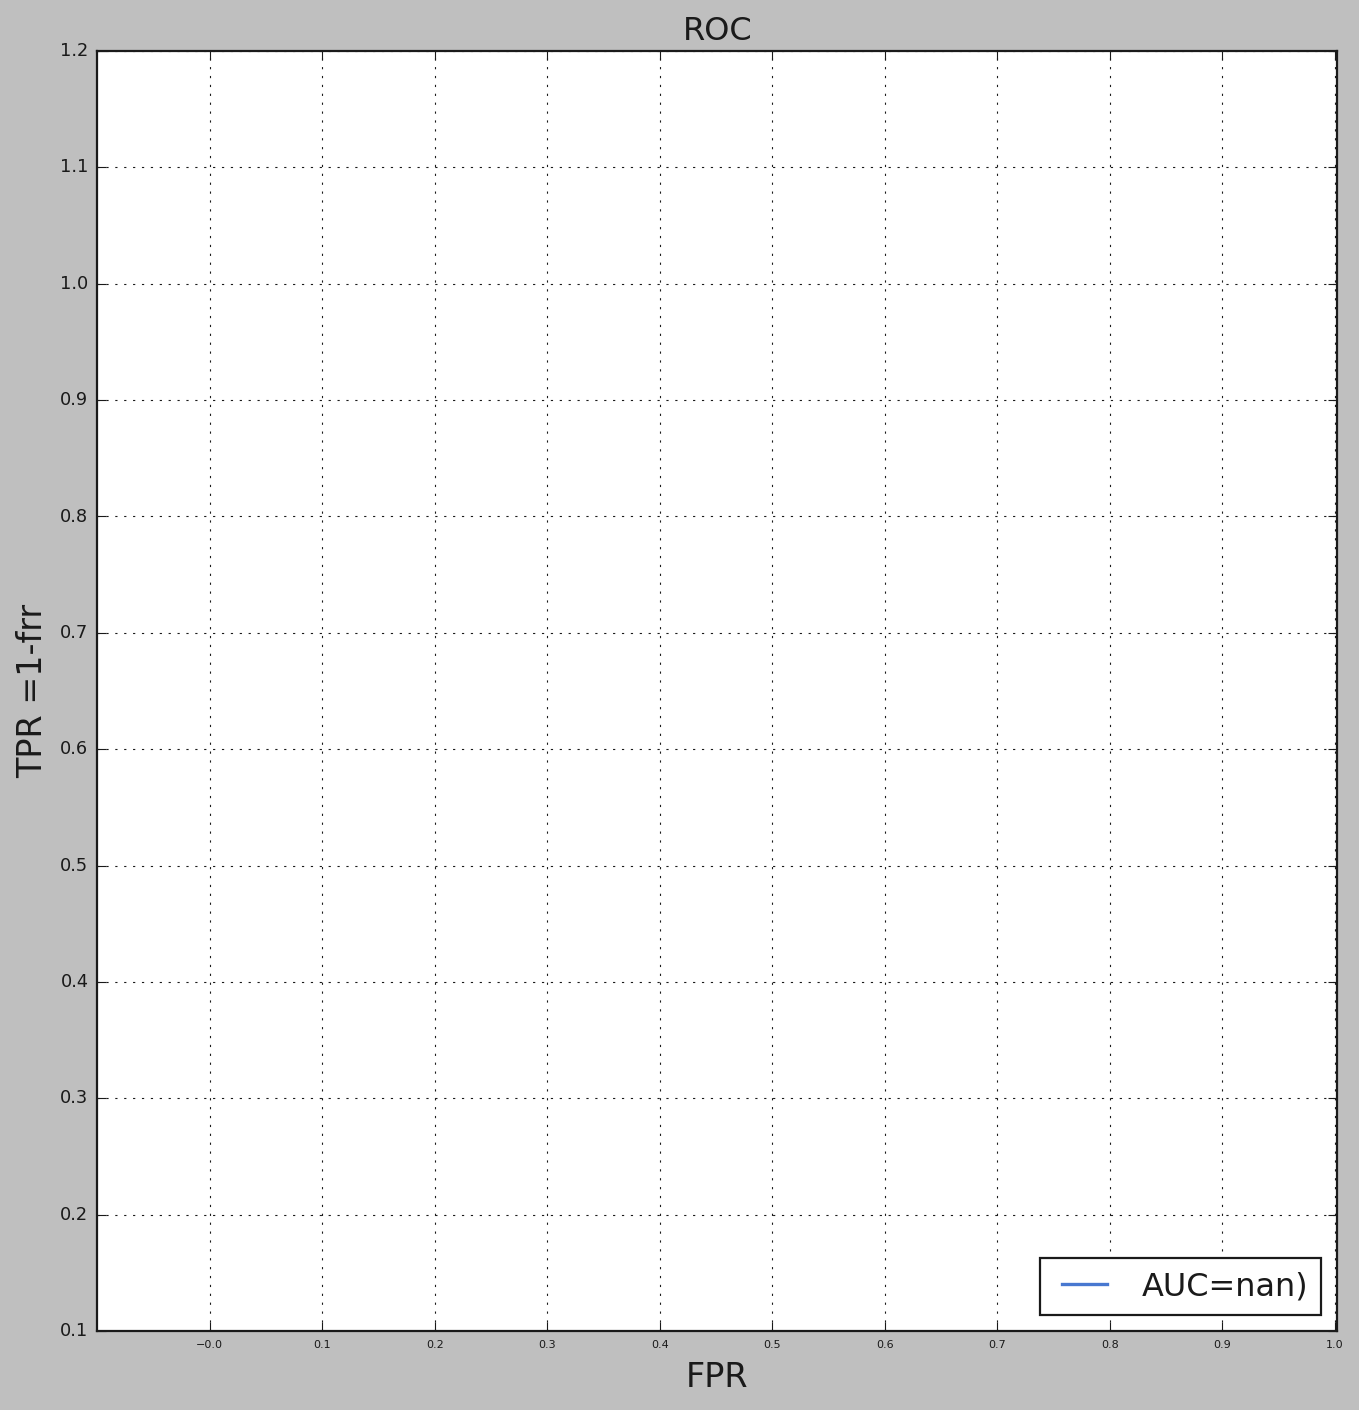

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


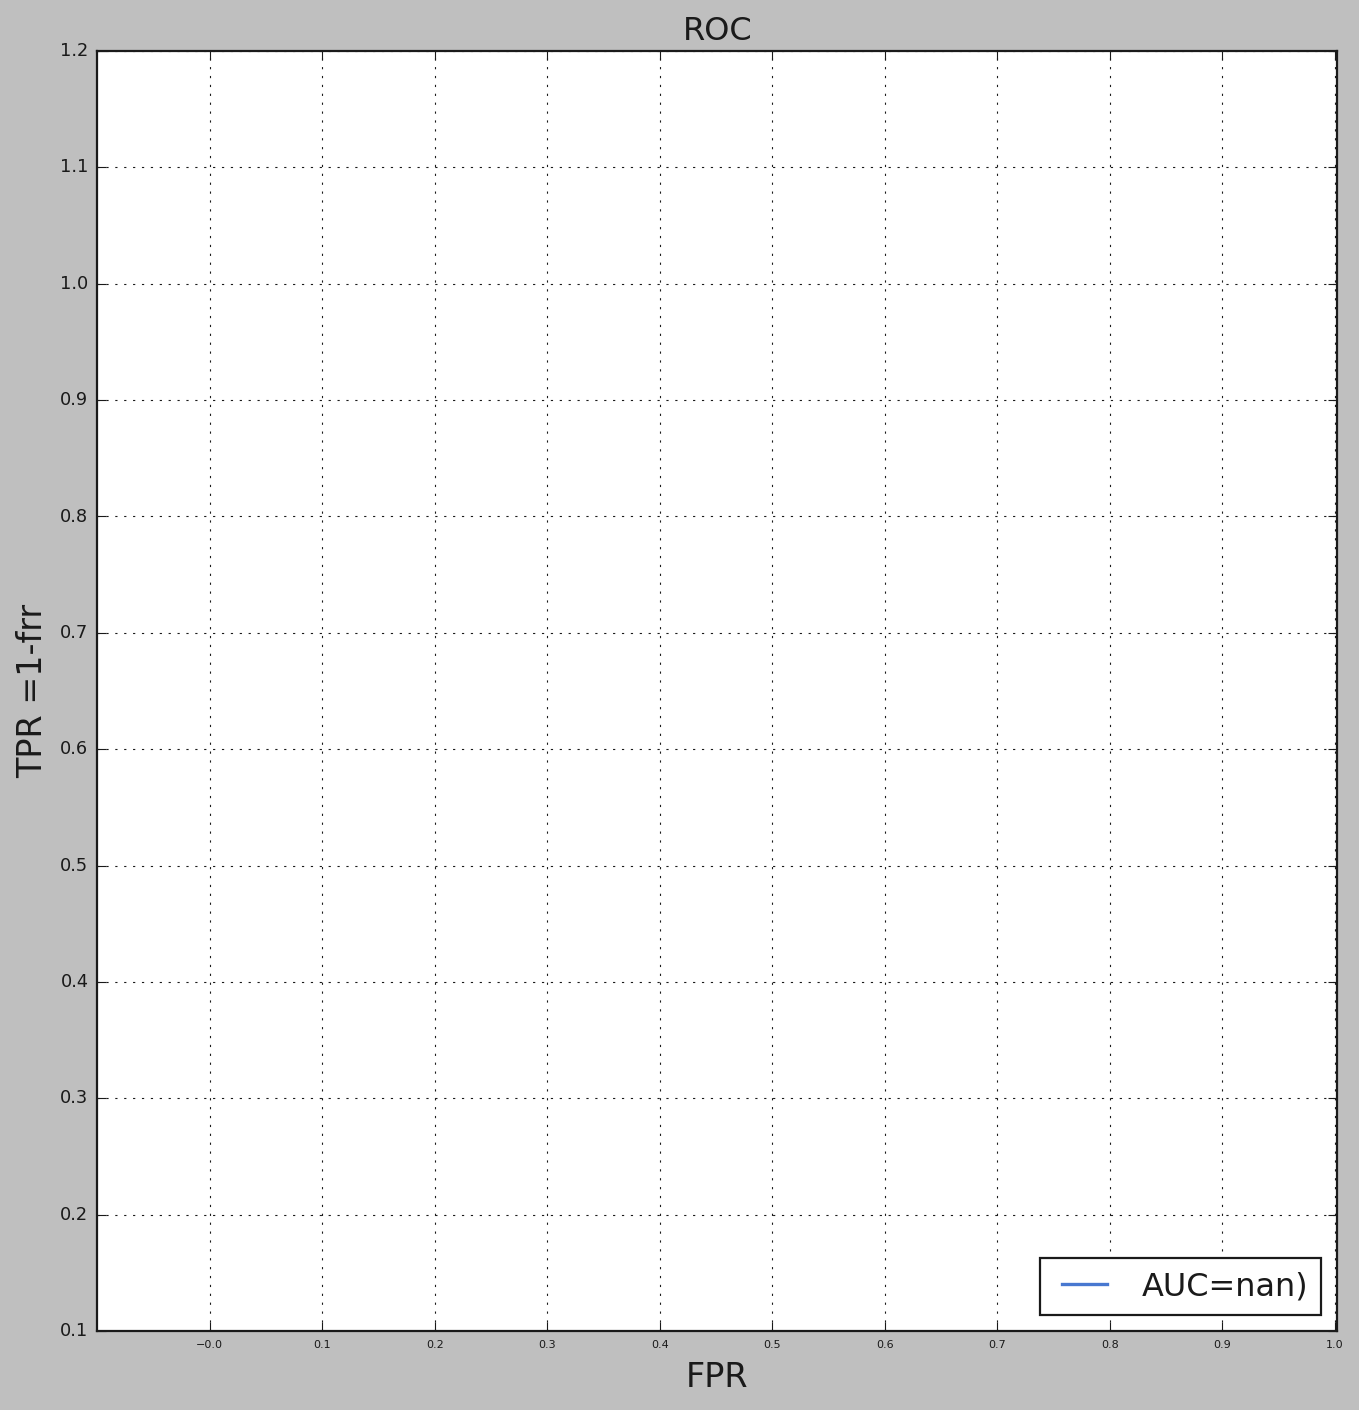

0.999


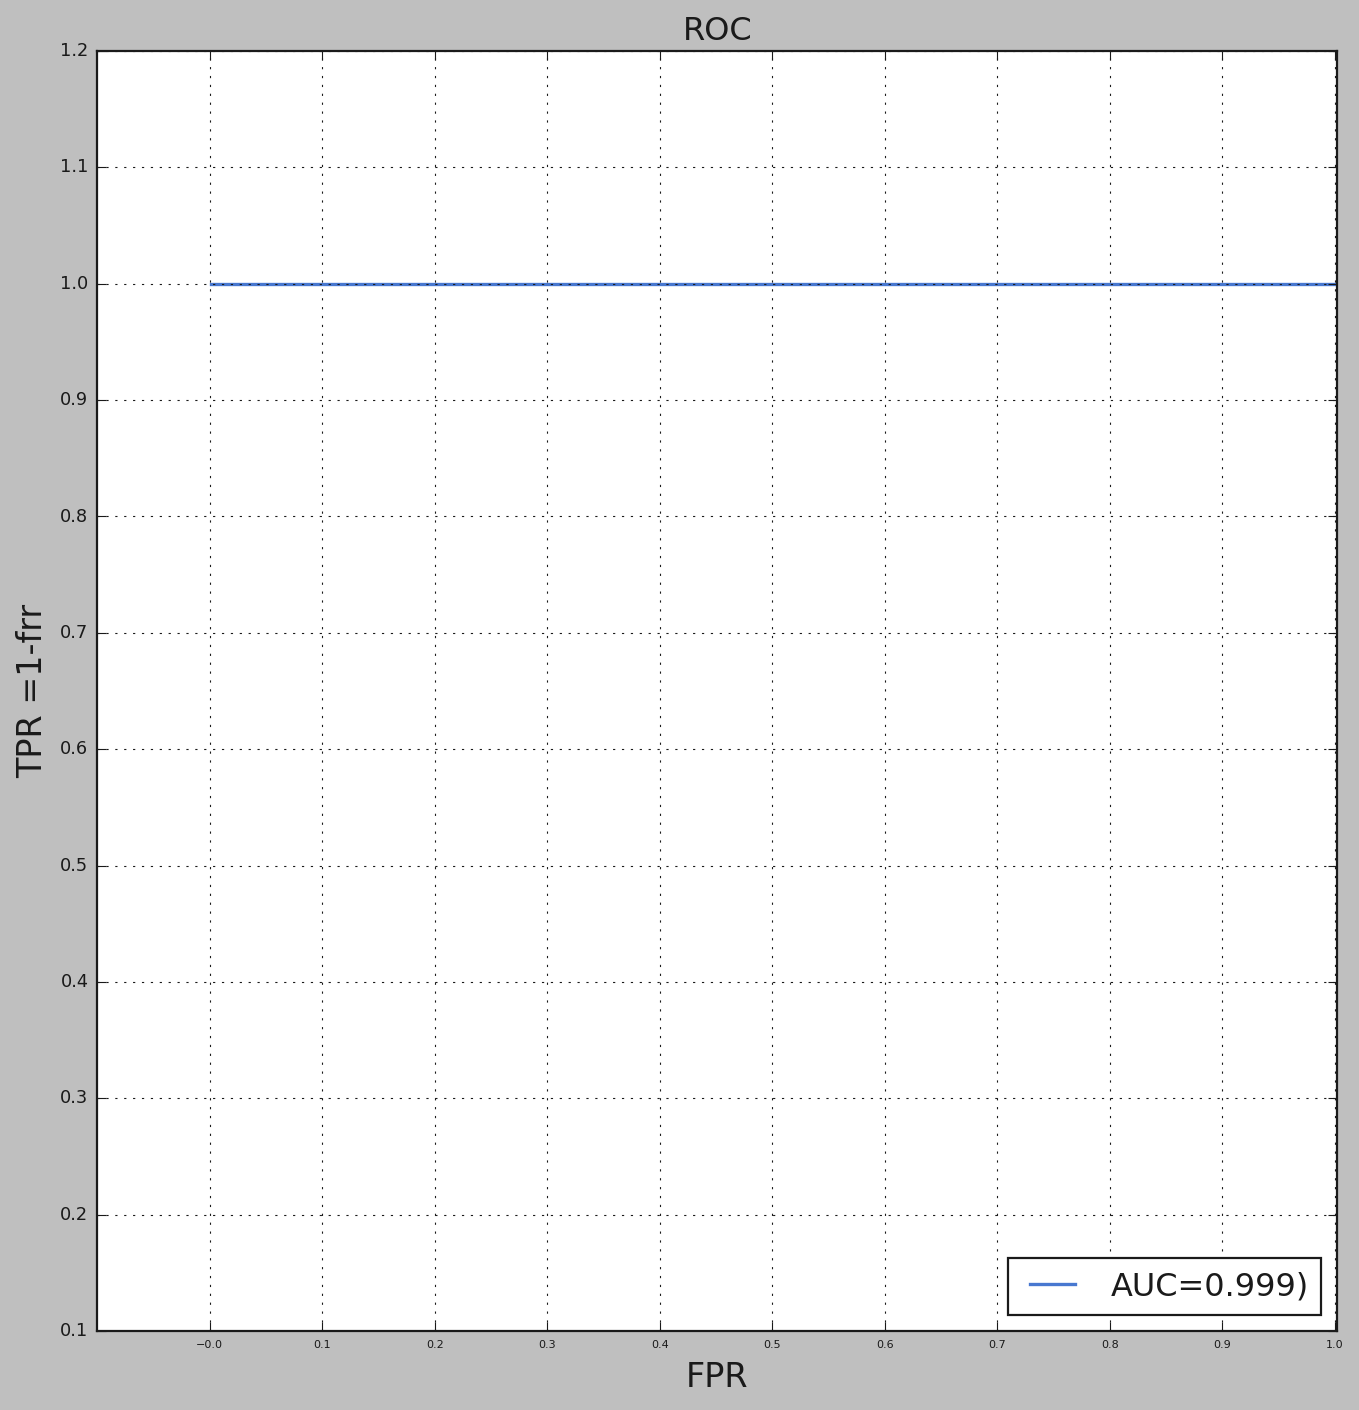

0.9215


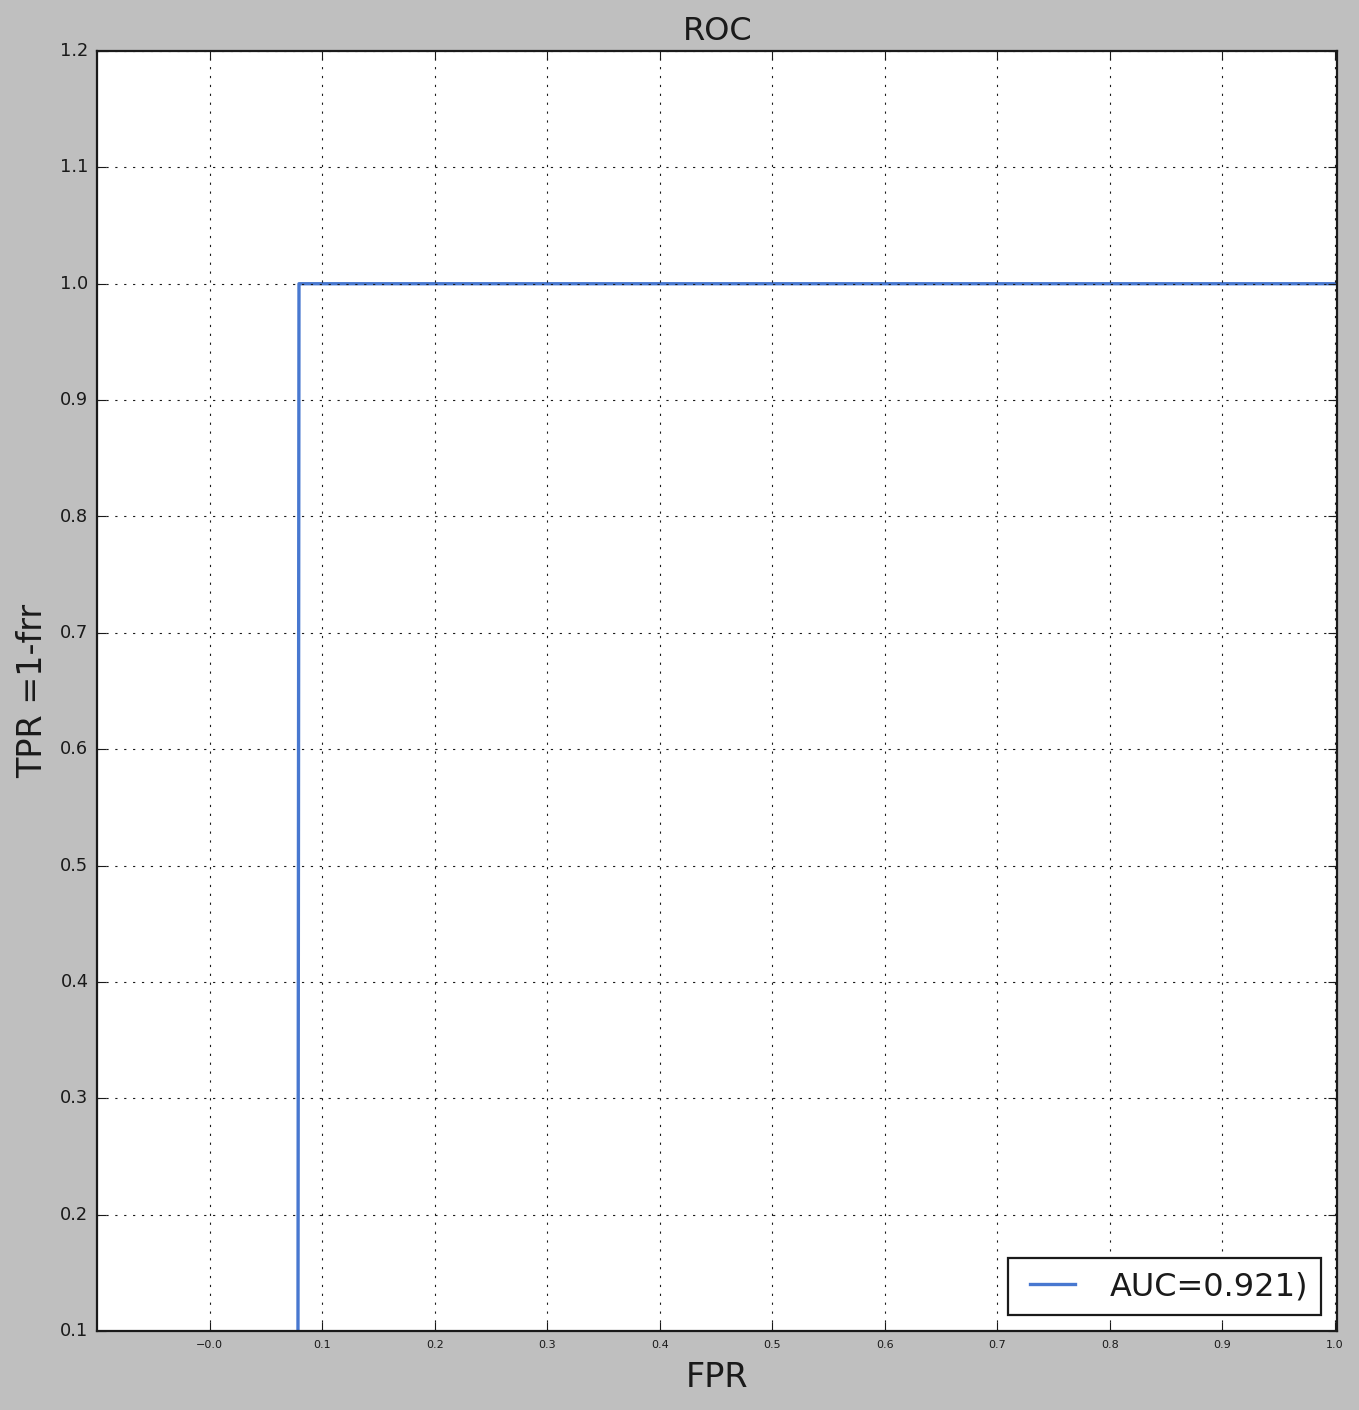

0.8708333333333333


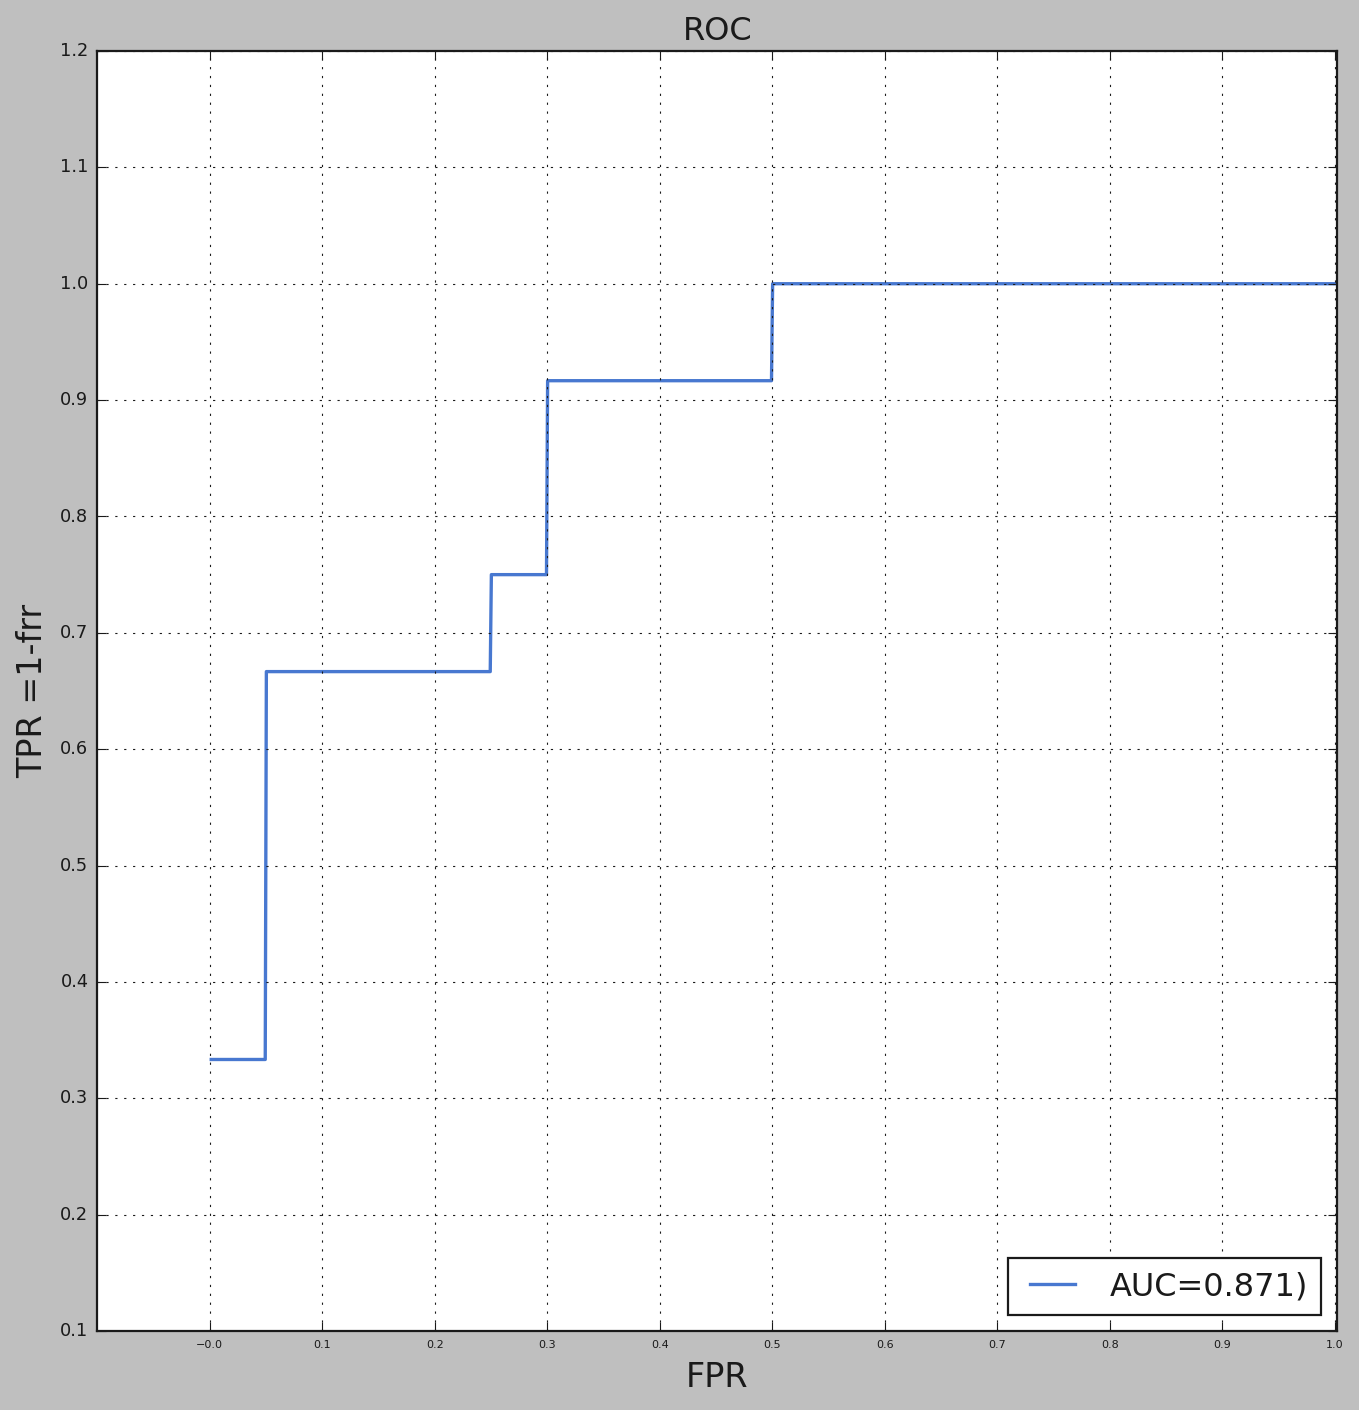

0.999


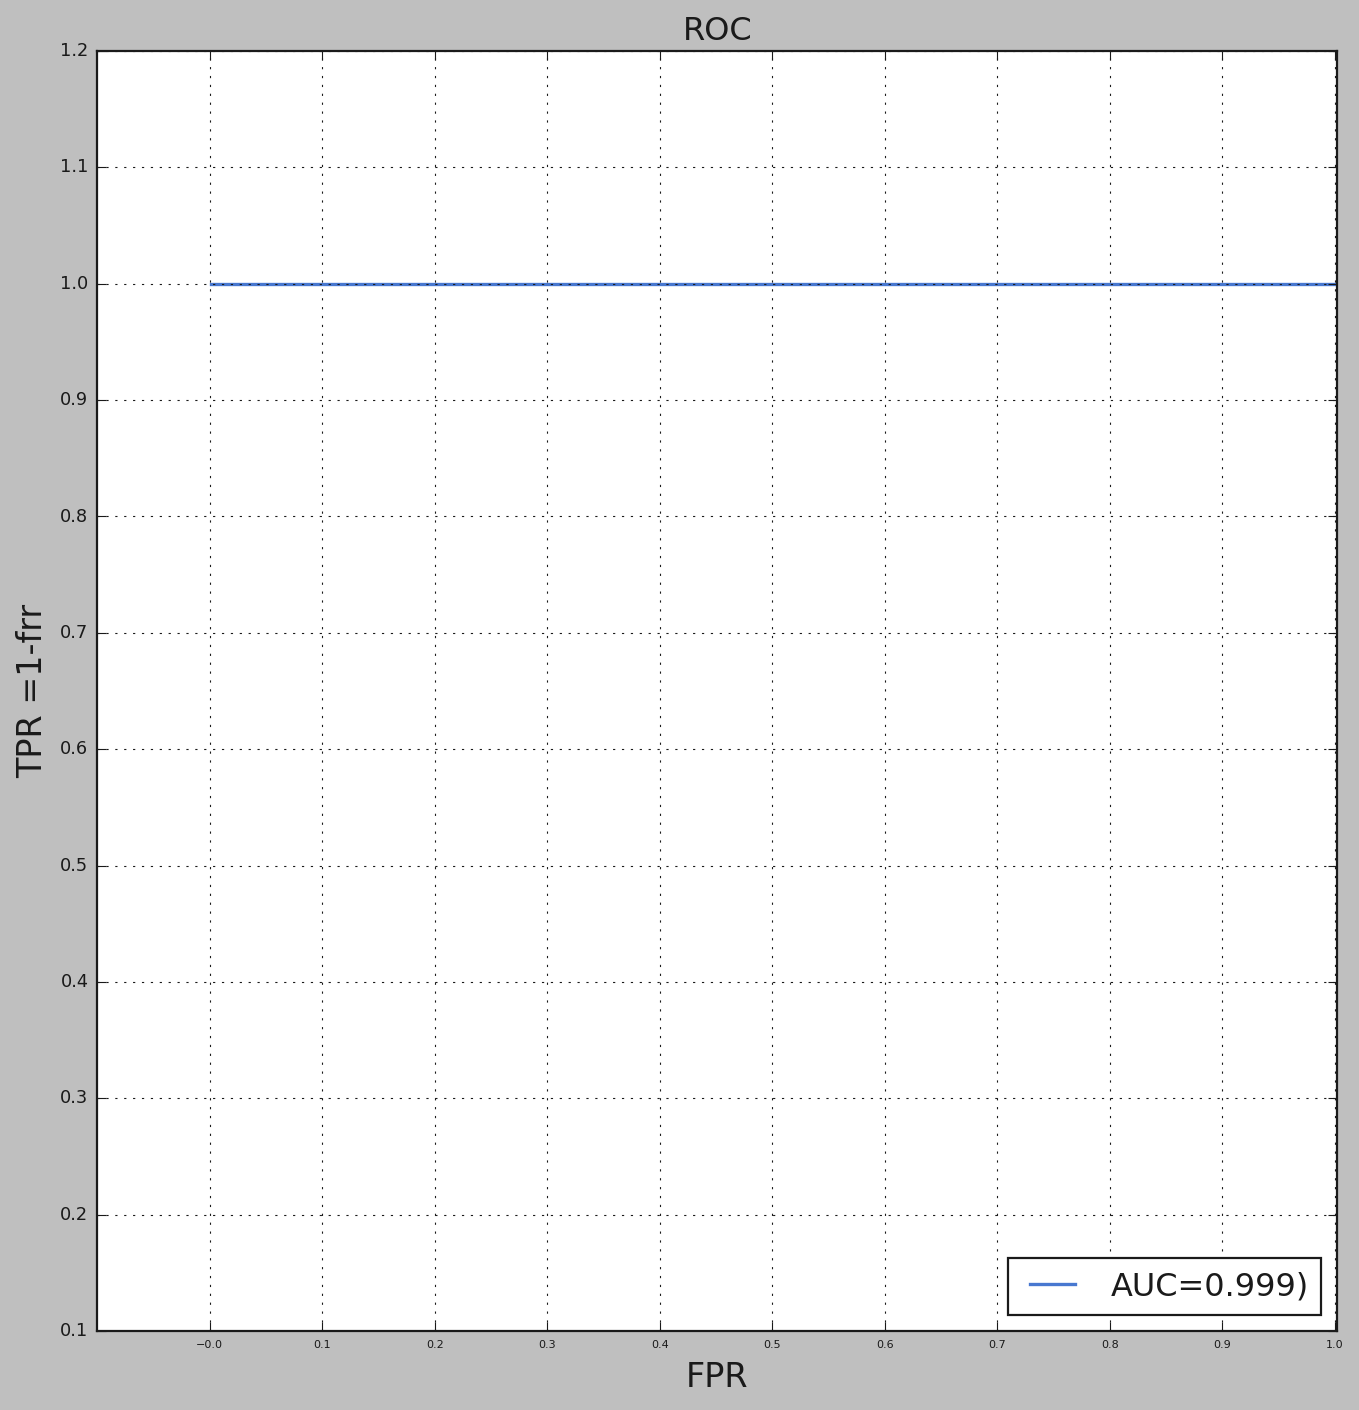

0.9215


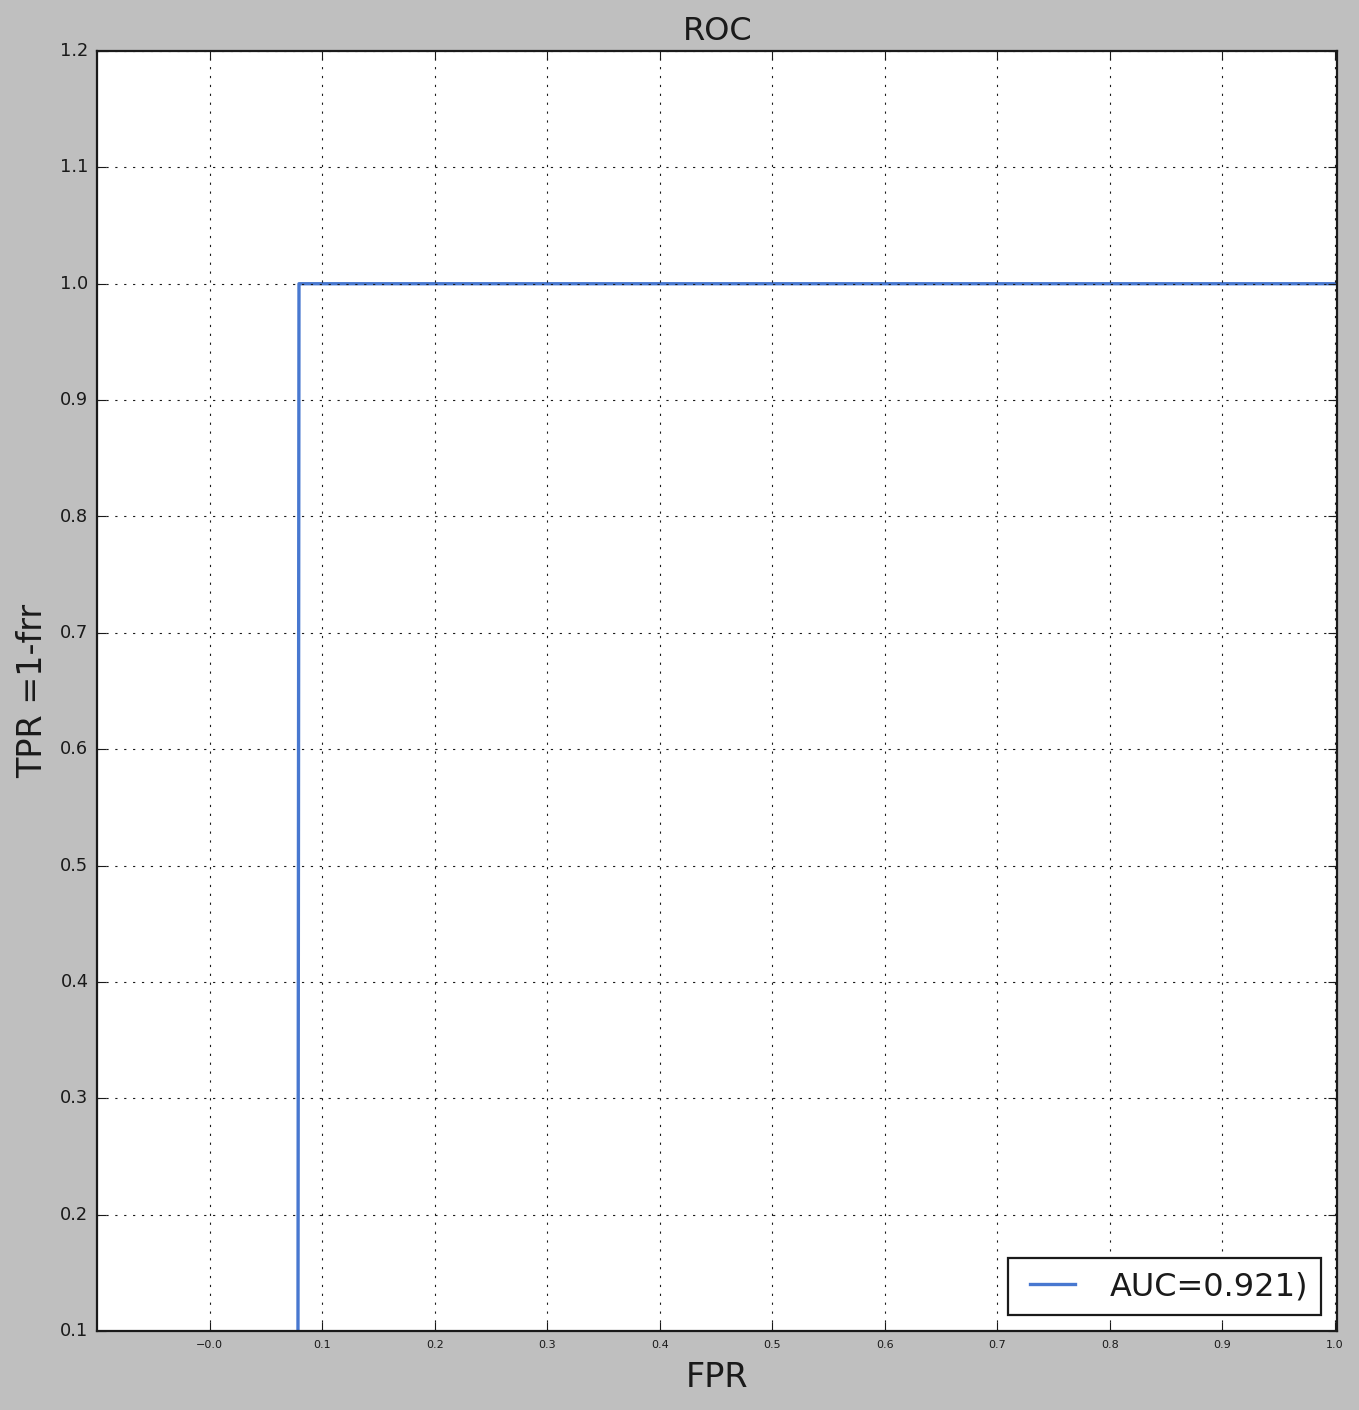

In [100]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

for i in range(len(propaganda_techniques_names)):
    
    labels = dev_df[propaganda_techniques_names[i]].to_list()
    scores = [s[i] for s in scoress]

    plt.style.use('classic')
    fpr, tpr, thresholds = roc_curve(labels,scores, pos_label=1)
    from scipy.interpolate import interp1d
    predict= interp1d(fpr, tpr, kind="linear")
    fpr2=np.linspace(0.001,1,1000)
    tpr2=np.array([predict(x) for x in fpr2])

    auc_value = auc(fpr2,tpr2)
    print(auc_value)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr2,tpr2, lw=1.5, label="AUC=%.3f)"%auc_value)
    plt.xlim([-0.100211101, 1.002])
    plt.ylim([0.1, 1.05])
    plt.xlabel("FPR",fontsize=15)
    plt.ylabel("TPR =1-frr",fontsize=15)
    plt.xticks(np.arange(-0.0004, 1.0011, 0.1), size=5)
    plt.yticks(np.arange(0.1, 1.3, 0.1), size=8)
    plt.grid()
    # plt.axvline(x = 0.001, color = 'r', label = 'axvline - full height')

    plt.title("ROC")
    plt.legend(loc="lower right")
    plt.show()

In [101]:
predictions = [pred(row['text']) for index, row in test_df.iterrows()]
labels = [np.array(row[propaganda_techniques_names]) for index, row in test_df.iterrows()]

In [102]:
from sklearn.metrics import confusion_matrix, accuracy_score
def accuracies(y_pred_pos,y_true,threshold):
    y_pred_class = y_pred_pos > threshold
    y_pred_class = np.array([int(c) for c in y_pred_class])
    tp , fp, tn, fn = cm(y_true, y_pred_class)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    return accuracy, tp , tn,fp , fn 
    
def cm(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

for i, name in enumerate(propaganda_techniques_names): 
    acc,tp , tn ,fp , fn = accuracies(predictions[i],labels[i],THRESHOLDS[name])
    print(f"{name}: {acc}: {tp + tn}  {THRESHOLDS[name]}")


Appeal to authority: 1.0: 19  0.11
Appeal to fear/prejudice: 1.0: 19  0.21
Black-and-white Fallacy/Dictatorship: 0.7894736842105263: 15  0.06
Causal Oversimplification: 0.631578947368421: 12  0.05
Doubt: 0.9473684210526315: 18  0.17
Exaggeration/Minimisation: 0.9473684210526315: 18  0.29
Flag-waving: 0.6842105263157895: 13  0.05
Glittering generalities (Virtue): 0.9473684210526315: 18  0.27
Loaded Language: 0.8947368421052632: 17  0.87
Misrepresentation of Someone's Position (Straw Man): 0.8421052631578947: 16  0.3
Name calling/Labeling: 0.7894736842105263: 15  0.78
Obfuscation, Intentional vagueness, Confusion: 0.631578947368421: 12  0.07
Presenting Irrelevant Data (Red Herring): 0.8947368421052632: 17  0.3
Reductio ad hitlerum: 0.8421052631578947: 16  0.3
Repetition: 0.8421052631578947: 16  0.18
Slogans: 0.8947368421052632: 17  0.09
Smears: 1.0: 19  0.57
Thought-terminating cliché: 0.7894736842105263: 15  0.09
Whataboutism: 0.7368421052631579: 14  0.09


In [103]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Personality')
    plt.xlabel('Predicted Personality');

In [104]:
predictio = []
for i, name in enumerate(propaganda_techniques_names): 
  predictions0 = []
  for p in np.array(predictions)[:, i]:
    if p>THRESHOLDS[name] :
      predictions0.append(1)
    else:
      predictions0.append(0)
  predictio.append(predictions0)
predictio = np.array(predictio)
predictio.shape

(19, 323)

In [105]:
predictio = []
for i, name in enumerate(propaganda_techniques_names): 
  predictions0 = []
  for p in np.array(predictions)[:, i]:
    if p>0.3 :
      predictions0.append(1)
    else:
      predictions0.append(0)
  predictio.append(predictions0)
predictio = np.array(predictio)
predictio.shape

(19, 323)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


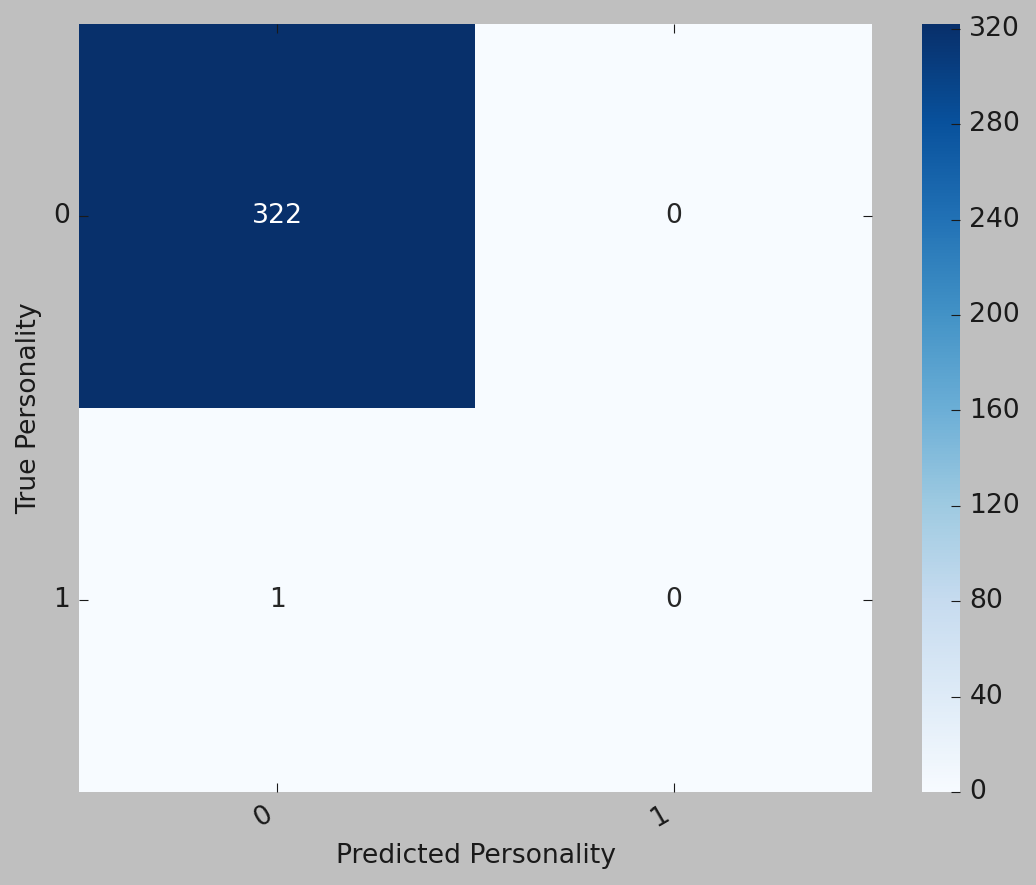

In [106]:
i = 0
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       298
           1       0.00      0.00      0.00        25

    accuracy                           0.92       323
   macro avg       0.46      0.50      0.48       323
weighted avg       0.85      0.92      0.89       323



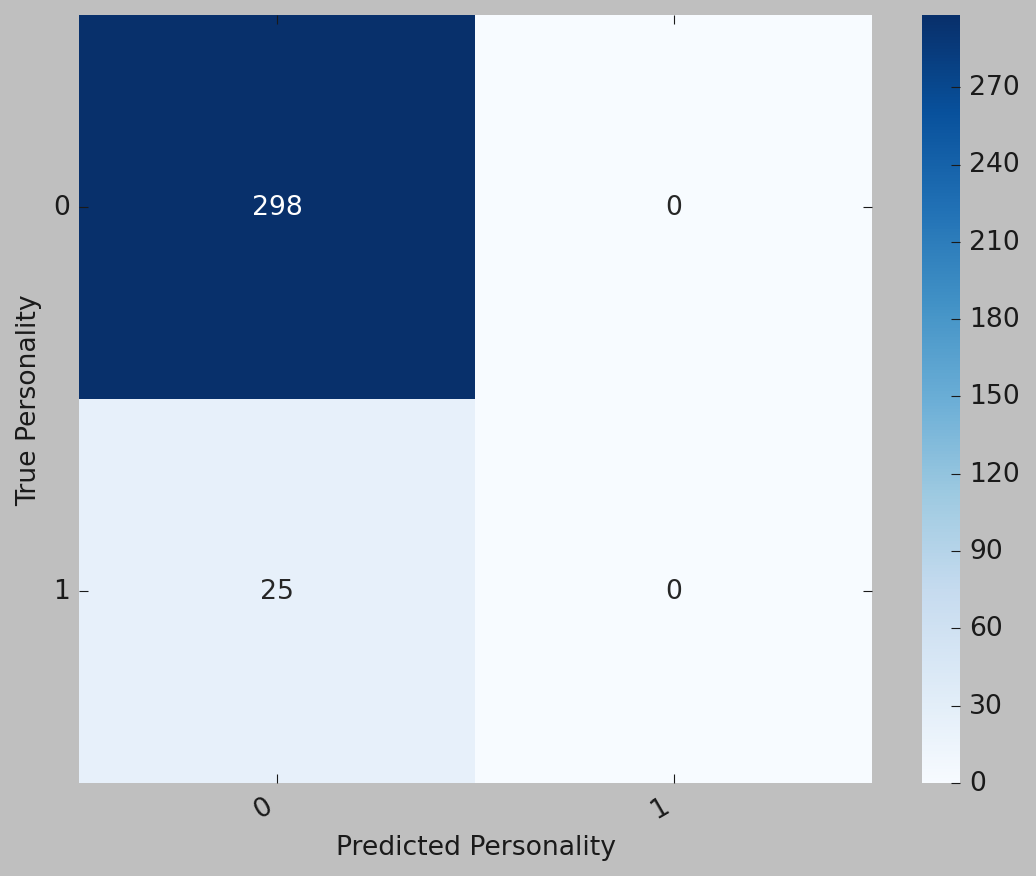

In [107]:
i = 1
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       316
           1       0.00      0.00      0.00         7

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.49       323
weighted avg       0.96      0.98      0.97       323



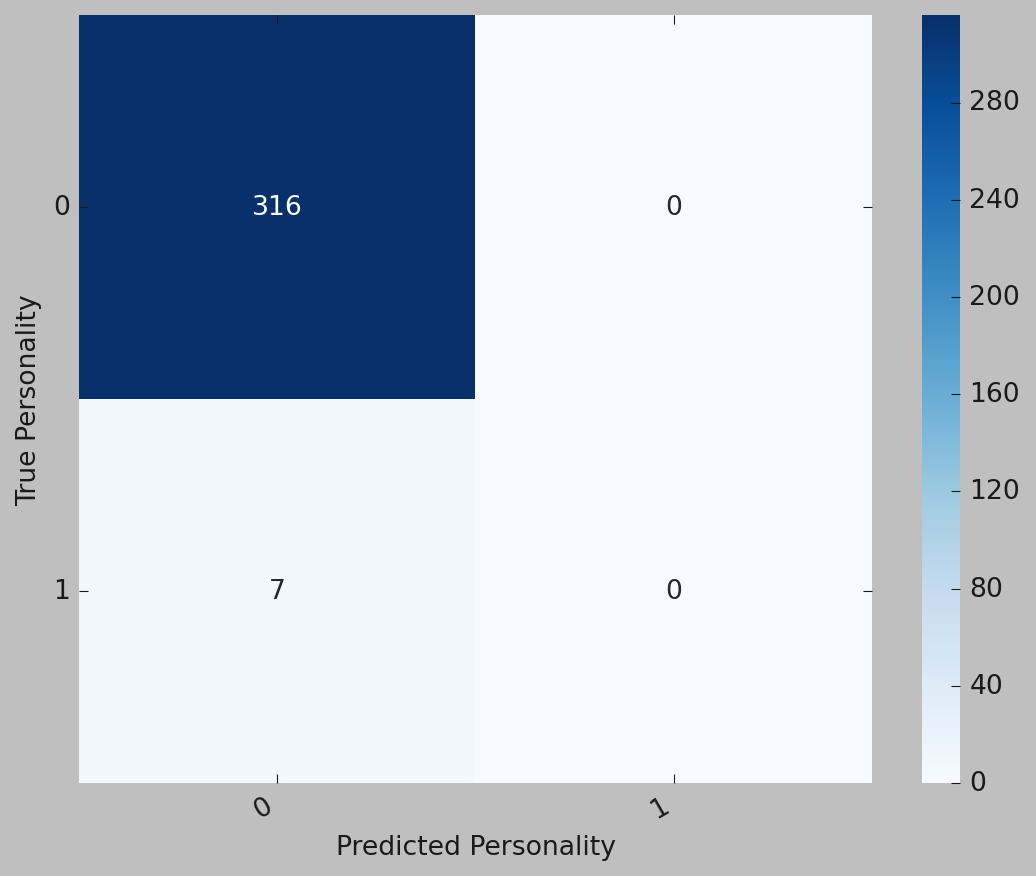

In [108]:
i = 2
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       319
           1       0.00      0.00      0.00         4

    accuracy                           0.99       323
   macro avg       0.49      0.50      0.50       323
weighted avg       0.98      0.99      0.98       323



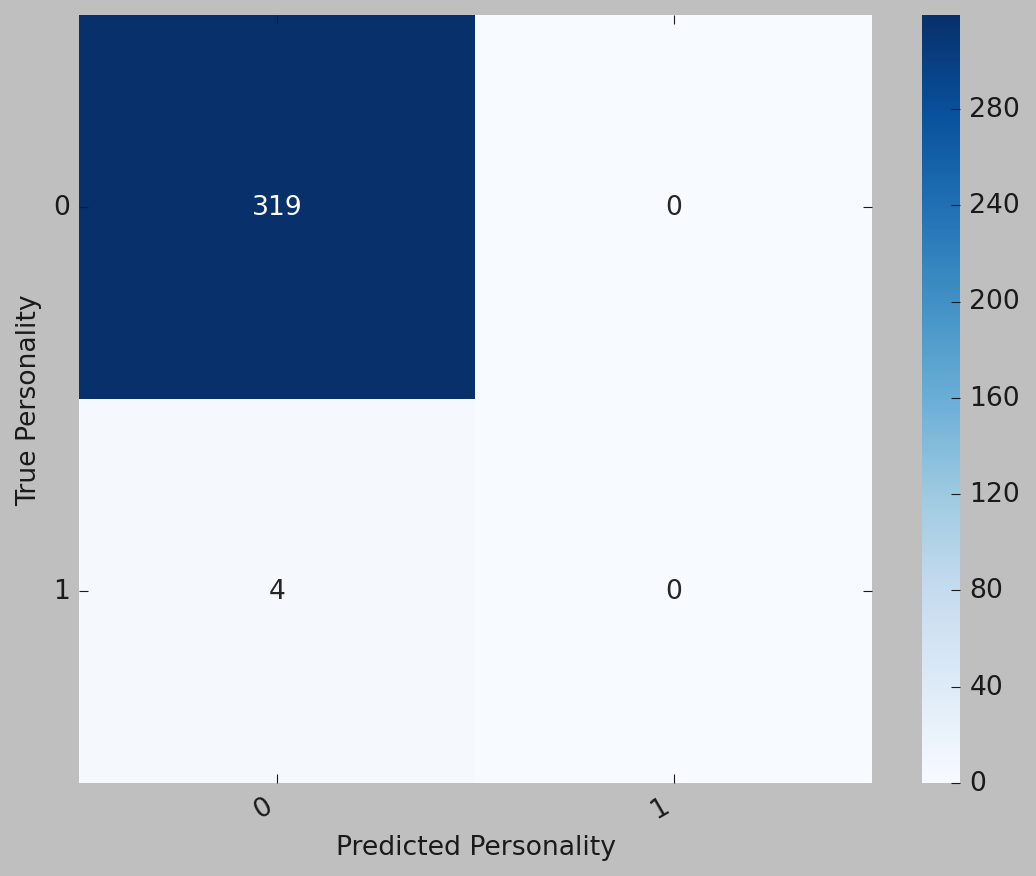

In [109]:
i = 3
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       304
           1       0.00      0.00      0.00        19

    accuracy                           0.94       323
   macro avg       0.47      0.50      0.48       323
weighted avg       0.89      0.94      0.91       323



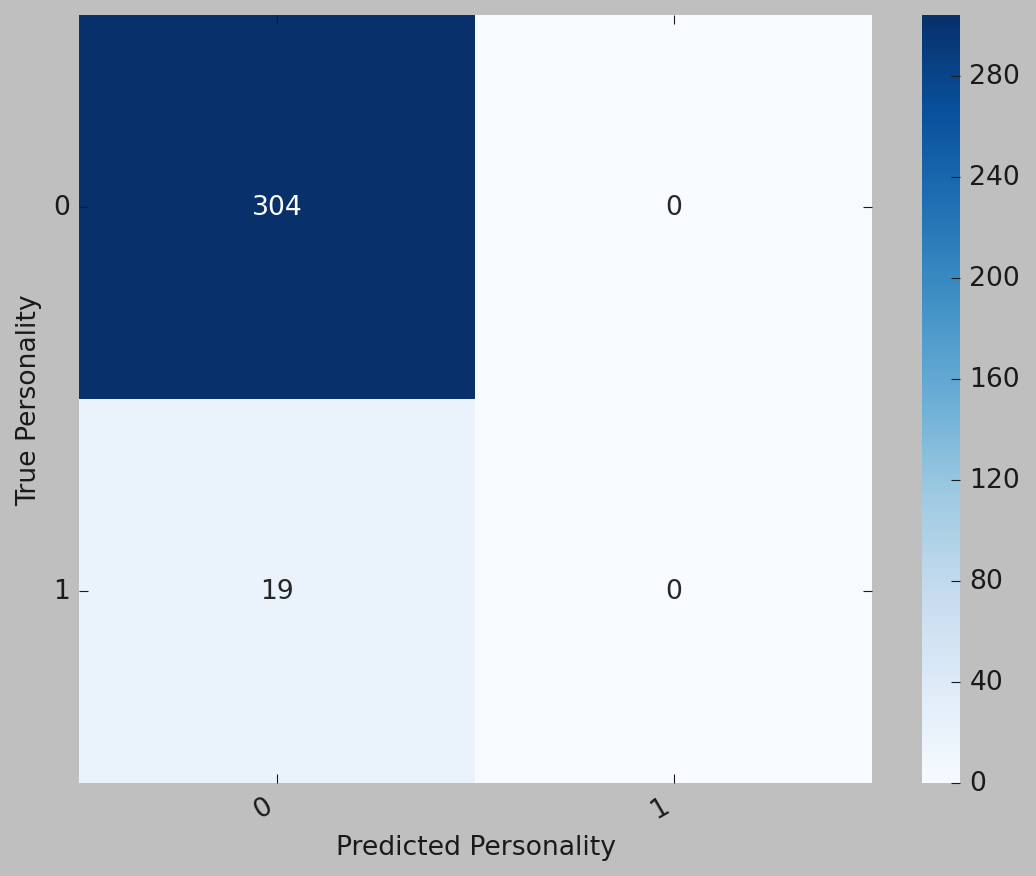

In [110]:
i = 4
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       300
           1       0.00      0.00      0.00        23

    accuracy                           0.93       323
   macro avg       0.46      0.50      0.48       323
weighted avg       0.86      0.93      0.89       323



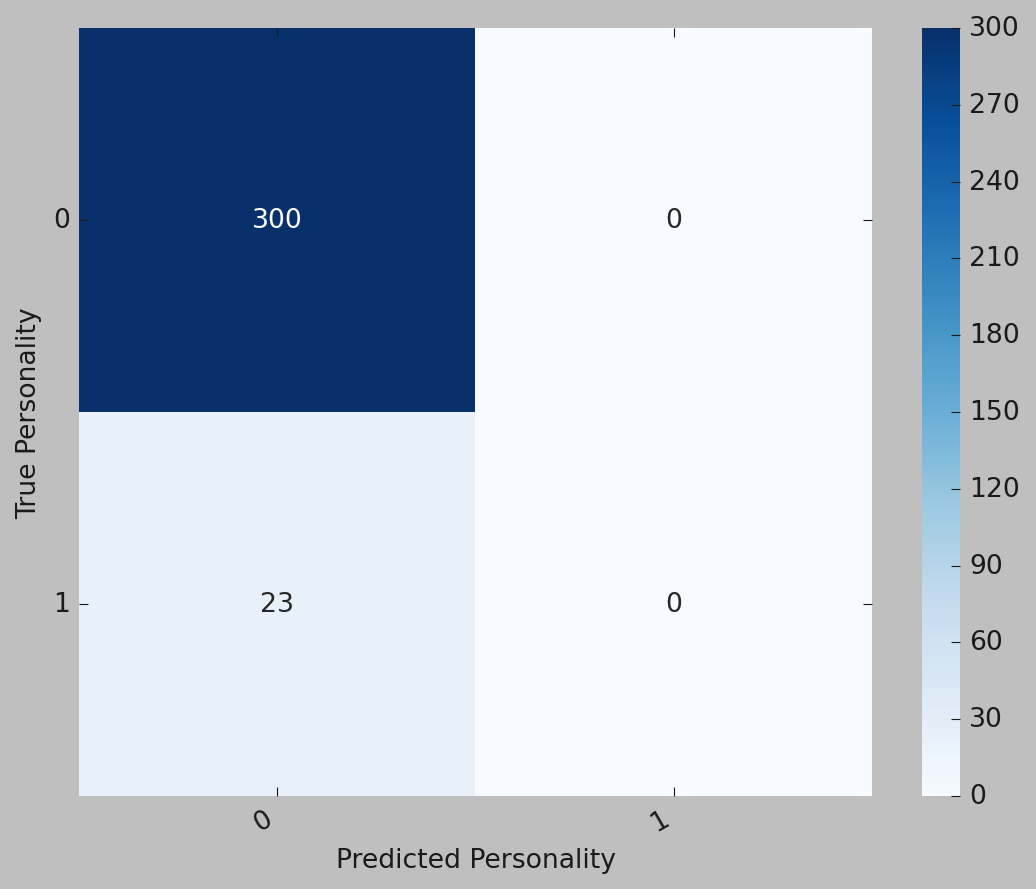

In [111]:
i = 5
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       313
           1       0.00      0.00      0.00        10

    accuracy                           0.97       323
   macro avg       0.48      0.50      0.49       323
weighted avg       0.94      0.97      0.95       323



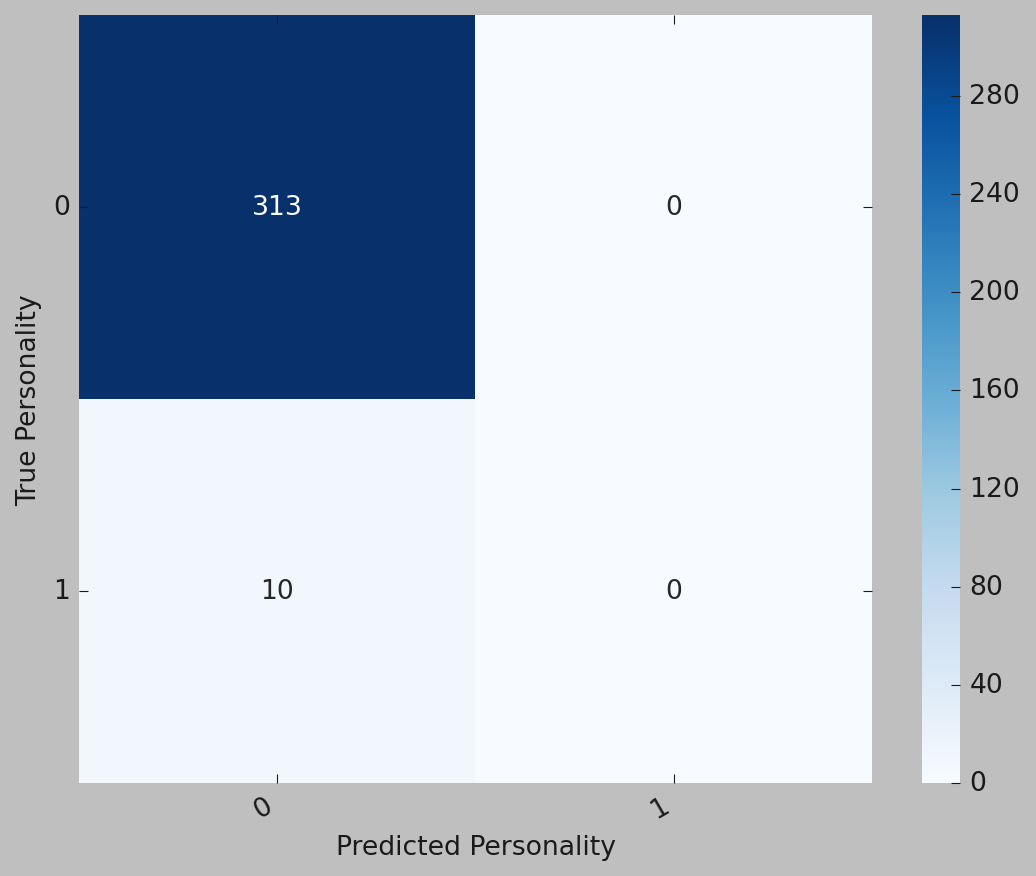

In [112]:
i = 6
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



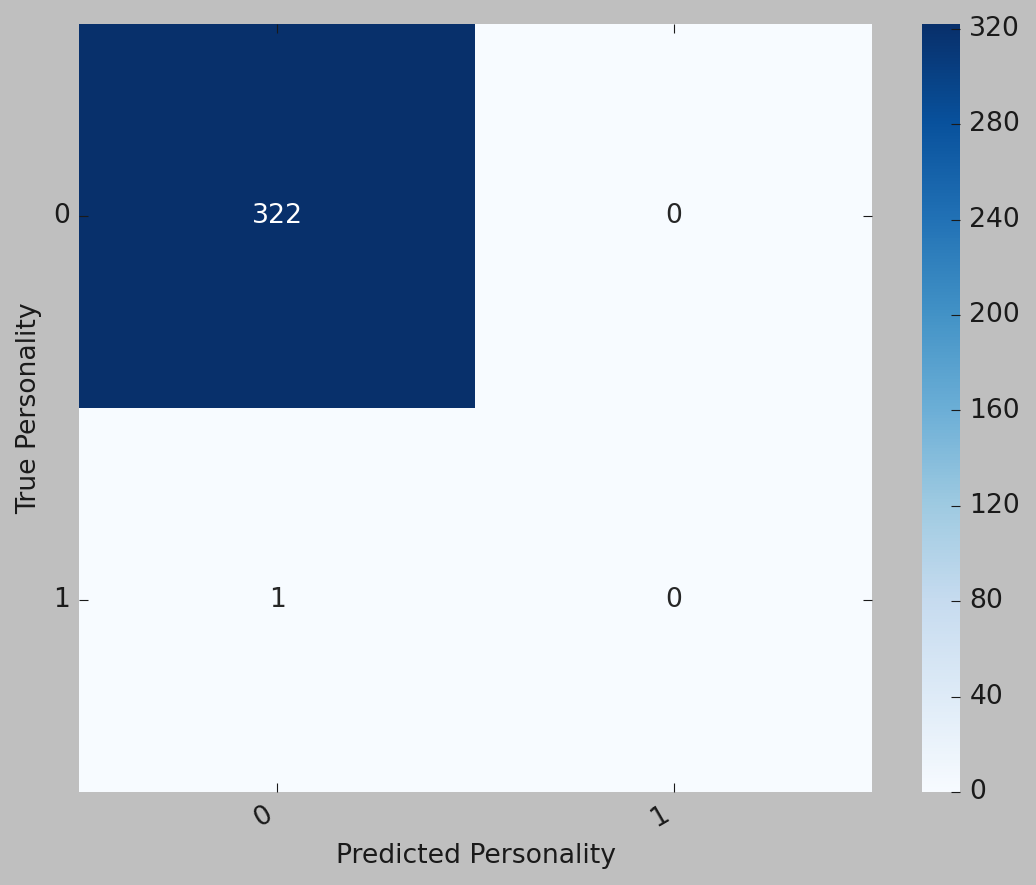

In [113]:
i = 7
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       0.74      0.17      0.28       100
           1       0.72      0.97      0.83       223

    accuracy                           0.72       323
   macro avg       0.73      0.57      0.55       323
weighted avg       0.73      0.72      0.66       323



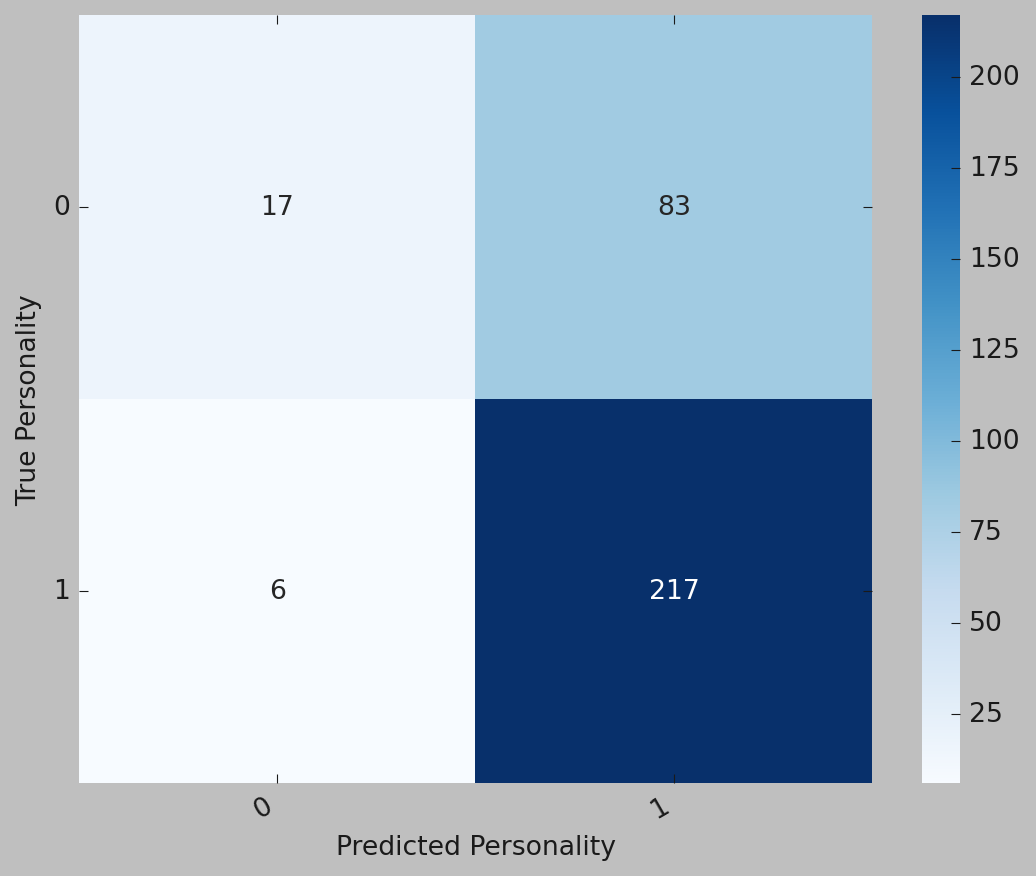

In [114]:
i = 8
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       0.00      0.00      0.00         1

    accuracy                           1.00       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.99      1.00      1.00       323



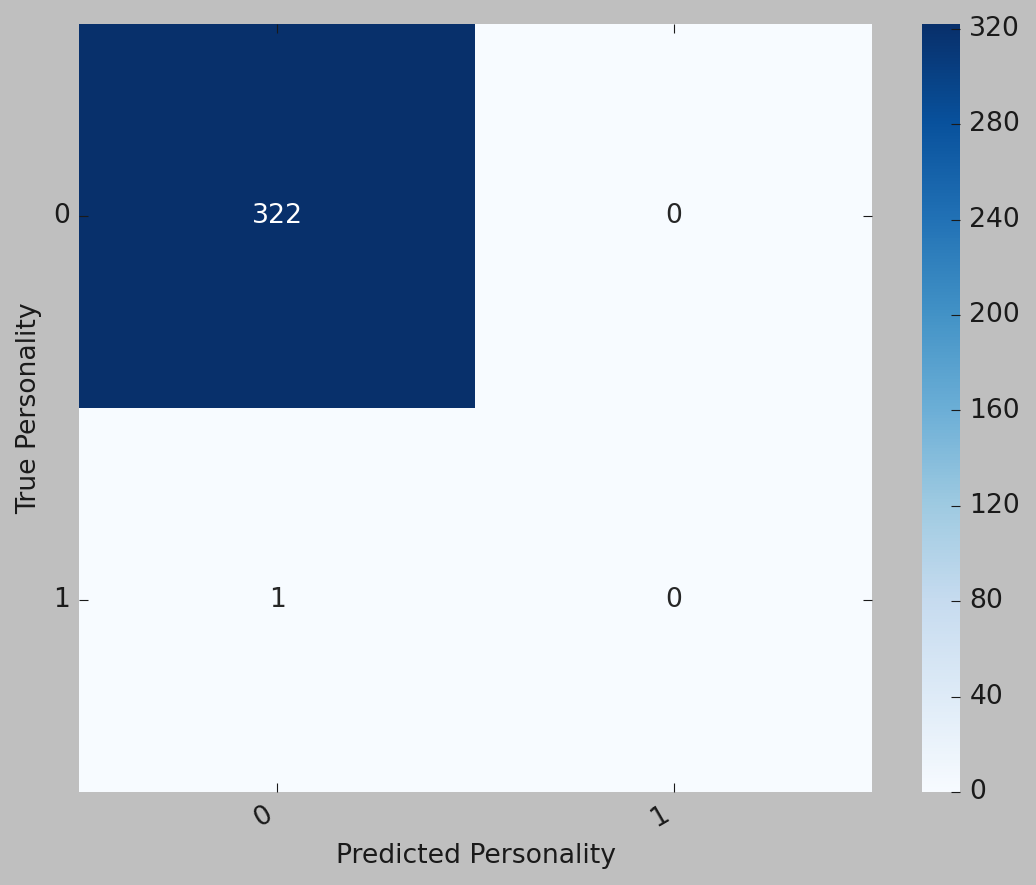

In [115]:
i = 9
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       181
           1       0.59      0.80      0.68       142

    accuracy                           0.67       323
   macro avg       0.69      0.69      0.67       323
weighted avg       0.70      0.67      0.67       323



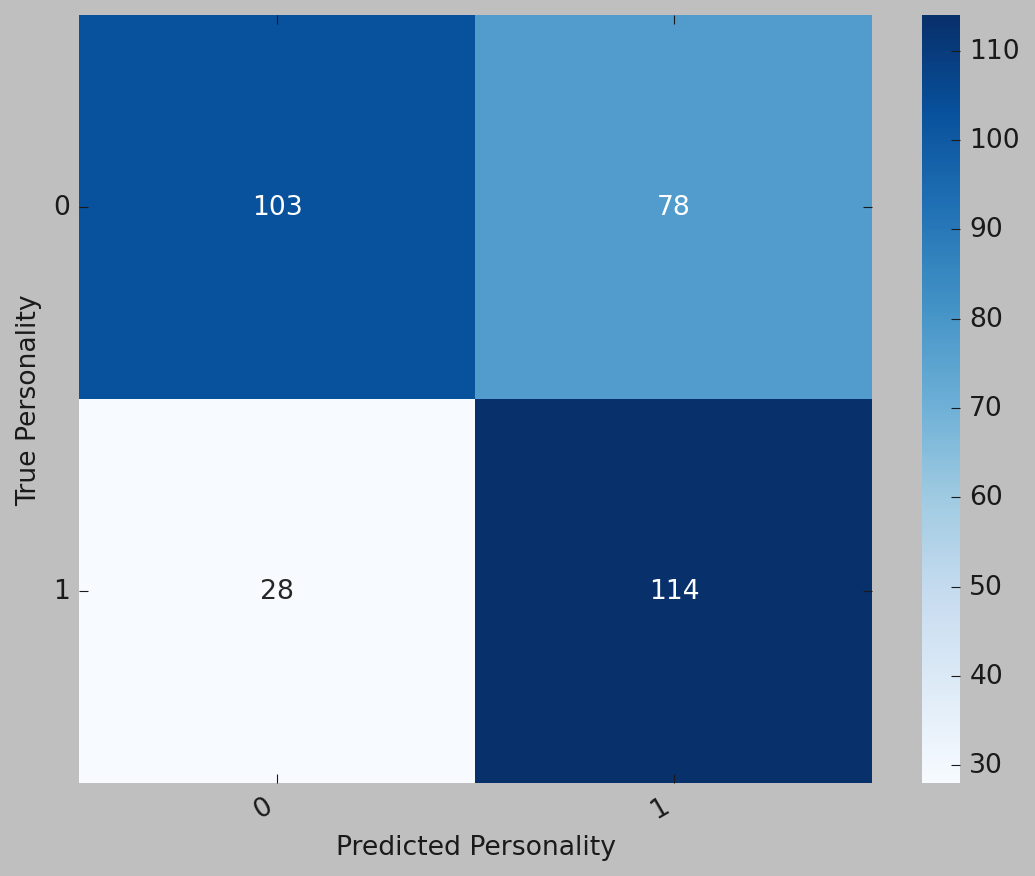

In [116]:
i = 10
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       317
           1       0.00      0.00      0.00         6

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.50       323
weighted avg       0.96      0.98      0.97       323



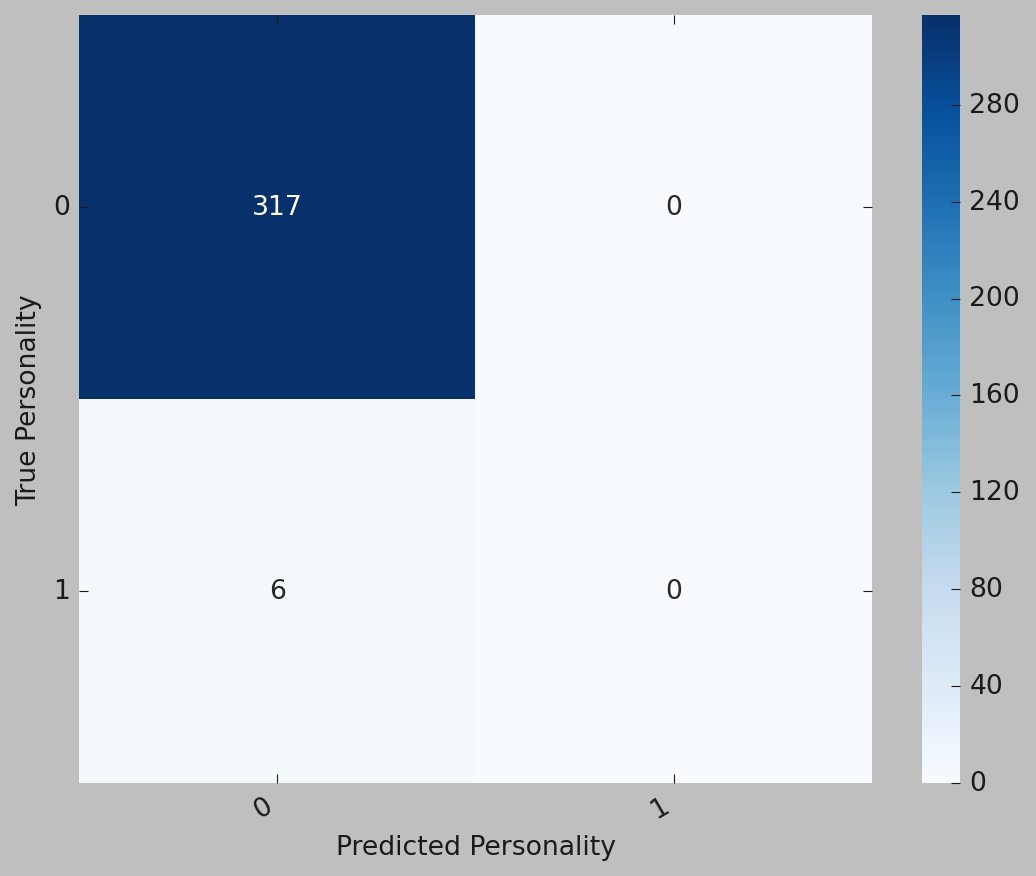

In [117]:
i = 11
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



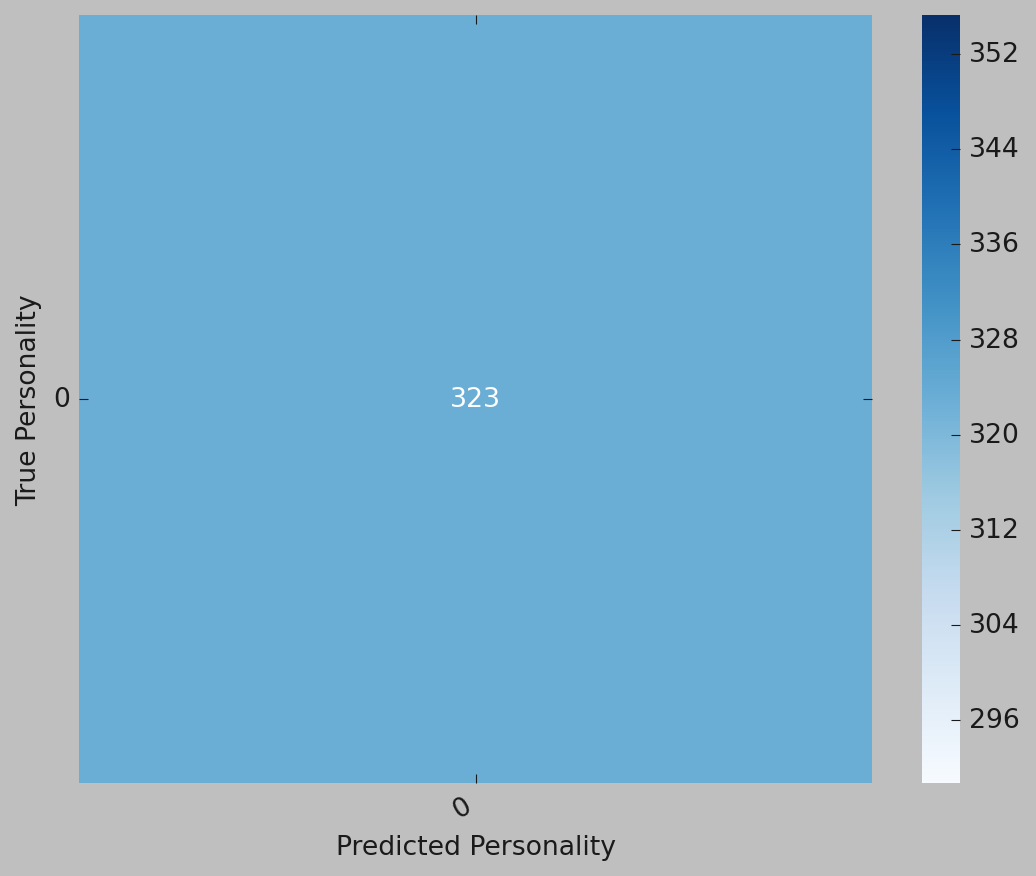

In [118]:
i = 12
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



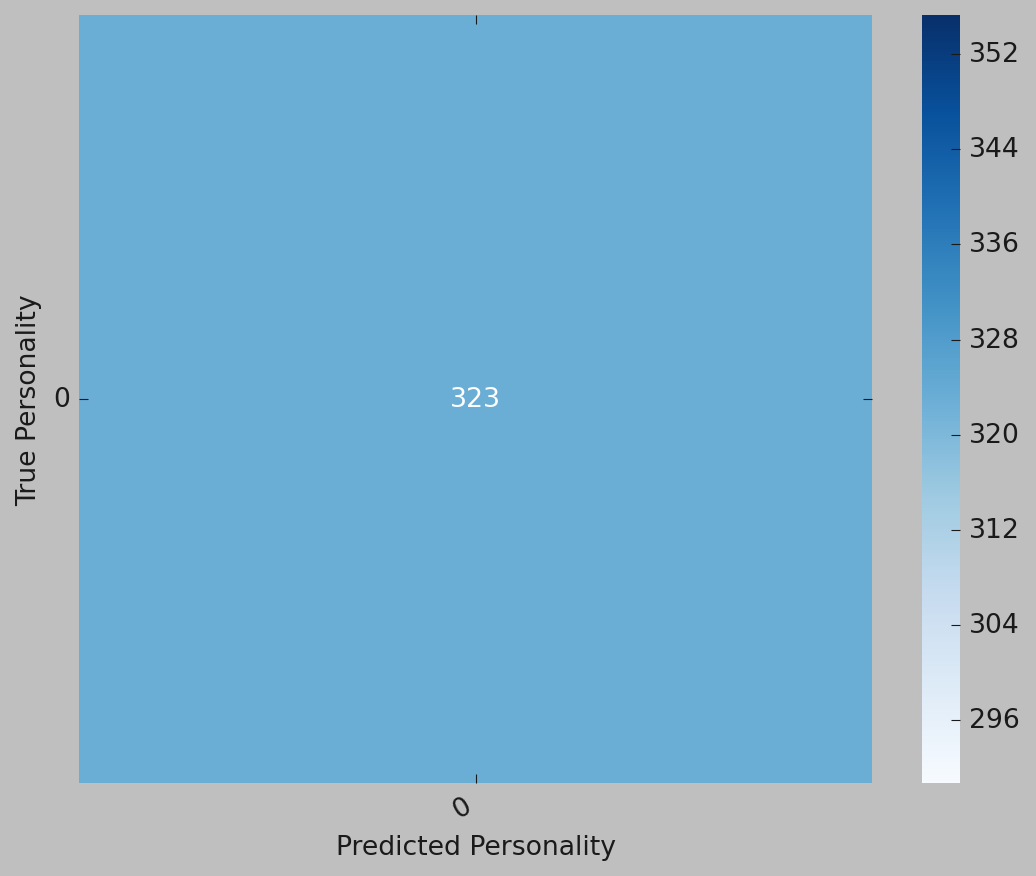

In [119]:
i = 13
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       320
           1       0.00      0.00      0.00         3

    accuracy                           0.99       323
   macro avg       0.50      0.50      0.50       323
weighted avg       0.98      0.99      0.99       323



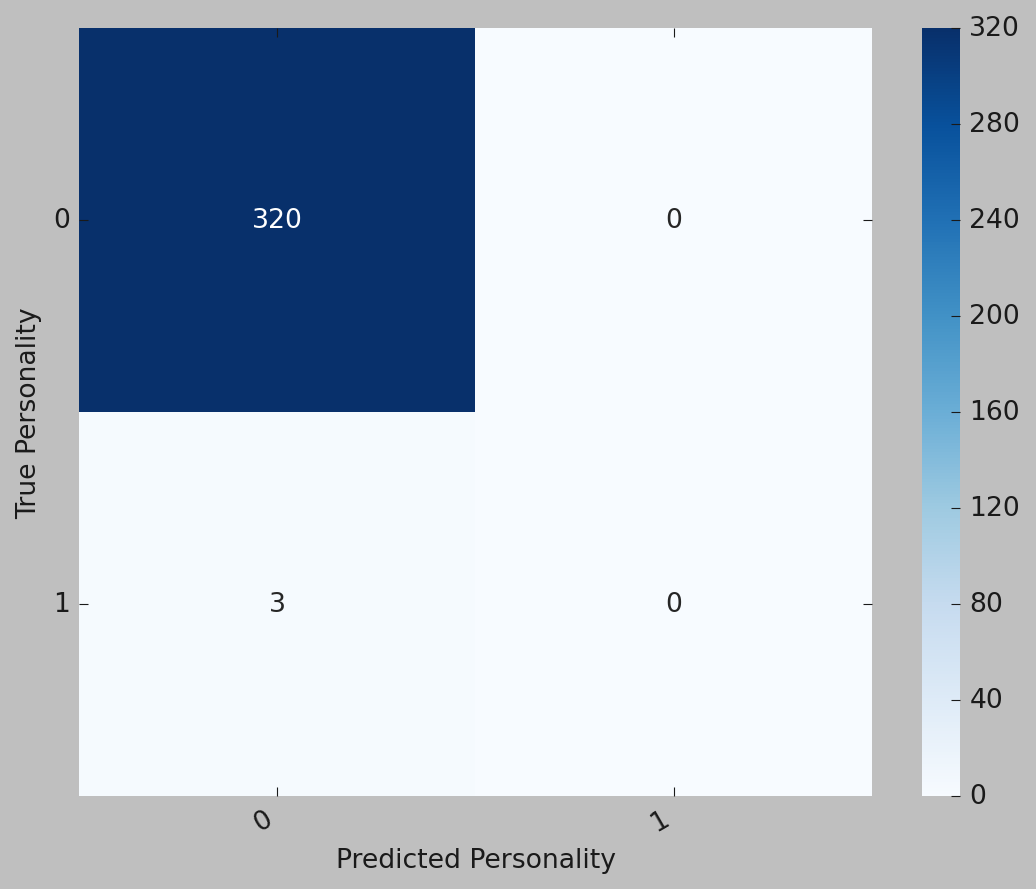

In [120]:
i = 14
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       316
           1       0.00      0.00      0.00         7

    accuracy                           0.98       323
   macro avg       0.49      0.50      0.49       323
weighted avg       0.96      0.98      0.97       323



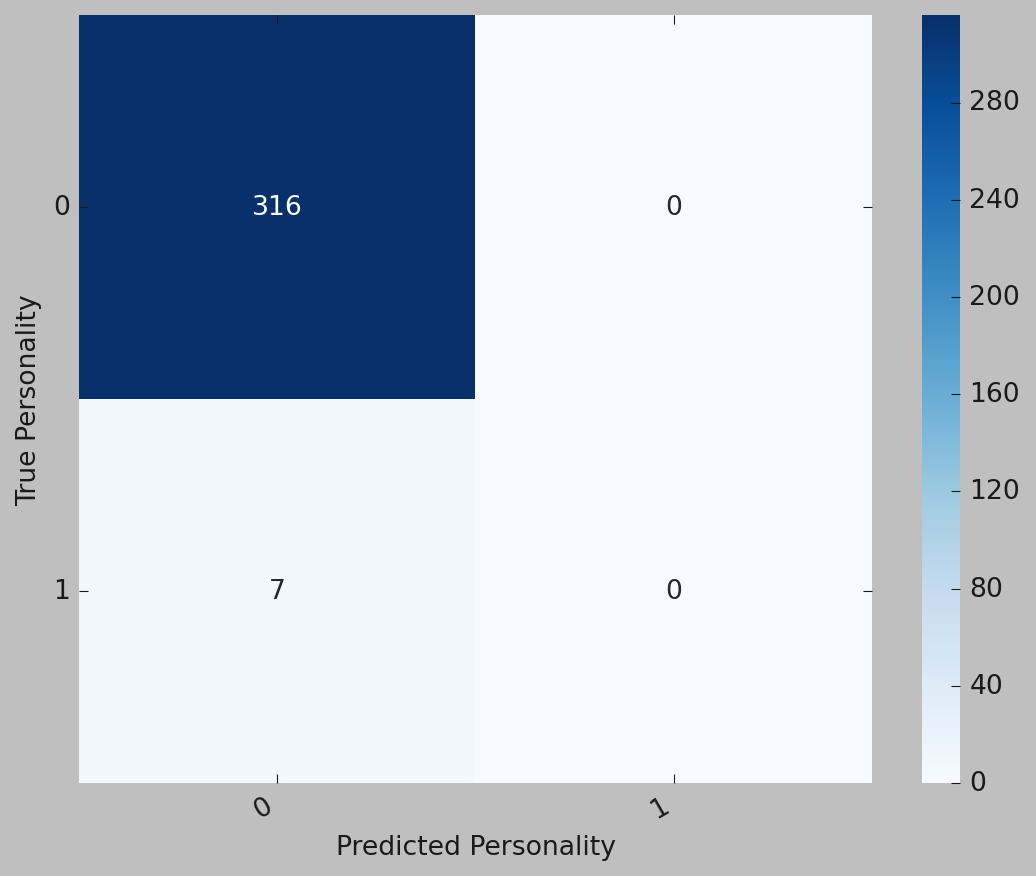

In [121]:
i = 15
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       273
           1       0.36      0.26      0.30        50

    accuracy                           0.81       323
   macro avg       0.62      0.59      0.60       323
weighted avg       0.79      0.81      0.80       323



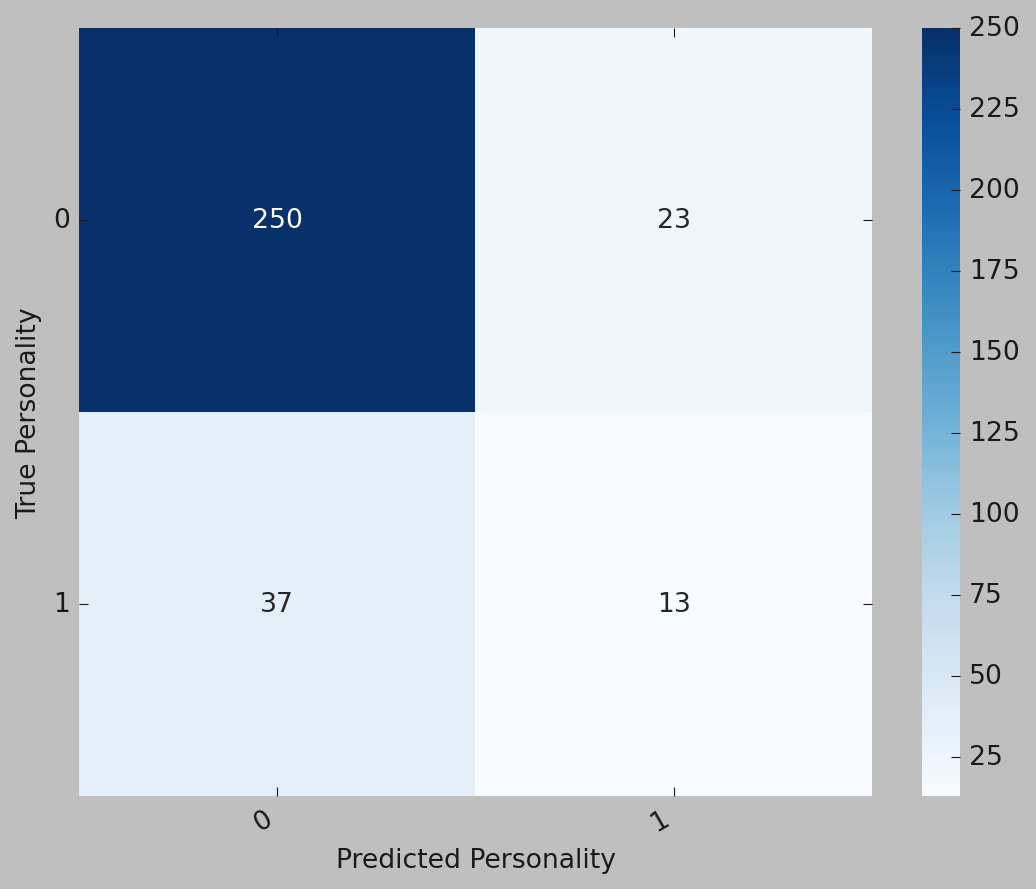

In [122]:
i = 16
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



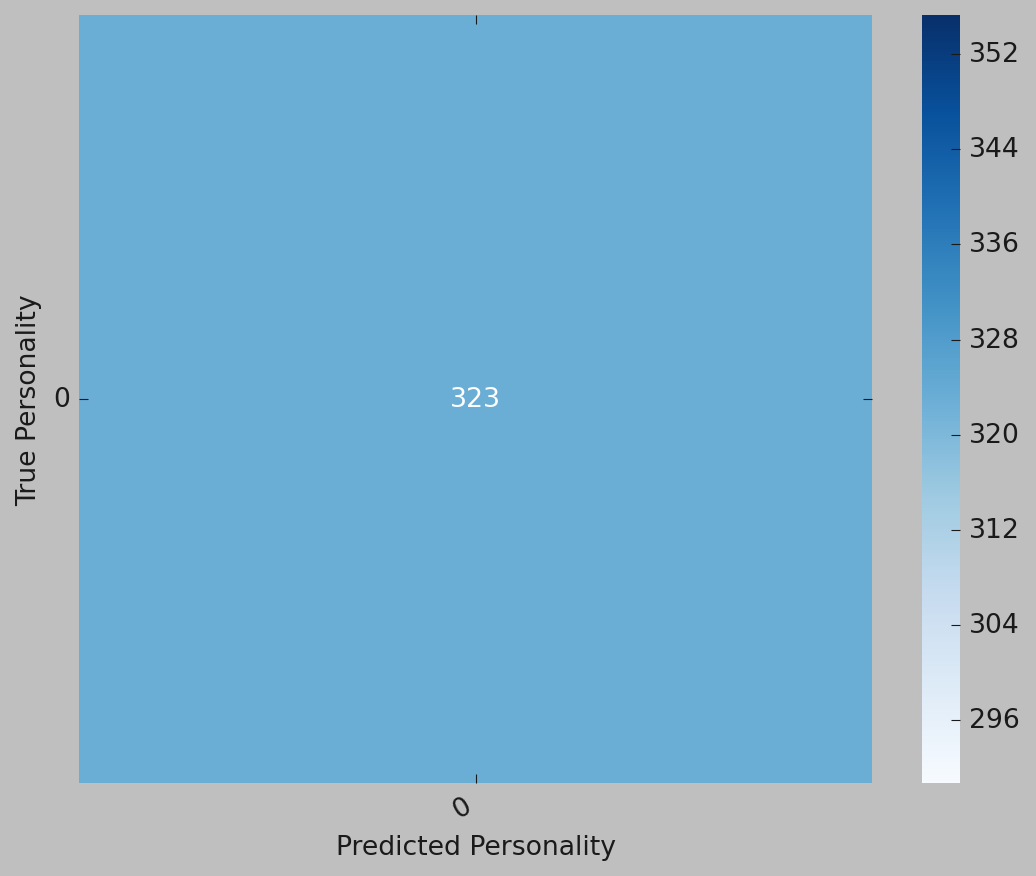

In [123]:
i = 17
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



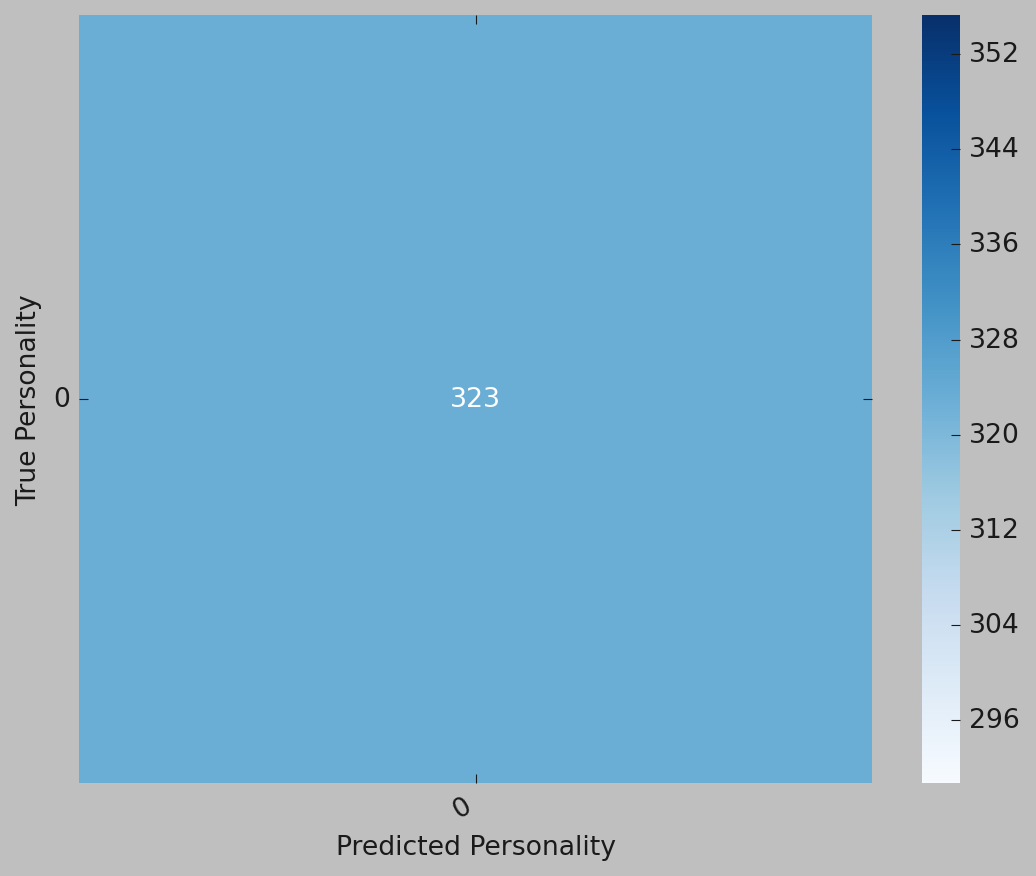

In [124]:
i = 18
print(classification_report(np.array(list(np.array(labels)[:, i])),predictio[i,:] ))
cm = confusion_matrix(np.array(list(np.array(labels)[:, i])), predictio[i,:])
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [125]:
predictio.shape

(19, 323)

In [126]:
output = []
for id,p in zip(testjsonobj,predictio.T):
    output.append({'id': id['id'], 'text': id['text'], 'labels': [propaganda_techniques_names[j] for j in [i for i, e in enumerate(p) if e == 1]]})


In [127]:
with open("output.json", "w") as final:
   json.dump(output, final)

In [128]:
print(predictio.shape)
predictio = predictio.T
print(predictio.shape)


(19, 323)
(323, 19)


In [129]:
labels = np.array(labels)
labels = labels.astype('int')
print(labels.shape)


(323, 19)


In [130]:
print(classification_report(labels, predictio, target_names=propaganda_techniques_names))


                                                     precision    recall  f1-score   support

                                Appeal to authority       0.00      0.00      0.00         1
                           Appeal to fear/prejudice       0.00      0.00      0.00        25
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         7
                          Causal Oversimplification       0.00      0.00      0.00         4
                                              Doubt       0.00      0.00      0.00        19
                          Exaggeration/Minimisation       0.00      0.00      0.00        23
                                        Flag-waving       0.00      0.00      0.00        10
                   Glittering generalities (Virtue)       0.00      0.00      0.00         1
                                    Loaded Language       0.72      0.97      0.83       223
Misrepresentation of Someone's Position (Straw Man)       0.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [131]:
!python3 scorer/task1.py  --log_to_file --gold_file_path='data/task1_test_gold_label_final.json' --pred_file_path='output.json' --classes_file_path="techniques_list_task1-2.txt"


INFO : Logging execution to file output.json.log
INFO : Reading gold file
INFO : Reading predictions file
INFO : Prediction file format is correct
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
INFO : macro-F1=0.08642	micro-F1=0.62888
0.08641848703829771	0.6288848263254113


In [132]:
def plot_roc_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc))
        # Compute micro-average ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        # Plot ROC curve
        plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc))
    else:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.rc('figure', figsize=(15, 15))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc=0, prop={'size': 10})
    plt.show()

[[[322   0]
  [  1   0]]

 [[298   0]
  [ 25   0]]

 [[316   0]
  [  7   0]]

 [[319   0]
  [  4   0]]

 [[304   0]
  [ 19   0]]

 [[300   0]
  [ 23   0]]

 [[313   0]
  [ 10   0]]

 [[322   0]
  [  1   0]]

 [[ 17  83]
  [  6 217]]

 [[322   0]
  [  1   0]]

 [[103  78]
  [ 28 114]]

 [[317   0]
  [  6   0]]

 [[323   0]
  [  0   0]]

 [[323   0]
  [  0   0]]

 [[320   0]
  [  3   0]]

 [[316   0]
  [  7   0]]

 [[250  23]
  [ 37  13]]

 [[323   0]
  [  0   0]]

 [[323   0]
  [  0   0]]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1
           8       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

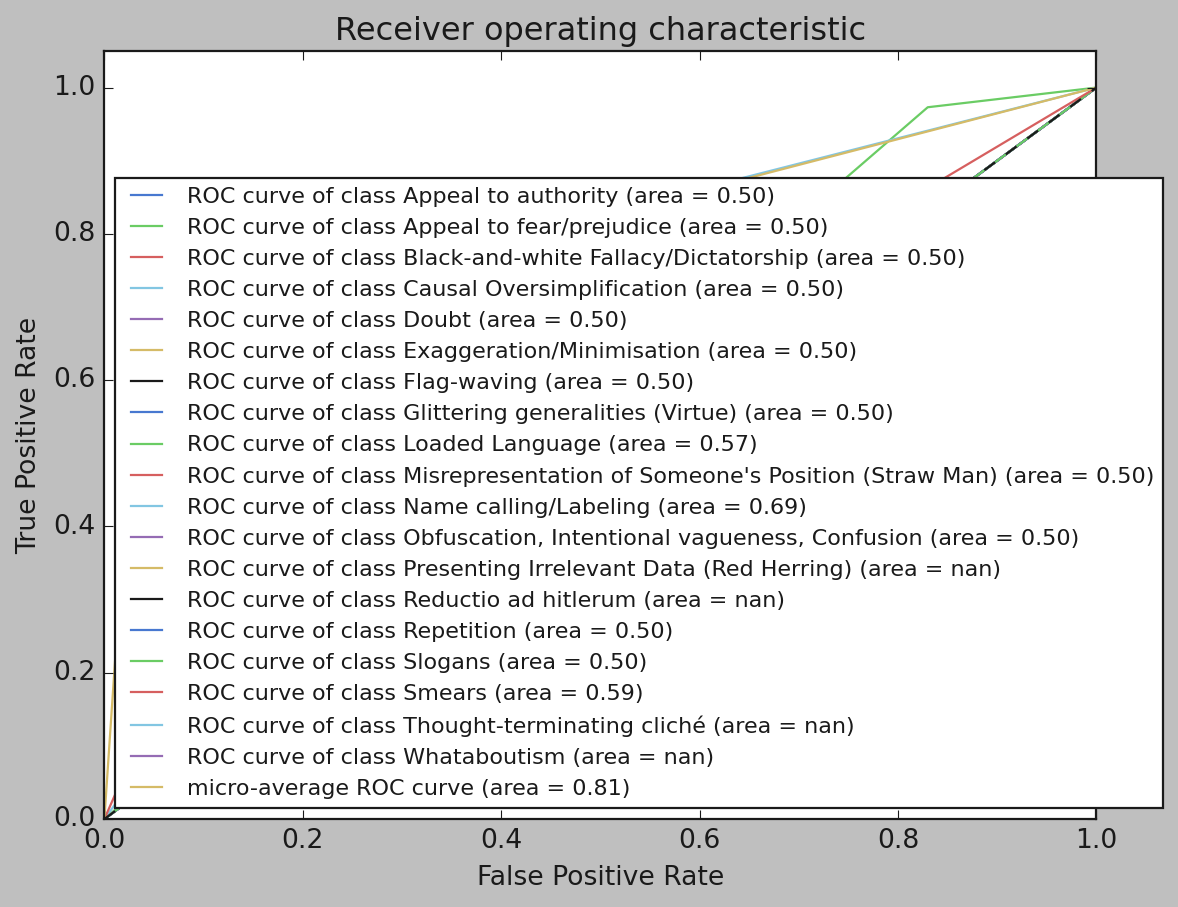

In [133]:
from sklearn.metrics import auc, roc_curve
import sklearn.metrics as skm
cm = skm.multilabel_confusion_matrix(labels, predictio)
print(cm)
print( skm.classification_report(labels, predictio))

plot_roc_auc(labels, predictio, propaganda_techniques_names)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


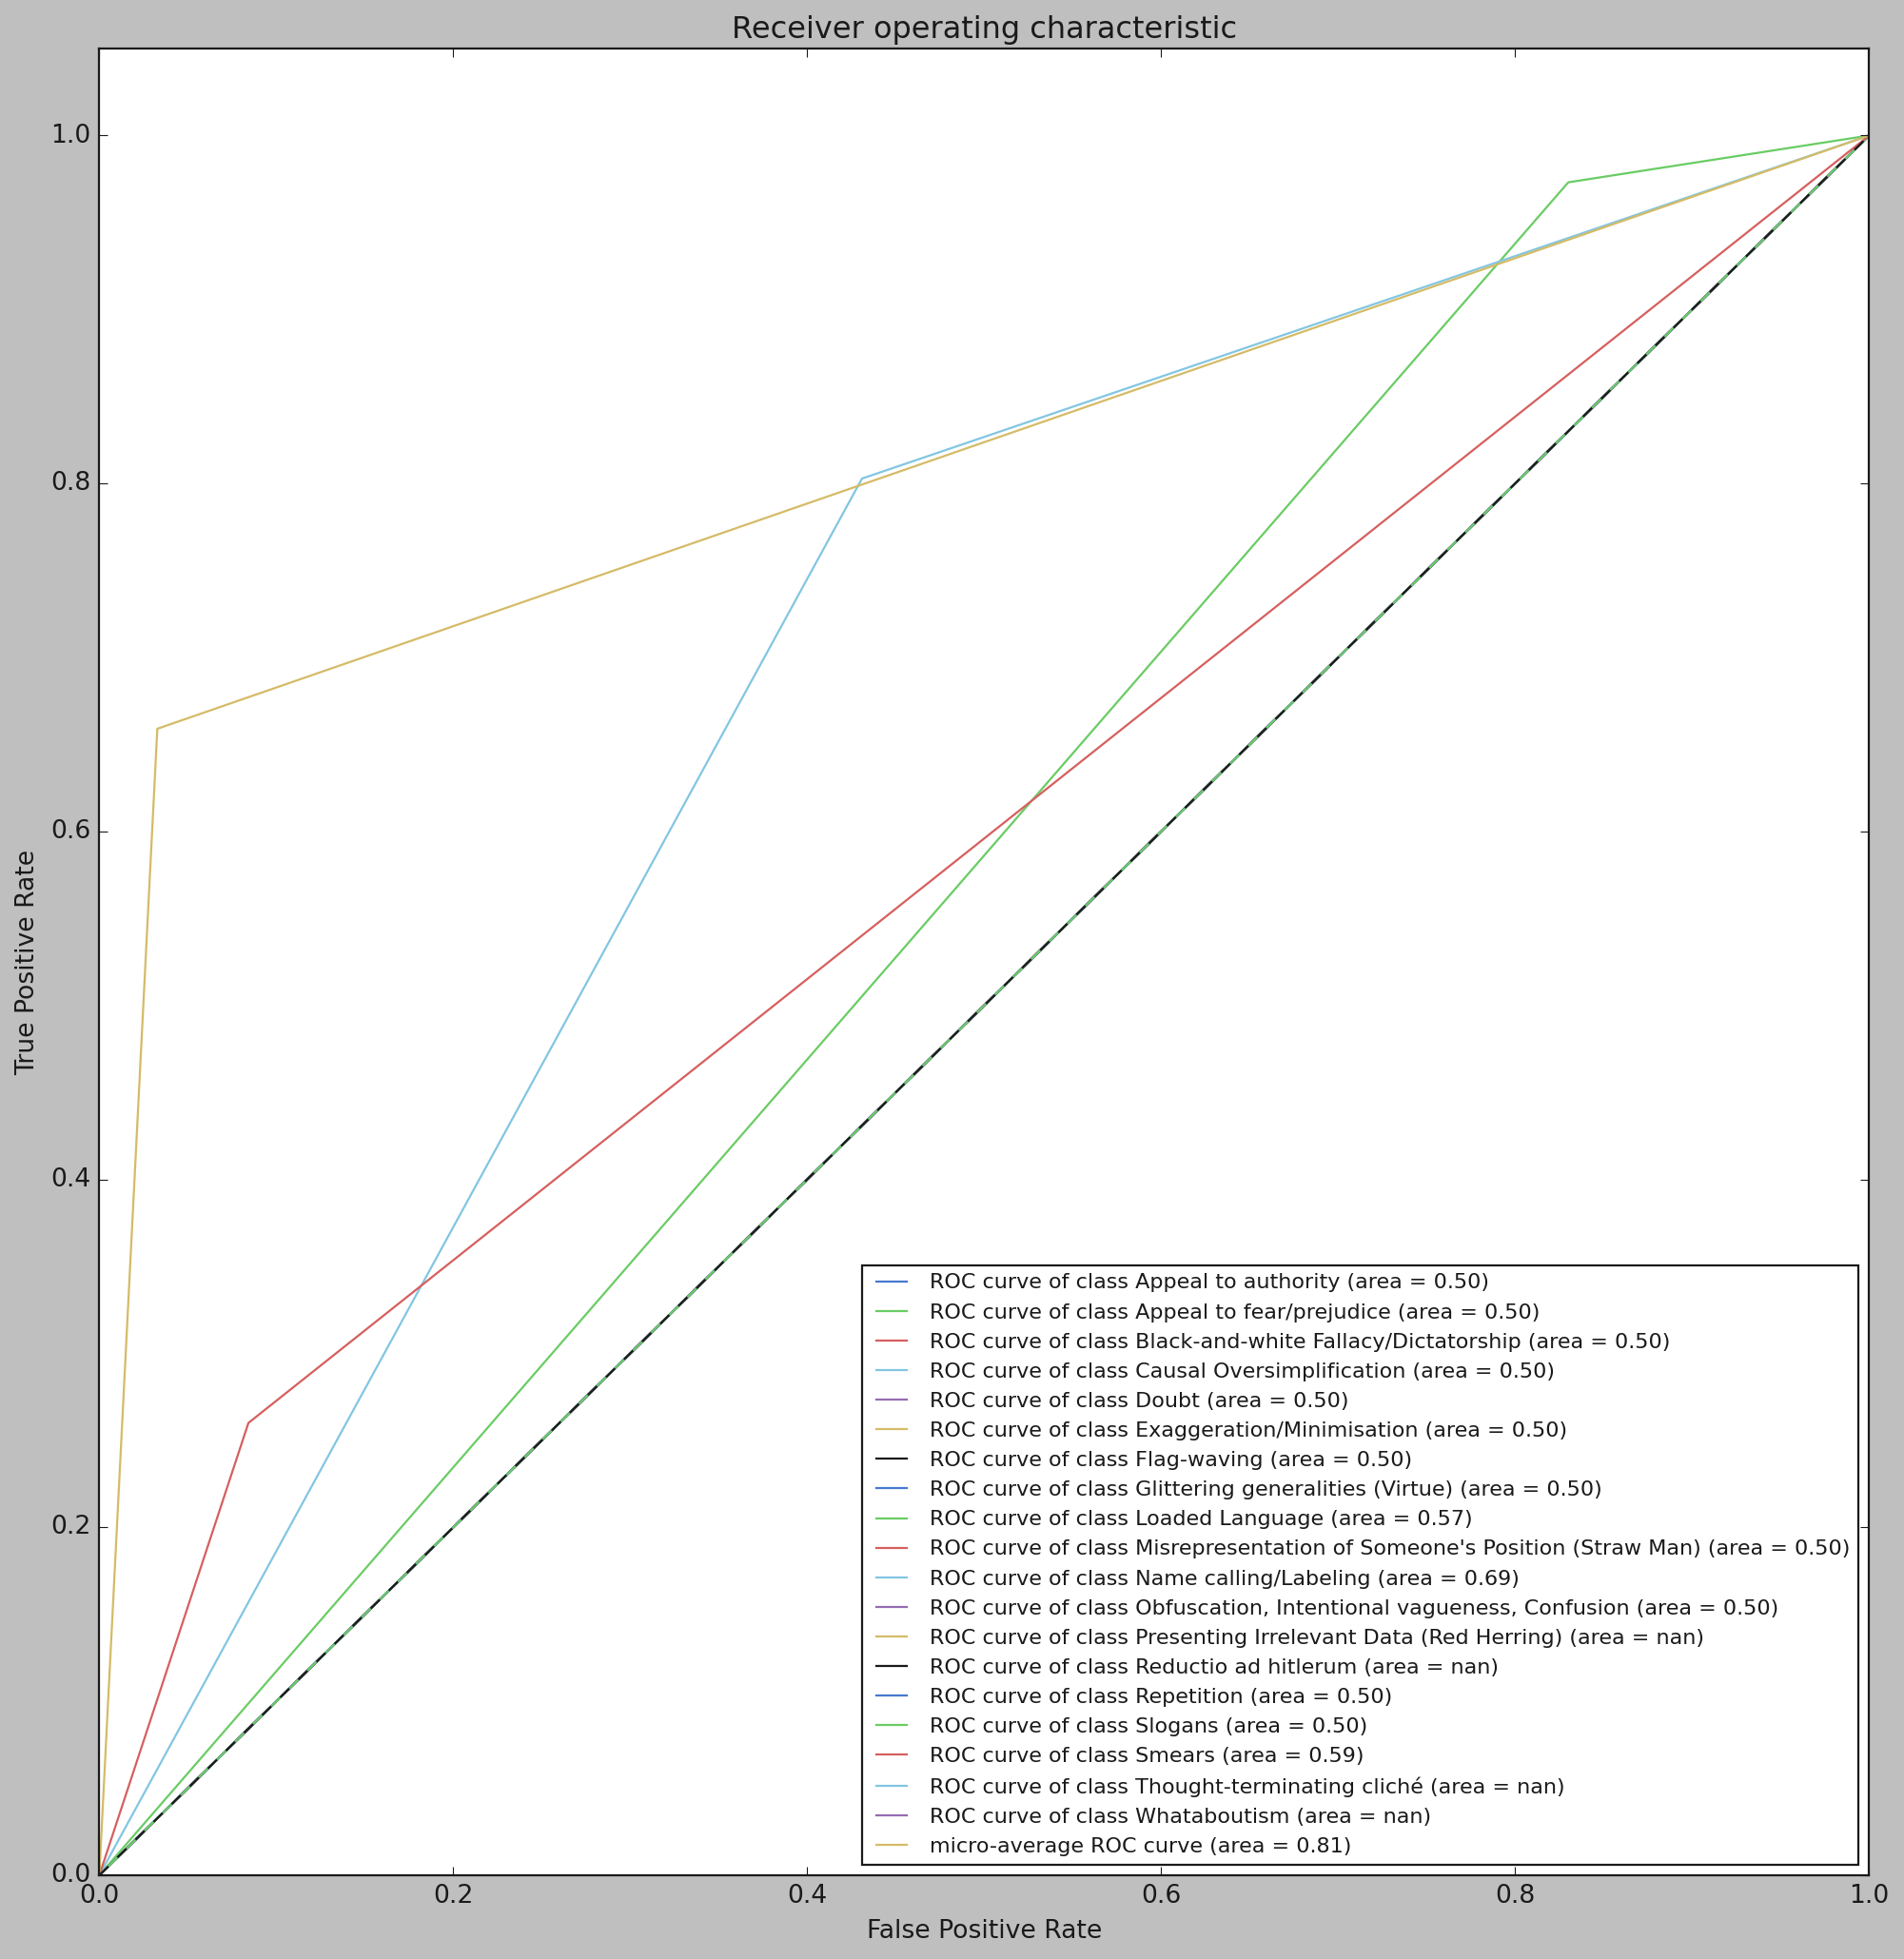

In [134]:
plot_roc_auc(labels, predictio, propaganda_techniques_names)